In [1]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *
from disease_model import * 
import helper_methods_for_aggregate_data_analysis as helper
from model_experiments import *
from model_results import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as tick
from collections import Counter 
import datetime
from scipy.stats import linregress 
import os
import pickle

Setting numpy cores to 1
Running code on rambo.stanford.edu; at Stanford=True


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


# Model fit 

In [2]:
# Load models after grid search
min_timestring = '2020_07_16_10_4'
max_timestring = '2020_07_18'
df = evaluate_all_fitted_models_for_experiment('normal_grid_search', 
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring)
df['MSA_name'] = df['data_kwargs'].map(lambda x:x['MSA_name'])
ablation_df = df.loc[df['poi_psi'] == 0].copy()  # models without mobility
non_ablation_df = df.loc[df['poi_psi'] > 0].copy()
df = None

Loading models with timestrings between 2020_07_16_10_4 and 2020_07_18
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 17000 fitted models for normal_grid_search
Loaded 1 models so far: 0.186s -> 0.186s per model
Loaded 1001 models so far: 42.089s -> 0.042s per model
Loaded 2001 models so far: 77.846s -> 0.039s per model
Loaded 3001 models so far: 114.220s -> 0.038s per model
Loaded 4001 models so far: 148.372s -> 0.037s per model
Loaded 5001 models so far: 182.909s -> 0.037s per model
Loaded 6001 models so far: 217.222s -> 0.036s per model
Loaded 7001 models so far: 253.226s -> 0.036s per model
Loaded 8001 models so far: 288.768s -> 0.036s per model
Loaded 9001 models so far: 326.373s -> 0.036s per model
Loaded 10001 models so far: 362.860s -> 0.036s per model
Loaded 11001 models so far: 397.977s -> 0.036s per model
Loaded 12001 models so far: 435.052s -> 0.036s per model
Loaded 13001 models so far: 471.409s -> 0.036s per model
Load

In [3]:
min_timestring = '2020_07_17_15_29_07_631477'
agg_gridsearch_df = evaluate_all_fitted_models_for_experiment('grid_search_aggregate_mobility', 
                                                              min_timestring=min_timestring)  # aggregate mobility models
agg_gridsearch_df['MSA_name'] = agg_gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])

Loading models with timestrings between 2020_07_17_15_29_07_631477 and 2020_10_08_10_48_20_070237
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 15000 fitted models for grid_search_aggregate_mobility
Loaded 1 models so far: 0.039s -> 0.039s per model
Loaded 1001 models so far: 54.312s -> 0.054s per model
Loaded 2001 models so far: 107.608s -> 0.054s per model
Loaded 3001 models so far: 163.490s -> 0.054s per model
Loaded 4001 models so far: 218.358s -> 0.055s per model
Loaded 5001 models so far: 273.939s -> 0.055s per model
Loaded 6001 models so far: 327.810s -> 0.055s per model
Loaded 7001 models so far: 380.506s -> 0.054s per model
Loaded 8001 models so far: 434.897s -> 0.054s per model
Loaded 9001 models so far: 489.323s -> 0.054s per model
Loaded 10001 models so far: 542.702s -> 0.054s per model
Loaded 11001 models so far: 596.406s -> 0.054s per model
Loaded 12001 models so far: 650.020s -> 0.054s per model
Loaded 13001 models s

## Grid search parameter table

In [4]:
print(f'Loss tolerance: {ACCEPTABLE_LOSS_TOLERANCE}')
model_df = get_summary_of_best_models(
    non_ablation_df, 
    MSAS,
    ACCEPTABLE_LOSS_TOLERANCE, 
    MAX_MODELS_TO_TAKE_PER_MSA)
keys = ['home_beta', 'poi_psi', 'p_sick_at_t0']
table_df = pd.DataFrame(columns=['MSA', '# models within RMSE threshold'] + keys)
for idx in range(len(model_df)):
    model_dict = {}
    model_dict['MSA'] = MSAS_TO_PRETTY_NAMES[model_df.iloc[idx]['MSA']]
    model_dict['# models within RMSE threshold'] = model_df.iloc[idx]['n_models']
    for key in keys:
        min_key = f'{key}_min'
        max_key = f'{key}_max'
        if key == 'home_beta':
            fmt_string = '%2.3f (%2.3f, %2.3f)'
        elif key == 'poi_psi':
            fmt_string = '%i (%i, %i)'
        else:
            fmt_string = "%2.0e (%2.0e, %2.0e)"
        model_dict[key] = fmt_string % (model_df.iloc[idx][key], 
                                            model_df.iloc[idx][min_key], 
                                            model_df.iloc[idx][max_key])        
    table_df = table_df.append(model_dict, ignore_index=True)
table_df

Loss tolerance: 1.2
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at_t0
home_beta      1.000000 -0.957253      0.648152
poi_psi       -0.957253  1.000000     -0.816216
p_sick_at_t0   0.648152 -0.816216      1.000000
Atlanta_Sandy_Springs_Roswell_GA                  :  16
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at_t0
home_beta      1.000000 -0.948683      0.544331
poi_psi       -0.948683  1.000000     -0.774597
p_sick_at_t0   0.544331 -0.774597      1.000000
Chicago_Naperville_Elgin_IL_IN_WI                 :   4
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at_t0
home_beta      1.000000 -0.974679      0.544107
poi_psi       -0.974679  1.000000     -0.707107
p_sick_at_t0   0.544107 -0.707107      1.000000
Dallas_Fort_Worth_Arlington_TX                    :   5
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at

MSA # models within RMSE threshold             home_beta  \
0        Atlanta                             16  0.004 (0.001, 0.014)   
1        Chicago                              4  0.009 (0.006, 0.011)   
2         Dallas                              5  0.009 (0.004, 0.011)   
3        Houston                              8  0.001 (0.001, 0.009)   
4    Los Angeles                             25  0.006 (0.001, 0.016)   
5          Miami                              7  0.001 (0.001, 0.011)   
6  New York City                              7  0.001 (0.001, 0.009)   
7   Philadelphia                              3  0.009 (0.001, 0.009)   
8  San Francisco                              5  0.006 (0.001, 0.009)   
9  Washington DC                             17  0.016 (0.001, 0.019)   

             poi_psi          p_sick_at_t0  
0   2388 (515, 3325)  5e-04 (1e-04, 2e-03)  
1  1764 (1139, 2076)  2e-04 (2e-04, 5e-04)  
2  1452 (1139, 2388)  2e-04 (1e-04, 2e-04)  
3  2076 (1139, 2076)  2e-04 (1e-04, 5e-04)  
4   2076 (515, 3637)  2e-04 (2e-05, 1e-03)  
5   2388 (515, 2388)  2e-04 (2e-04, 2e-03)  
6  2700 (1452, 3013)  1e-04 (5e-05, 1e-03)  
7    827 (827, 1452)  5e-04 (1e-04, 5e-04)  
8   1139 (827, 1764)  5e-04 (2e-04, 1e-03)  
9    515 (515, 3949)  5e-04 (2e-05, 5e-04)

## Figure 1c: OOS and full fit in highlighted MSA

trajectory_cases_oos_vs_full_fit_Chicago_Naperville_Elgin_IL_IN_WI
Found 14 best fit models within threshold for Chicago
Found 4 best fit models within threshold for Chicago


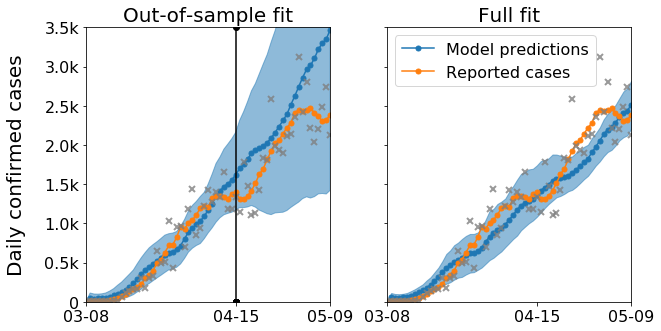

In [48]:
df, df_str = non_ablation_df, 'non_ablation'
thing_to_plot, plot_daily_not_cumulative = 'cases', True
prefix_to_save_plot_with = f'trajectory_{thing_to_plot}_oos_vs_full_fit_{HIGHLIGHT_MSA}'
print(prefix_to_save_plot_with)

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
for idx, ax in enumerate(axes):
    if idx == 0:
        title = 'Out-of-sample fit'
        plot_legend = False
        train_test_partition = TRAIN_TEST_PARTITION
        key_to_sort_by = 'train_loss_dict_daily_cases_RMSE'
    else:
        title = 'Full fit'
        plot_legend = True
        train_test_partition = None
        key_to_sort_by = 'loss_dict_daily_cases_RMSE'
    other_plotting_kwargs =  {
            'plot_log':False, 
            'plot_legend':plot_legend,
            'plot_errorbars':True,
            'xticks':[datetime.datetime(2020, 3, 8), 
                      datetime.datetime(2020, 4, 15),  
                      datetime.datetime(2020, 5, 9)],                                                                             
            'x_range':[datetime.datetime(2020, 3, 8),
                       datetime.datetime(2020, 5, 9)],        
            'y_range': (0, 3500),
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
            'model_line_label': 'Model predictions',
            'true_line_label': 'Reported cases',
            'title':title,
            'title_fontsize':20,
            'marker_size':5,
            'real_data_color':'tab:orange',
            'model_color':'tab:blue',
            'only_two_yticks':False,
            'plot_mode':thing_to_plot,
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
    }
    plot_best_models_fit_for_msa(df, HIGHLIGHT_MSA, ax, key_to_sort_by, train_test_partition, 
                                 other_plotting_kwargs)
    
ax = fig.add_subplot(111, frame_on=False)
ax.tick_params(labelcolor="none", bottom=False, left=False)
ax.set_ylabel('Daily confirmed cases', fontsize=20)
ax.yaxis.set_label_coords(-0.11,0.5)

if prefix_to_save_plot_with is not None:
    for ext in ['pdf']:
        plt.savefig('covid_figures_for_paper/trajectories/%s.%s' % 
                (prefix_to_save_plot_with,
                ext), 
                bbox_inches='tight',
                dpi=600)

plt.tight_layout()
plt.show()

## Figure 1d: full fits for all other MSAs

Atlanta_Sandy_Springs_Roswell_GA
Found 16 best fit models within threshold for Atlanta
Dallas_Fort_Worth_Arlington_TX
Found 5 best fit models within threshold for Dallas
Houston_The_Woodlands_Sugar_Land_TX
Found 8 best fit models within threshold for Houston
Los_Angeles_Long_Beach_Anaheim_CA
Found 25 best fit models within threshold for Los Angeles
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Found 7 best fit models within threshold for Miami
New_York_Newark_Jersey_City_NY_NJ_PA
Found 7 best fit models within threshold for New York City
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Found 3 best fit models within threshold for Philadelphia
San_Francisco_Oakland_Hayward_CA
Found 5 best fit models within threshold for San Francisco
Washington_Arlington_Alexandria_DC_VA_MD_WV
Found 17 best fit models within threshold for Washington DC
trajectory_3x3_grid_cases_full_fit_non_ablation_without_Chicago


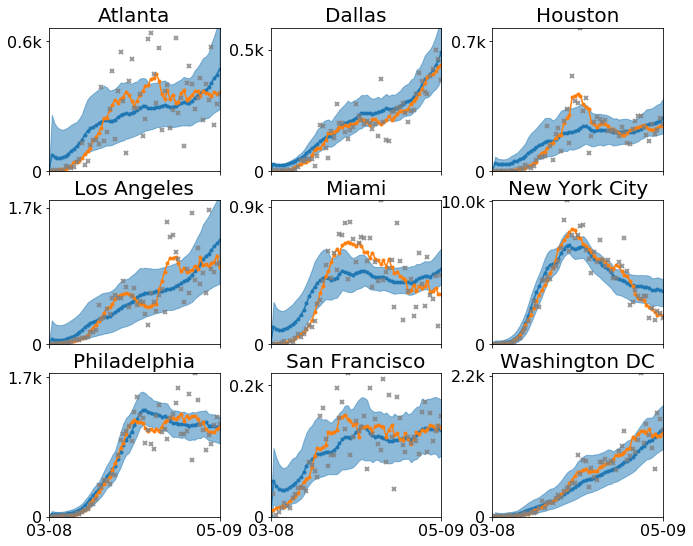

In [49]:
df, df_str = non_ablation_df, 'non_ablation'
train_test_partition, train_test_partition_str, key_to_sort_by = None, 'full_fit', 'loss_dict_daily_cases_RMSE'
thing_to_plot, plot_daily_not_cumulative = 'cases', True
other_plotting_kwargs =  { 
            'plot_log':False, 
            'plot_legend':False,
            'plot_errorbars':True,
            'xticks':[datetime.datetime(2020, 3, 8),                                   
                      datetime.datetime(2020, 5, 9)],                                                                             
            'x_range':[datetime.datetime(2020, 3, 8),
                       datetime.datetime(2020, 5, 9)],                                            
            'title_fontsize':20,
            'marker_size':3,
            'only_two_yticks':True,
            'real_data_color':'tab:orange',
            'model_color':'tab:blue',
            'plot_mode':thing_to_plot,
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
}
prefix_to_save_plot_with = f'trajectory_3x3_grid_{thing_to_plot}_{train_test_partition_str}_{df_str}_without_{MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA]}'
          
fig, axes = plt.subplots(3, 3, figsize=(11,9), sharex=True)
fig.subplots_adjust(wspace=0.3)
axes_list = [ax for axes_row in axes for ax in axes_row]
msas_to_plot_small = [msa for msa in MSAS if msa != HIGHLIGHT_MSA]
for ax, msa_name in zip(axes_list, msas_to_plot_small):
    print(msa_name)
    plot_best_models_fit_for_msa(df, msa_name, ax, key_to_sort_by, train_test_partition, 
                                 other_plotting_kwargs)

if prefix_to_save_plot_with is not None:
    for ext in ['pdf']:
        plt.savefig('covid_figures_for_paper/trajectories/%s.%s' % 
                (prefix_to_save_plot_with,
                ext), 
                dpi=600)
print(prefix_to_save_plot_with)
plt.show()

In [41]:
# quantify test RMSE for out-of-sample models
version = 'daily'
metric = 'RMSE'
mode = 'cases'
train_key = 'train_loss_dict_%s_%s_%s' % (version, mode, metric)
test_key = 'test_loss_dict_%s_%s_%s' % (version, mode, metric)
train_df = get_best_models_for_all_msas(non_ablation_df, train_key, only_single_best=True)
train_df[['MSA_name', train_key, test_key]]

Finding best fit model based on key=train_loss_dict_daily_cases_RMSE, loss tolerance=1.200


MSA_name  \
12975             Atlanta_Sandy_Springs_Roswell_GA   
13225            Chicago_Naperville_Elgin_IL_IN_WI   
2440                Dallas_Fort_Worth_Arlington_TX   
16887          Houston_The_Woodlands_Sugar_Land_TX   
14846            Los_Angeles_Long_Beach_Anaheim_CA   
2325      Miami_Fort_Lauderdale_West_Palm_Beach_FL   
3000          New_York_Newark_Jersey_City_NY_NJ_PA   
2685    Philadelphia_Camden_Wilmington_PA_NJ_DE_MD   
493               San_Francisco_Oakland_Hayward_CA   
14541  Washington_Arlington_Alexandria_DC_VA_MD_WV   

       train_loss_dict_daily_cases_RMSE  test_loss_dict_daily_cases_RMSE  
12975                        117.762430                       617.802064  
13225                        205.095810                       405.595306  
2440                          45.537036                        68.495009  
16887                        113.843837                       304.401547  
14846                        144.852254                       553.207062  
2325                         120.782148                       522.414348  
3000                         829.087118                      1483.694223  
2685                         139.735304                       251.760245  
493                           37.642000                        44.585252  
14541                        106.970862                       810.419971

In [42]:
# quantify test RMSE for full-fit models
full_key = 'loss_dict_%s_%s_%s' % (version, mode, metric)
full_fit_df = get_best_models_for_all_msas(non_ablation_df, full_key, only_single_best=True)
full_fit_df[['MSA_name', full_key, test_key]]

Finding best fit model based on key=loss_dict_daily_cases_RMSE, loss tolerance=1.200


MSA_name  \
12783             Atlanta_Sandy_Springs_Roswell_GA   
13698            Chicago_Naperville_Elgin_IL_IN_WI   
2440                Dallas_Fort_Worth_Arlington_TX   
12873          Houston_The_Woodlands_Sugar_Land_TX   
1623             Los_Angeles_Long_Beach_Anaheim_CA   
5345      Miami_Fort_Lauderdale_West_Palm_Beach_FL   
4936          New_York_Newark_Jersey_City_NY_NJ_PA   
2685    Philadelphia_Camden_Wilmington_PA_NJ_DE_MD   
493               San_Francisco_Oakland_Hayward_CA   
16482  Washington_Arlington_Alexandria_DC_VA_MD_WV   

       loss_dict_daily_cases_RMSE  test_loss_dict_daily_cases_RMSE  
12783                  136.123175                       128.177041  
13698                  292.526622                       387.223632  
2440                    56.035895                        68.495009  
12873                  103.227208                        76.206853  
1623                   281.046450                       380.527735  
5345                   170.586723                       202.735789  
4936                  1035.817910                      1231.663597  
2685                   192.224973                       251.760245  
493                     40.634378                        44.585252  
16482                  216.550758                       295.457856

## Supplement: comparison to aggregate mobility and no-mobility model

In [45]:
# compare train loss
train_agg_df = get_best_models_for_all_msas(agg_gridsearch_df, train_key, only_single_best=True)
train_ablation_df = get_best_models_for_all_msas(ablation_df, train_key, only_single_best=True)
print('Network model vs aggregate mobility model, test RMSE')
compare_best_models(train_df, train_agg_df, test_key)
print('\nNetwork model vs ablation (no-mobility) model, test RMSE')
compare_best_models(train_df, train_ablation_df, test_key)

Finding best fit model based on key=train_loss_dict_daily_cases_RMSE, loss tolerance=1.200
Finding best fit model based on key=train_loss_dict_daily_cases_RMSE, loss tolerance=1.200
Network model vs aggregate mobility model, test RMSE
first has lower loss than second in 8 MSAs; failed on ['Atlanta_Sandy_Springs_Roswell_GA' 'Los_Angeles_Long_Beach_Anaheim_CA']
avg ratio of first / second = 0.580
median ratio of first / second = 0.493

Network model vs ablation (no-mobility) model, test RMSE
first has lower loss than second in 9 MSAs; failed on ['Washington_Arlington_Alexandria_DC_VA_MD_WV']
avg ratio of first / second = 0.463
median ratio of first / second = 0.410


trajectory_2x5_grid_cases_oos_fit_non_ablation
Found 43 best fit models within threshold for Atlanta
Found 14 best fit models within threshold for Chicago
Found 16 best fit models within threshold for Dallas
Found 51 best fit models within threshold for Houston
Found 24 best fit models within threshold for Los Angeles
Found 7 best fit models within threshold for Miami
Found 9 best fit models within threshold for New York City
Found 5 best fit models within threshold for Philadelphia
Found 9 best fit models within threshold for San Francisco
Found 13 best fit models within threshold for Washington DC


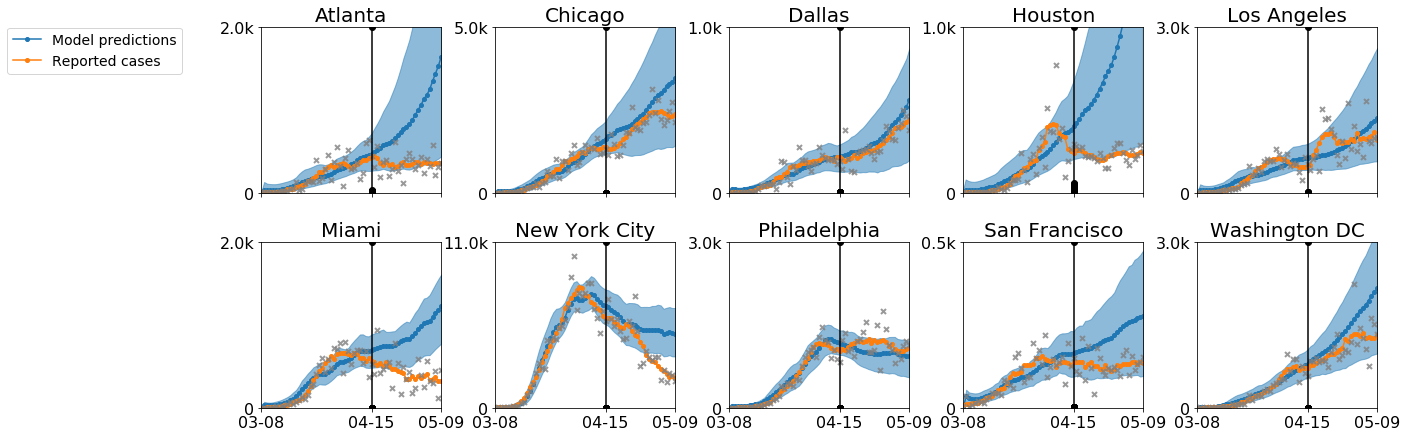

In [13]:
# full network model
y_maxes = [2000, 5000, 1000, 1000, 3000, 2000, 11000, 3000, 500, 3000]
plot_best_models_fit_for_all_msas(non_ablation_df, 'non_ablation', TRAIN_TEST_PARTITION, 'train_loss_dict_daily_cases_RMSE', 
                                  'cases', plot_daily_not_cumulative=True, save_fig=False, y_maxes=y_maxes)

trajectory_2x5_grid_cases_oos_fit_agg_mobility
Found 20 best fit models within threshold for Atlanta
Found 7 best fit models within threshold for Chicago
Found 9 best fit models within threshold for Dallas
Found 30 best fit models within threshold for Houston
Found 12 best fit models within threshold for Los Angeles
Found 8 best fit models within threshold for Miami
Found 5 best fit models within threshold for New York City
Found 19 best fit models within threshold for Philadelphia
Found 11 best fit models within threshold for San Francisco
Found 17 best fit models within threshold for Washington DC


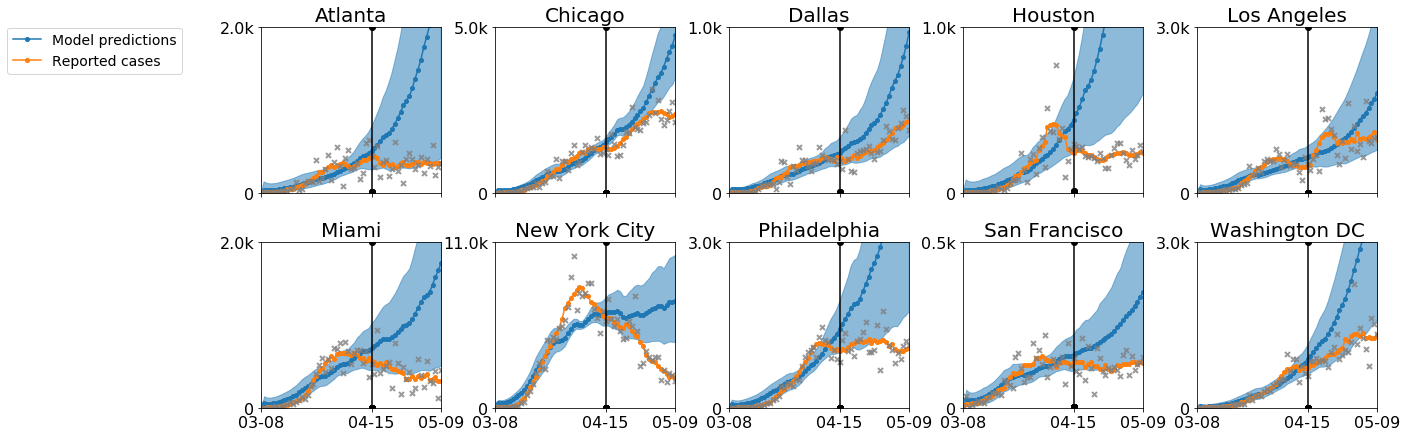

In [14]:
# aggregate mobility model
y_maxes = [2000, 5000, 1000, 1000, 3000, 2000, 11000, 3000, 500, 3000]
plot_best_models_fit_for_all_msas(agg_gridsearch_df, 'agg_mobility', TRAIN_TEST_PARTITION, 'train_loss_dict_daily_cases_RMSE', 
                                  'cases', plot_daily_not_cumulative=True, save_fig=False, y_maxes=y_maxes)

trajectory_2x5_grid_cases_oos_fit_ablation
Found 7 best fit models within threshold for Atlanta
Found 2 best fit models within threshold for Chicago
Found 3 best fit models within threshold for Dallas
Found 6 best fit models within threshold for Houston
Found 2 best fit models within threshold for Los Angeles
Found 3 best fit models within threshold for Miami
Found 2 best fit models within threshold for New York City
Found 3 best fit models within threshold for Philadelphia
Found 4 best fit models within threshold for San Francisco
Found 5 best fit models within threshold for Washington DC


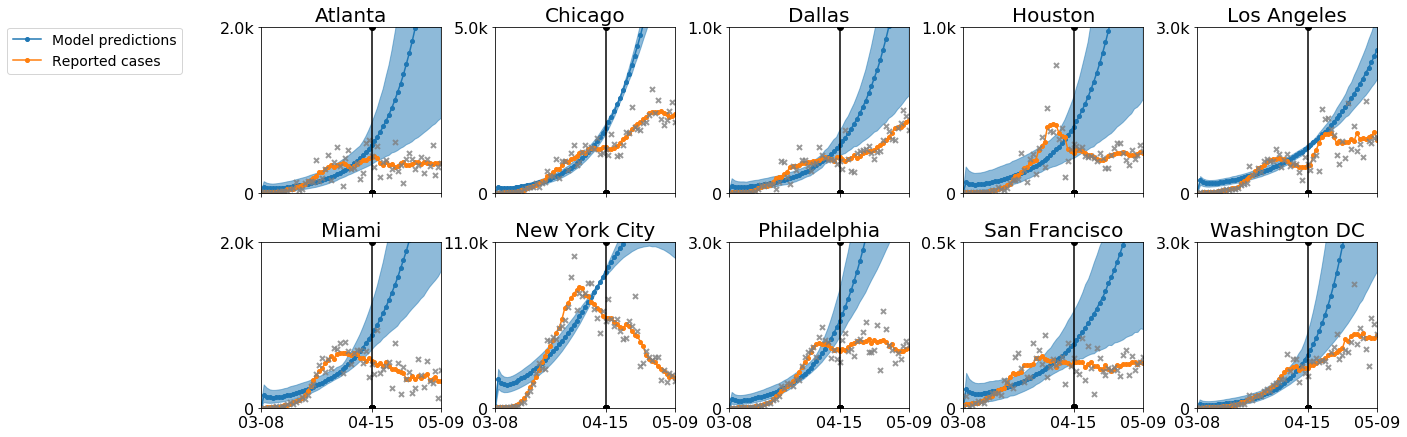

In [15]:
# model without mobility, aka ablation
y_maxes = [2000, 5000, 1000, 1000, 3000, 2000, 11000, 3000, 500, 3000]
plot_best_models_fit_for_all_msas(ablation_df, 'ablation', TRAIN_TEST_PARTITION, 'train_loss_dict_daily_cases_RMSE', 
                                  'cases', plot_daily_not_cumulative=True, save_fig=False, y_maxes=y_maxes)

Atlanta_Sandy_Springs_Roswell_GA
Found 27 best fit models within threshold for Atlanta
Chicago_Naperville_Elgin_IL_IN_WI
Found 12 best fit models within threshold for Chicago
Dallas_Fort_Worth_Arlington_TX
Found 23 best fit models within threshold for Dallas
Houston_The_Woodlands_Sugar_Land_TX
Found 16 best fit models within threshold for Houston
Los_Angeles_Long_Beach_Anaheim_CA
Found 12 best fit models within threshold for Los Angeles
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Found 20 best fit models within threshold for Miami
New_York_Newark_Jersey_City_NY_NJ_PA
Found 31 best fit models within threshold for New York City
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Found 45 best fit models within threshold for Philadelphia
San_Francisco_Oakland_Hayward_CA
Found 44 best fit models within threshold for San Francisco
Washington_Arlington_Alexandria_DC_VA_MD_WV
Found 21 best fit models within threshold for Washington DC


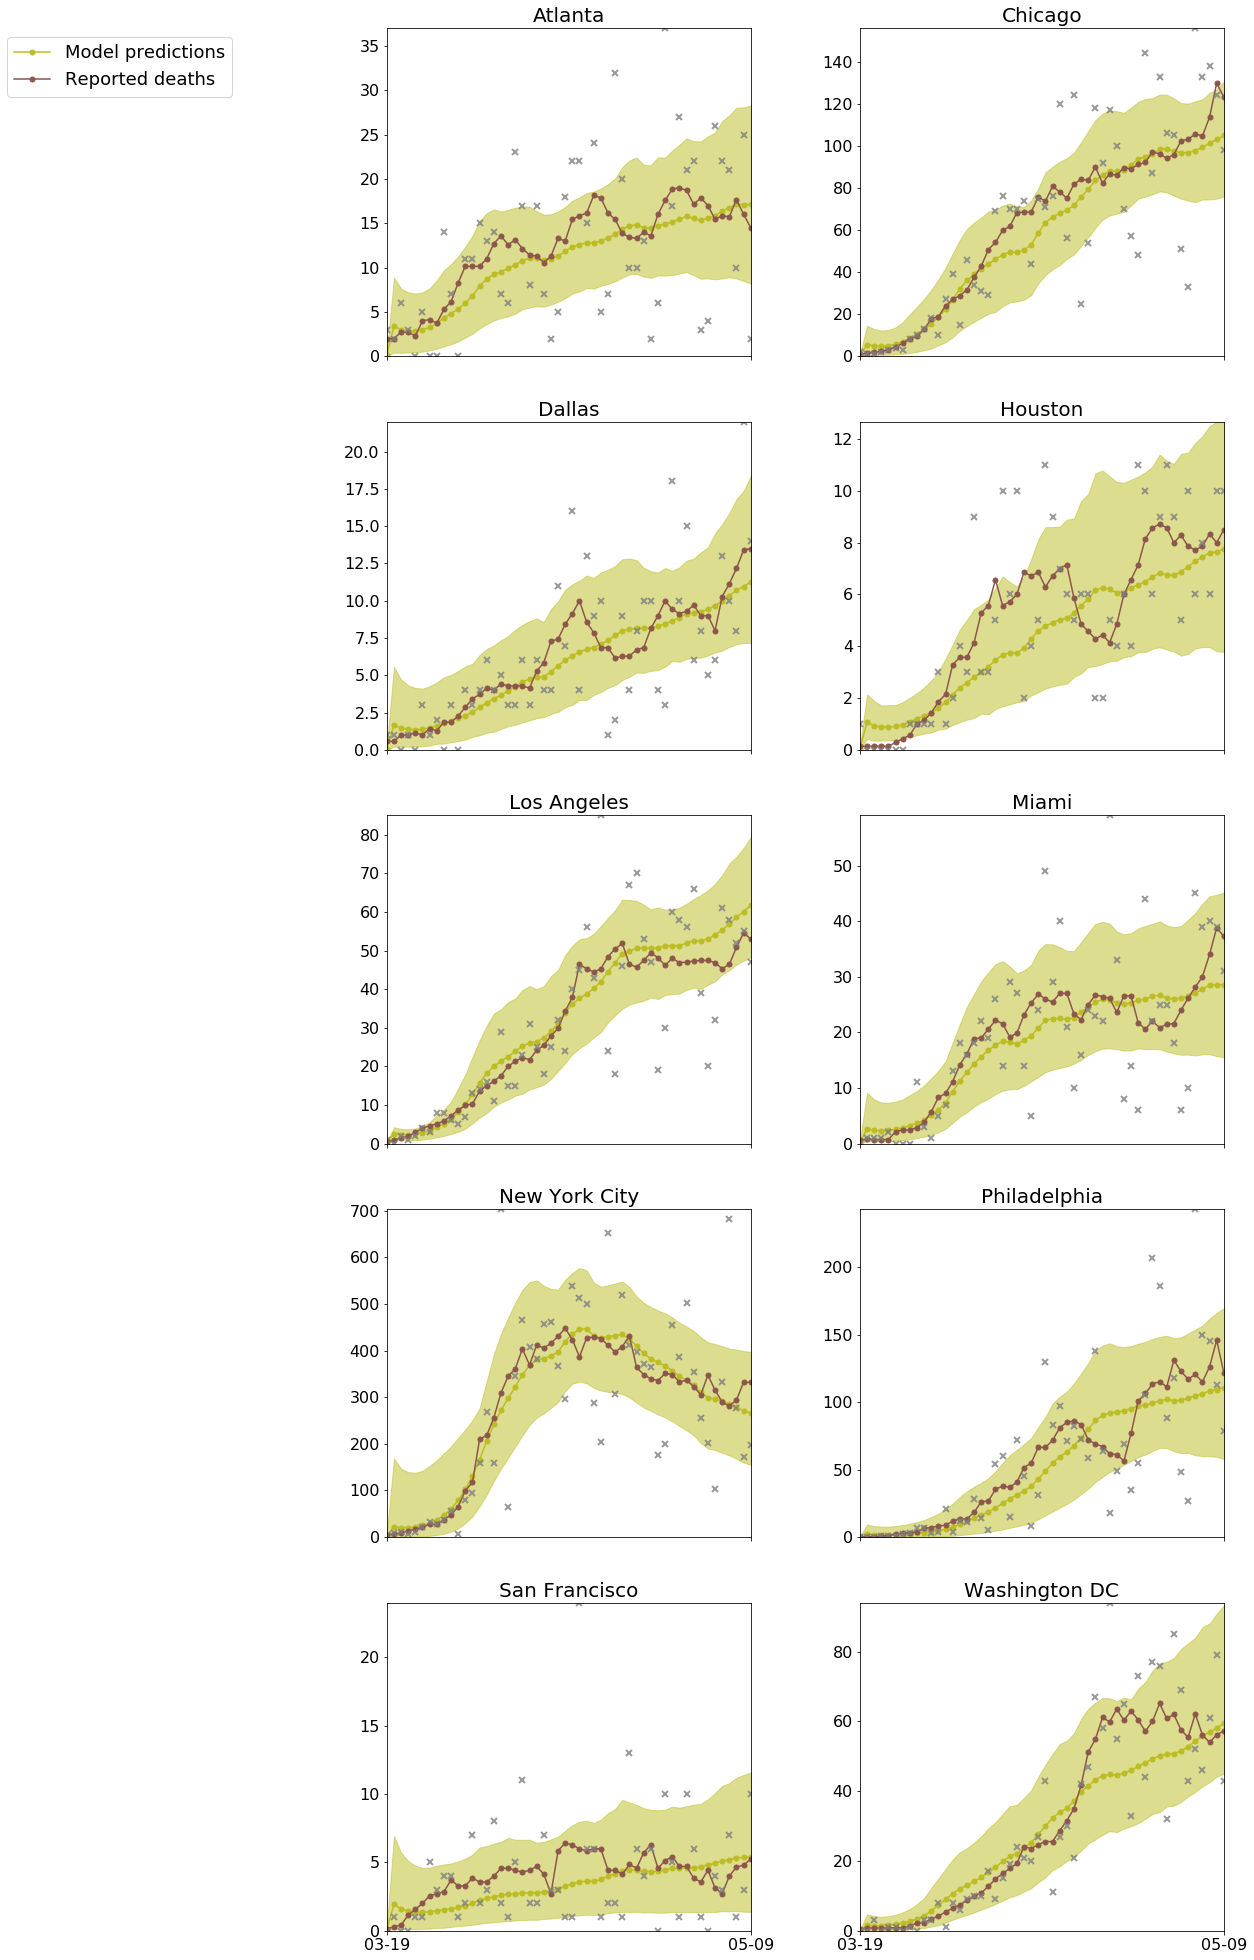

In [16]:
# fit to daily deaths
fig, axes = plt.subplots(5, 2, figsize=[15, 35], sharex=True)
fig.subplots_adjust(wspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
df, df_str = non_ablation_df, 'non_ablation'
thing_to_plot, plot_daily_not_cumulative = 'deaths', True
plot_legend = False
train_test_partition = None
key_to_sort_by = 'loss_dict_daily_deaths_RMSE'
for i, (msa, ax) in enumerate(zip(MSAS, axes)):
    print(msa)
    title = MSAS_TO_PRETTY_NAMES[msa]
    other_plotting_kwargs =  {
            'plot_log':False, 
            'plot_legend':plot_legend,
            'plot_errorbars':True,
            'xticks':[datetime.datetime(2020, 3, 19), 
                      datetime.datetime(2020, 5, 9)],                                                                             
            'x_range':[datetime.datetime(2020, 3, 19),
                       datetime.datetime(2020, 5, 9)],        
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
            'model_line_label': 'Model predictions',
            'true_line_label': 'Reported deaths',
            'title':title,
            'title_fontsize':20,
            'marker_size':5,
            'real_data_color':'tab:brown',
            'model_color':'tab:olive',
            'only_two_yticks':False,
            'plot_mode':thing_to_plot,
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
    }
    plot_best_models_fit_for_msa(df, msa, ax, key_to_sort_by, train_test_partition, 
                                 other_plotting_kwargs)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), fontsize=18)

## Supplement: calibrating grid search range by estimating R0

In [17]:
all_r0_results = []
min_r0_timestring='2020_07_10'
for msa in MSAS:
    all_r0_results.append(evaluate_all_fitted_models_for_msa(msa, 
                                                             min_timestring=min_r0_timestring, 
                                                             required_properties={'experiment_to_run':'calibrate_r0'},
                                                             key_to_sort_by=None))
r0_df = pd.concat(all_r0_results)
r0_df['MSA_name'] = r0_df['data_kwargs'].map(lambda x:x['MSA_name'])
assert len(r0_df) == 260, len(r0_df)
r0_df['R0'] = r0_df['estimated_R0_R0'].map(lambda x:x.mean())
r0_df['R0_base'] = r0_df['estimated_R0_R0_base'].map(lambda x:x.mean())
r0_df['R0_POI'] = r0_df['estimated_R0_R0_POI'].map(lambda x:x.mean())
assert np.allclose(r0_df['R0'], r0_df['R0_base'] + r0_df['R0_POI'])

Loading models with timestrings between 2020_07_10 and 2020_10_08_11_37_37_604055
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 26 fitted models for Atlanta_Sandy_Springs_Roswell_GA
Time to load and score all models: 1.087s -> 0.042s per model
Loading models with timestrings between 2020_07_10 and 2020_10_08_11_39_27_347610
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 26 fitted models for Chicago_Naperville_Elgin_IL_IN_WI
Time to load and score all models: 1.189s -> 0.046s per model
Loading models with timestrings between 2020_07_10 and 2020_10_08_11_39_57_413941
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 26 fitted models for Dallas_Fort_Worth_Arlington_TX
Time to load and score all models: 1.186s -> 0.046s per model
Loading models with timestrings between 2020_07_10 and 2020_10_08_11_40_19_125407
99399 files in directo

In [18]:
# reviewer question: how much variation across seeds. 

r0_df['R0_base_std_across_seeds'] = r0_df['estimated_R0_R0_base'].map(np.std)
r0_df['R0_POI_std_across_seeds'] = r0_df['estimated_R0_R0_POI'].map(np.std)

# filter for experiments we actually use. 

r0_df_to_use = r0_df.loc[(r0_df['poi_psi'] >= 500) & (r0_df['poi_psi'] <= 5000)].copy()
print(r0_df_to_use[['R0_base_std_across_seeds', 'R0_POI_std_across_seeds']].describe())


poi_range_across_cities = r0_df_to_use[['R0_POI', 'poi_psi']].groupby('poi_psi').agg(['min', 'max']).reset_index()
poi_range_across_cities.columns = ['poi_psi', 'min', 'max']

poi_range_across_cities['range'] = poi_range_across_cities['max'] - poi_range_across_cities['min']
print("Range in R_POI across cities")
print(poi_range_across_cities)
print("Aggregate stats about range")
print(poi_range_across_cities['range'].describe())

       R0_base_std_across_seeds  R0_POI_std_across_seeds
count                190.000000               190.000000
mean                   0.021468                 0.131093
std                    0.035335                 0.063676
min                    0.000000                 0.019976
25%                    0.007047                 0.087261
50%                    0.010410                 0.118529
75%                    0.012875                 0.168458
max                    0.203518                 0.367482
Range in R_POI across cities
   poi_psi       min       max     range
0      500  0.307390  0.978344  0.670954
1     1000  0.610649  1.981697  1.371049
2     1500  0.916325  2.933129  2.016804
3     2000  1.218791  3.932159  2.713368
4     2500  1.491213  4.900178  3.408965
5     3000  1.862433  5.875046  4.012614
6     3500  2.129408  6.851556  4.722148
7     4000  2.445150  7.784103  5.338953
8     4500  2.717199  8.763034  6.045835
9     5000  3.008952  9.695218  6.686266
Aggrega

R0_base lies in plausible range (0.10000-2.00000) for home_beta 0.00120-0.02396
    poi_psi       min       mean        max  n_models_fit
0       100  0.061318   0.089591   0.198000            10
1       250  0.148292   0.224010   0.488227            10
2       500  0.307390   0.443685   0.978344            10
3      1000  0.610649   0.891590   1.981697            10
4      1500  0.916325   1.332236   2.933129            10
5      2000  1.218791   1.772149   3.932159            10
6      2500  1.491213   2.229226   4.900178           100
7      3000  1.862433   2.681215   5.875046            10
8      3500  2.129408   3.124726   6.851556            10
9      4000  2.445150   3.561207   7.784103            10
10     4500  2.717199   3.991165   8.763034            10
11     5000  3.008952   4.441060   9.695218            10
12     6000  3.717316   5.334923  11.635333            10
13     7500  4.577455   6.675238  14.628326            10
14    10000  6.011597   8.871962  19.586977       

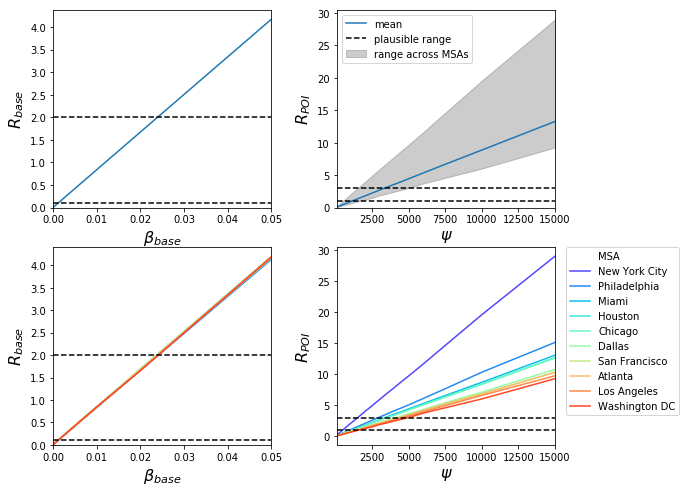

In [19]:
plausible_param_ranges = make_param_plausibility_plot(r0_df)
print(json.dumps(plausible_param_ranges))

# Set-up code for analyzing experimental results

In [20]:
## Run either this cell (to generate the characteristics) or the cell below (to load a saved version, for speed)
# compute and save relevant characteristics for later analysis
poi_and_cbg_characteristics = {}
for msa_name in MSAS:
    df = helper.load_dataframe_for_individual_msa(MSA_name=msa_name)
    data_kwargs = {'MSA_name':msa_name}
    model_kwargs = {'min_datetime':MIN_DATETIME,
                    'max_datetime':MAX_DATETIME,
                    'exogenous_model_kwargs': {
                        'home_beta':1e-2,
                        'poi_psi':1000,
                        'p_sick_at_t0':1e-4,
                        'just_compute_r0':False},
                    'poi_attributes_to_clip':{
                        'clip_areas':True,
                        'clip_dwell_times':True,
                        'clip_visits':True},
                    'correct_poi_visits':True,
                    'return_model_and_data_without_fitting':True}
    # modify fit_ane_save_one_model temporarily to return these things
    m = fit_and_save_one_model(None, model_kwargs, data_kwargs, d=df)
    poi_and_cbg_characteristics[msa_name] = {'poi_categories':m.POI_SUBCATEGORY_TYPES,
                                  'poi_areas':m.POI_AREAS,
                                  'poi_dwell_times':m.d['avg_median_dwell'].values,
                                  'poi_dwell_time_correction_factors':m.DWELL_TIME_CORRECTION_FACTORS,
                                  'cbg_idx_groups_to_track':m.cbg_idx_groups_to_track,
                                  'cbg_sizes':m.CBG_SIZES}
f = open(PATH_TO_SAVED_CHARACTERISTICS, 'wb')
pickle.dump(poi_and_cbg_characteristics, f)
f.close()

Loaded 68281 rows for Atlanta_Sandy_Springs_Roswell_GA in 39.903 seconds
Fitting single model. Timestring is none so not saving model and just returning fitted model.
Reloading POI visits from /dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Atlanta_Sandy_Springs_Roswell_GA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
1. Processing SafeGraph data...
Found 1512 hours in all (2020.3.1.0 to 2020.5.2.23) -> 22714075 hourly visits
Aggregating median_dwell from 2020-03-01.median_dwell to 2020-04-26.median_dwell
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be clipping hourly visits in dataframe
Clipping areas: True (below=5, above=95), clipping dwell times: True (above=90), clipping visits: False (above=95)


/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 93 sub-categories with >= 100 POIs and 42 top categories with >= 50 POIs -> covers 67242 POIs
Could not cover 1039/68281 POIs (1.5% POIs, 1.3% hourly visits) -> dropping these POIs
Administration of Economic Programs -> has 72 POIs, processed 72 POIs
Amusement Parks and Arcades -> has 65 POIs, processed 65 POIs
Automotive Parts, Accessories, and Tire Stores -> has 1380 POIs, processed 52 POIs
Automotive Repair and Maintenance -> has 2663 POIs, processed 258 POIs
Beverage Manufacturing -> has 120 POIs, processed 120 POIs
Building Material and Supplies Dealers -> has 1409 POIs, processed 25 POIs
Clothing Stores -> has 1454 POIs, processed 117 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 88 POIs, processed 88 POIs
Consumer Goods Rental -> has 91 POIs, processed 91 POIs
Depository Credit Intermediation -> has 1469 POIs, processed 4 POIs
Drycleaning and Laundry Services -> has 83 POIs, processed 83 POIs
Electronics and Appliance Stores -> has 556 PO

After clipping, 67242 POIs
After dropping for missing hourly visits, 47268 POIs
After dropping for missing CBG home data, 39432 POIs
After dropping for missing avg_median_dwell, 39432 POIs
After dropping CBGs that appear in < 10 POIs, 3130 CBGs (43.5%)
Dropped 21 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 3130, number of POIs (M) = 39411
Num connected POI-CBG pairs (E) = 815991, network density (E/N) = 260.700
2597 CBGs in nyt -> matched 2583 (0.995)
Dwell time correction factors: mean = 0.12, min = 0.00, max = 0.74
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1990, sum of population sizes = 7455619
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor coun

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 105 sub-categories with >= 100 POIs and 48 top categories with >= 50 POIs -> covers 107393 POIs
Could not cover 1163/108556 POIs (1.1% POIs, 0.8% hourly visits) -> dropping these POIs
Activities Related to Credit Intermediation -> has 71 POIs, processed 71 POIs
Amusement Parks and Arcades -> has 120 POIs, processed 11 POIs
Automotive Parts, Accessories, and Tire Stores -> has 1666 POIs, processed 36 POIs
Automotive Repair and Maintenance -> has 4055 POIs, processed 210 POIs
Beverage Manufacturing -> has 256 POIs, processed 51 POIs
Building Equipment Contractors -> has 133 POIs, processed 2 POIs
Building Material and Supplies Dealers -> has 2089 POIs, processed 33 POIs
Clothing Stores -> has 2170 POIs, processed 172 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 64 POIs, processed 64 POIs
Consumer Goods Rental -> has 129 POIs, processed 21 POIs
Death Care Services -> has 74 POIs, processed 74 POIs
Depository Credit Intermediation -> has 2205 POIs,

After clipping, 107393 POIs
After dropping for missing hourly visits, 73875 POIs
After dropping for missing CBG home data, 62468 POIs
After dropping for missing avg_median_dwell, 62468 POIs
After dropping CBGs that appear in < 10 POIs, 6812 CBGs (62.9%)
Dropped 48 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 6812, number of POIs (M) = 62420
Num connected POI-CBG pairs (E) = 896138, network density (E/N) = 131.553
6590 CBGs in nyt -> matched 6535 (0.992)
Dwell time correction factors: mean = 0.15, min = 0.01, max = 0.84
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1295, sum of population sizes = 10169539
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor co

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 102 sub-categories with >= 100 POIs and 42 top categories with >= 50 POIs -> covers 88228 POIs
Could not cover 1743/89971 POIs (1.9% POIs, 1.3% hourly visits) -> dropping these POIs
Activities Related to Credit Intermediation -> has 52 POIs, processed 52 POIs
Administration of Economic Programs -> has 56 POIs, processed 56 POIs
Amusement Parks and Arcades -> has 89 POIs, processed 89 POIs
Automotive Parts, Accessories, and Tire Stores -> has 1606 POIs, processed 17 POIs
Automotive Repair and Maintenance -> has 3600 POIs, processed 216 POIs
Beverage Manufacturing -> has 139 POIs, processed 139 POIs
Building Material and Supplies Dealers -> has 1925 POIs, processed 29 POIs
Clothing Stores -> has 1747 POIs, processed 166 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 105 POIs, processed 105 POIs
Consumer Goods Rental -> has 121 POIs, processed 121 POIs
Death Care Services -> has 54 POIs, processed 54 POIs
Depository Credit Intermediation -> has 2150

After clipping, 88228 POIs
After dropping for missing hourly visits, 63916 POIs
After dropping for missing CBG home data, 53025 POIs
After dropping for missing avg_median_dwell, 53025 POIs
After dropping CBGs that appear in < 10 POIs, 4877 CBGs (47.6%)
Dropped 26 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 4877, number of POIs (M) = 52999
Num connected POI-CBG pairs (E) = 1145021, network density (E/N) = 234.780
4158 CBGs in nyt -> matched 4148 (0.998)
Dwell time correction factors: mean = 0.13, min = 0.01, max = 0.74
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1519, sum of population sizes = 9353561
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor cou

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 103 sub-categories with >= 100 POIs and 37 top categories with >= 50 POIs -> covers 78449 POIs
Could not cover 1483/79932 POIs (1.9% POIs, 1.5% hourly visits) -> dropping these POIs
Amusement Parks and Arcades -> has 62 POIs, processed 62 POIs
Automotive Parts, Accessories, and Tire Stores -> has 1646 POIs, processed 26 POIs
Automotive Repair and Maintenance -> has 3336 POIs, processed 210 POIs
Beverage Manufacturing -> has 99 POIs, processed 99 POIs
Building Material and Supplies Dealers -> has 1955 POIs, processed 29 POIs
Clothing Stores -> has 1566 POIs, processed 143 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 127 POIs, processed 16 POIs
Consumer Goods Rental -> has 103 POIs, processed 103 POIs
Death Care Services -> has 57 POIs, processed 57 POIs
Electronics and Appliance Stores -> has 792 POIs, processed 10 POIs
Hardware, and Plumbing and Heating Equipment and Supplies Merchant Wholesalers -> has 61 POIs, processed 61 POIs
Health and Per

After clipping, 78449 POIs
After dropping for missing hourly visits, 57082 POIs
After dropping for missing CBG home data, 49641 POIs
After dropping for missing avg_median_dwell, 49641 POIs
After dropping CBGs that appear in < 10 POIs, 3345 CBGs (46.8%)
Dropped 19 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 3345, number of POIs (M) = 49622
Num connected POI-CBG pairs (E) = 934033, network density (E/N) = 279.233
3021 CBGs in nyt -> matched 3010 (0.996)
Dwell time correction factors: mean = 0.13, min = 0.01, max = 0.77
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1768, sum of population sizes = 7621541
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor coun

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 126 sub-categories with >= 100 POIs and 46 top categories with >= 50 POIs -> covers 170031 POIs
Could not cover 2055/172086 POIs (1.2% POIs, 0.6% hourly visits) -> dropping these POIs
Activities Related to Credit Intermediation -> has 59 POIs, processed 59 POIs
Administration of Economic Programs -> has 88 POIs, processed 88 POIs
Amusement Parks and Arcades -> has 153 POIs, processed 11 POIs
Automotive Parts, Accessories, and Tire Stores -> has 3018 POIs, processed 76 POIs
Automotive Repair and Maintenance -> has 5958 POIs, processed 149 POIs
Beverage Manufacturing -> has 272 POIs, processed 78 POIs
Building Material and Supplies Dealers -> has 3332 POIs, processed 34 POIs
Clothing Stores -> has 4675 POIs, processed 201 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 78 POIs, processed 78 POIs
Consumer Goods Rental -> has 259 POIs, processed 37 POIs
Death Care Services -> has 151 POIs, processed 1 POIs
Depository Credit Intermediation -> has 2335 

After clipping, 170031 POIs
After dropping for missing hourly visits, 106443 POIs
After dropping for missing CBG home data, 84111 POIs
After dropping for missing avg_median_dwell, 84111 POIs
After dropping CBGs that appear in < 10 POIs, 8904 CBGs (57.8%)
Dropped 157 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 8904, number of POIs (M) = 83954
Num connected POI-CBG pairs (E) = 1106542, network density (E/N) = 124.275
8248 CBGs in nyt -> matched 8133 (0.986)
Dwell time correction factors: mean = 0.15, min = 0.01, max = 0.83
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1501, sum of population sizes = 16101274
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 100 sub-categories with >= 100 POIs and 42 top categories with >= 50 POIs -> covers 74559 POIs
Could not cover 1424/75983 POIs (1.9% POIs, 1.4% hourly visits) -> dropping these POIs
Administration of Economic Programs -> has 67 POIs, processed 67 POIs
Amusement Parks and Arcades -> has 94 POIs, processed 94 POIs
Automotive Equipment Rental and Leasing -> has 336 POIs, processed 98 POIs
Automotive Parts, Accessories, and Tire Stores -> has 1373 POIs, processed 66 POIs
Automotive Repair and Maintenance -> has 2101 POIs, processed 169 POIs
Beverage Manufacturing -> has 132 POIs, processed 132 POIs
Building Material and Supplies Dealers -> has 1651 POIs, processed 14 POIs
Clothing Stores -> has 1997 POIs, processed 122 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 66 POIs, processed 66 POIs
Consumer Goods Rental -> has 140 POIs, processed 20 POIs
Depository Credit Intermediation -> has 1689 POIs, processed 6 POIs
Electronics and Appliance Stores -> 

After clipping, 74559 POIs
After dropping for missing hourly visits, 49486 POIs
After dropping for missing CBG home data, 40989 POIs
After dropping for missing avg_median_dwell, 40989 POIs
After dropping CBGs that appear in < 10 POIs, 3555 CBGs (54.4%)
Dropped 25 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 3555, number of POIs (M) = 40964
Num connected POI-CBG pairs (E) = 738685, network density (E/N) = 207.788
3420 CBGs in nyt -> matched 3378 (0.988)
Dwell time correction factors: mean = 0.14, min = 0.01, max = 0.81
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1607, sum of population sizes = 6833129
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor coun

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Precomputed POI-CBG networks (IPF output) were passed in; will NOT be clipping hourly visits in dataframe
Clipping areas: True (below=5, above=95), clipping dwell times: True (above=90), clipping visits: False (above=95)
Found 119 sub-categories with >= 100 POIs and 44 top categories with >= 50 POIs -> covers 218239 POIs
Could not cover 1643/219882 POIs (0.7% POIs, 0.5% hourly visits) -> dropping these POIs
Administration of Economic Programs -> has 86 POIs, processed 86 POIs
Amusement Parks and Arcades -> has 200 POIs, processed 18 POIs
Automotive Parts, Accessories, and Tire Stores -> has 2148 POIs, processed 12 POIs
Automotive Repair and Maintenance -> has 5872 POIs, processed 150 POIs
Building Material and Supplies Dealers -> has 3410 POIs, processed 39 POIs
Clothing Stores -> has 5409 POIs, processed 74 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 77 POIs, processed 77 POIs
Consumer Goods Rental -> has 163 POIs, processed 14 POIs
Depository Cred

Travel Agencies -> has 116 POIs, processed 116 POIs
Truck, Utility Trailer, and RV (Recreational Vehicle) Rental and Leasing -> has 191 POIs, processed 191 POIs
Used Car Dealers -> has 1763 POIs, processed 1763 POIs
Used Merchandise Stores -> has 2000 POIs, processed 2000 POIs
Veterinary Services -> has 753 POIs, processed 753 POIs
Video Tape and Disc Rental -> has 149 POIs, processed 149 POIs
Wineries -> has 146 POIs, processed 146 POIs
Wireless Telecommunications Carriers (except Satellite) -> has 1565 POIs, processed 1565 POIs
Women's Clothing Stores -> has 2893 POIs, processed 2893 POIs
After clipping, 218239 POIs
After dropping for missing hourly visits, 139388 POIs
After dropping for missing CBG home data, 122557 POIs
After dropping for missing avg_median_dwell, 122557 POIs
After dropping CBGs that appear in < 10 POIs, 14763 CBGs (72.2%)
Dropped 129 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 14763, number of POIs (M) = 122428
Num connected POI-CBG 

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 90 sub-categories with >= 100 POIs and 47 top categories with >= 50 POIs -> covers 70002 POIs
Could not cover 1026/71028 POIs (1.4% POIs, 1.3% hourly visits) -> dropping these POIs
Administration of Economic Programs -> has 92 POIs, processed 92 POIs
Amusement Parks and Arcades -> has 65 POIs, processed 65 POIs
Automotive Equipment Rental and Leasing -> has 238 POIs, processed 89 POIs
Automotive Parts, Accessories, and Tire Stores -> has 1006 POIs, processed 45 POIs
Automotive Repair and Maintenance -> has 2827 POIs, processed 129 POIs
Beverage Manufacturing -> has 221 POIs, processed 66 POIs
Building Equipment Contractors -> has 70 POIs, processed 70 POIs
Building Material and Supplies Dealers -> has 1273 POIs, processed 30 POIs
Clothing Stores -> has 1357 POIs, processed 106 POIs
Consumer Goods Rental -> has 67 POIs, processed 67 POIs
Depository Credit Intermediation -> has 1401 POIs, processed 7 POIs
Drycleaning and Laundry Services -> has 89 POIs, processed 89 POIs
Electric P

After clipping, 70002 POIs
After dropping for missing hourly visits, 45056 POIs
After dropping for missing CBG home data, 37996 POIs
After dropping for missing avg_median_dwell, 37996 POIs
After dropping CBGs that appear in < 10 POIs, 4565 CBGs (57.6%)
Dropped 45 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 4565, number of POIs (M) = 37951
Num connected POI-CBG pairs (E) = 511978, network density (E/N) = 112.153
4306 CBGs in nyt -> matched 4262 (0.990)
Dwell time correction factors: mean = 0.15, min = 0.01, max = 0.70
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1276, sum of population sizes = 6759058
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor coun

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 100 sub-categories with >= 100 POIs and 35 top categories with >= 50 POIs -> covers 62669 POIs
Could not cover 948/63617 POIs (1.5% POIs, 1.8% hourly visits) -> dropping these POIs
Amusement Parks and Arcades -> has 83 POIs, processed 83 POIs
Automotive Equipment Rental and Leasing -> has 193 POIs, processed 66 POIs
Automotive Parts, Accessories, and Tire Stores -> has 667 POIs, processed 33 POIs
Automotive Repair and Maintenance -> has 1560 POIs, processed 119 POIs
Building Material and Supplies Dealers -> has 1215 POIs, processed 10 POIs
Clothing Stores -> has 1287 POIs, processed 178 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 63 POIs, processed 63 POIs
Consumer Goods Rental -> has 69 POIs, processed 69 POIs
Death Care Services -> has 78 POIs, processed 78 POIs
Electronics and Appliance Stores -> has 658 POIs, processed 9 POIs
Health and Personal Care Stores -> has 1960 POIs, processed 23 POIs
Home Furnishings Stores -> has 379 POIs, proces

After clipping, 62669 POIs
After dropping for missing hourly visits, 35731 POIs
After dropping for missing CBG home data, 28820 POIs
After dropping for missing avg_median_dwell, 28820 POIs
After dropping CBGs that appear in < 10 POIs, 2943 CBGs (57.4%)
Dropped 107 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 2943, number of POIs (M) = 28713
Num connected POI-CBG pairs (E) = 310041, network density (E/N) = 105.349
2903 CBGs in nyt -> matched 2793 (0.962)
Dwell time correction factors: mean = 0.15, min = 0.01, max = 0.82
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1508, sum of population sizes = 5137800
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor cou

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 98 sub-categories with >= 100 POIs and 43 top categories with >= 50 POIs -> covers 67180 POIs
Could not cover 1120/68300 POIs (1.6% POIs, 1.2% hourly visits) -> dropping these POIs
Administration of Economic Programs -> has 73 POIs, processed 73 POIs
Amusement Parks and Arcades -> has 61 POIs, processed 61 POIs
Automotive Equipment Rental and Leasing -> has 193 POIs, processed 72 POIs
Automotive Parts, Accessories, and Tire Stores -> has 820 POIs, processed 26 POIs
Automotive Repair and Maintenance -> has 1857 POIs, processed 116 POIs
Beverage Manufacturing -> has 252 POIs, processed 1 POIs
Building Material and Supplies Dealers -> has 1212 POIs, processed 42 POIs
Clothing Stores -> has 1234 POIs, processed 217 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 71 POIs, processed 71 POIs
Consumer Goods Rental -> has 71 POIs, processed 71 POIs
Depository Credit Intermediation -> has 1512 POIs, processed 11 POIs
Electronics and Appliance Stores -> has 

After clipping, 67180 POIs
After dropping for missing hourly visits, 41639 POIs
After dropping for missing CBG home data, 34333 POIs
After dropping for missing avg_median_dwell, 34333 POIs
After dropping CBGs that appear in < 10 POIs, 4051 CBGs (40.9%)
Dropped 37 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 4051, number of POIs (M) = 34296
Num connected POI-CBG pairs (E) = 517019, network density (E/N) = 127.627
3570 CBGs in nyt -> matched 3530 (0.989)
Dwell time correction factors: mean = 0.15, min = 0.01, max = 0.76
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1631, sum of population sizes = 7740276
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor coun

PermissionError: [Errno 13] Permission denied: '/dfs/scratch1/safegraph_homes/all_aggregate_data/poi_and_cbg_characteristics.pkl'

In [17]:
# reloads poi_and_cbg_characteristics
f = open(PATH_TO_SAVED_CHARACTERISTICS, 'rb')
poi_and_cbg_characteristics = pickle.load(f)
f.close()
print(poi_and_cbg_characteristics.keys())
print(poi_and_cbg_characteristics[HIGHLIGHT_MSA].keys())

dict_keys(['Atlanta_Sandy_Springs_Roswell_GA', 'Chicago_Naperville_Elgin_IL_IN_WI', 'Dallas_Fort_Worth_Arlington_TX', 'Houston_The_Woodlands_Sugar_Land_TX', 'Los_Angeles_Long_Beach_Anaheim_CA', 'Miami_Fort_Lauderdale_West_Palm_Beach_FL', 'New_York_Newark_Jersey_City_NY_NJ_PA', 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD', 'San_Francisco_Oakland_Hayward_CA', 'Washington_Arlington_Alexandria_DC_VA_MD_WV'])
dict_keys(['poi_categories', 'poi_areas', 'poi_dwell_times', 'poi_dwell_time_correction_factors', 'cbg_idx_groups_to_track', 'cbg_sizes'])


In [18]:
# add IPF output(i.e., hourly POI-CBG networks) to characteristics
for msa_name in MSAS:
    print(msa_name)
    fn = get_ipf_filename(msa_name, MIN_DATETIME, MAX_DATETIME, True, True)
    print(fn)
    f = open(fn, 'rb')
    poi_cbg_visits_list = pickle.load(f)
    f.close()
    poi_and_cbg_characteristics[msa_name]['poi_cbg_visits_list'] = poi_cbg_visits_list

Atlanta_Sandy_Springs_Roswell_GA
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Atlanta_Sandy_Springs_Roswell_GA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Chicago_Naperville_Elgin_IL_IN_WI
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Dallas_Fort_Worth_Arlington_TX
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Dallas_Fort_Worth_Arlington_TX_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Houston_The_Woodlands_Sugar_Land_TX
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Houston_The_Woodlands_Sugar_Land_TX_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Los_Angeles_Long_Beach_Anaheim_CA
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Los_Angeles_Long_Beach_Anaheim_CA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Miami_Fort_Lauderdale_West_Palm_Be

In [19]:
top_categories = get_list_of_poi_subcategories_with_most_visits(n_poi_categories=20)
pretty_top_categories = [SUBCATEGORIES_TO_PRETTY_NAMES[cat] for cat in top_categories]

Reading chunk 0 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 0 in 22.705 seconds
Reading chunk 1 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 1 in 24.435 seconds
Reading chunk 2 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 2 in 83.401 seconds
Reading chunk 3 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 3 in 24.950 seconds
Reading chunk 4 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annota

# Mobility reductions + reopening analysis

## Figure 2a: counterfactual results for highlighted MSA

In [2]:
# load models
min_timestring = '2020_07_22'
counterfactual_df = evaluate_all_fitted_models_for_experiment('test_retrospective_counterfactuals', 
                                                               min_timestring=min_timestring)
counterfactual_df['MSA_name'] = counterfactual_df['data_kwargs'].map(lambda x:x['MSA_name'])
for k in ['distancing_degree', 'shift_in_days']:
    counterfactual_df['counterfactual_%s' % k] = counterfactual_df['counterfactual_retrospective_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
counterfactual_df['counterfactual_baseline_model'] = counterfactual_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
counterfactual_df['how_to_select_best_grid_search_models'] = counterfactual_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])
assert (counterfactual_df['poi_psi'] > 0).all()

counterfactual_df_cases = counterfactual_df.loc[counterfactual_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
counterfactual_df_deaths = counterfactual_df.loc[counterfactual_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
print('Found %d models for selecting with cases, found %d for selecting with deaths' % 
       (len(counterfactual_df_cases), len(counterfactual_df_deaths)))


Loading models with timestrings between 2020_07_22 and 2020_10_20_18_58_28_875859
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 3200 fitted models for test_retrospective_counterfactuals
Loaded 1 models so far: 0.005s -> 0.005s per model
Loaded 1001 models so far: 3.052s -> 0.003s per model
Loaded 2001 models so far: 6.177s -> 0.003s per model
Loaded 3001 models so far: 9.004s -> 0.003s per model
Time to load and score all models: 9.547s -> 0.003s per model
Found 776 models for selecting with cases, found 2008 for selecting with deaths


Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120


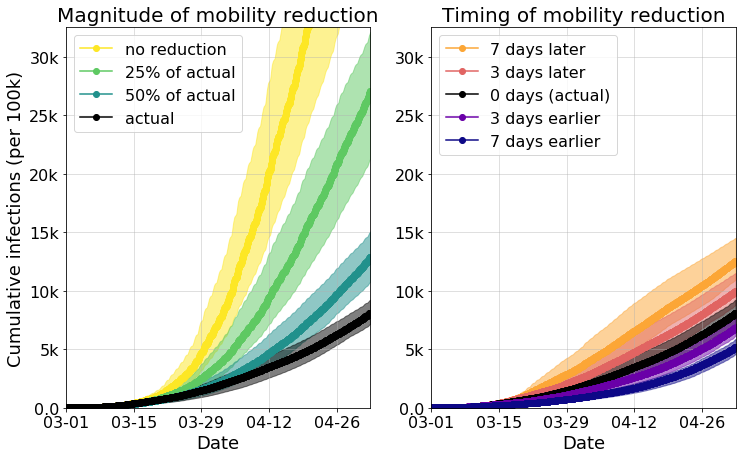

In [4]:
# Figure 2a, middle + right
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
degree_means, degree_colors = make_counterfactual_line_plots(counterfactual_df_cases, HIGHLIGHT_MSA, axes[0], 'degree')
y_max = degree_means[1][-1] * 1.2
axes[0].set_ylim(0, y_max)
shift_means, shift_colors = make_counterfactual_line_plots(counterfactual_df_cases, HIGHLIGHT_MSA, axes[1], 'shift', 
                                                           cmap_str='plasma', y_lim=(0, y_max))
axes[1].set_ylabel('')
plt.savefig('covid_figures_for_paper/%s_mobility_reduction.pdf' % HIGHLIGHT_MSA, dpi=400, bbox_inches='tight')
plt.show()

In [53]:
fn = get_ipf_filename(HIGHLIGHT_MSA, MIN_DATETIME, MAX_DATETIME, True, True)
print(fn)
f = open(fn, 'rb')
poi_cbg_visits_list = pickle.load(f)
f.close()

/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl


In [54]:
# how much did mobility drop btwn first weeks of March and April?
model_hours = helper.list_hours_in_range(MIN_DATETIME, MAX_DATETIME)

mar_week_start = model_hours.index(datetime.datetime(2020, 3, 1, 0))
mar_week_end = model_hours.index(datetime.datetime(2020, 3, 8, 0))
mar_total = 0
for i in range(mar_week_start, mar_week_end):
    mar_total += poi_cbg_visits_list[i].sum()

apr_week_start = model_hours.index(datetime.datetime(2020, 4, 1, 0))
apr_week_end = model_hours.index(datetime.datetime(2020, 4, 8, 0))
apr_total = 0
for j in range(apr_week_start, apr_week_end):
    apr_total += poi_cbg_visits_list[j].sum()

print('Total num visits in first week of March:', mar_total)
print('Total num visits in first week of April:', apr_total)
print('Percent change:', (mar_total - apr_total) / mar_total)

Total num visits in first week of March: 44528903.22909312
Total num visits in first week of April: 20161543.22588036
Percent change: 0.5472256946874959


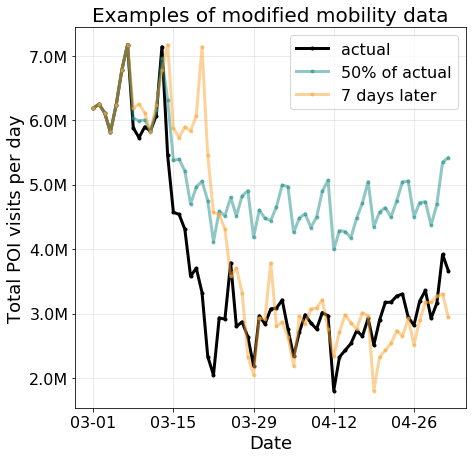

In [63]:
# Figure 2a, left - need to do this after middle and right plots, bc it uses the colors from those plots
lesser_extent = apply_distancing_degree(poi_cbg_visits_list, 0.5)
shifted = apply_shift_in_days(poi_cbg_visits_list, 7)
colors = ['black', degree_colors[2], shift_colors[0]]
fig, ax = plt.subplots(figsize=(7, 7))
make_schematic(poi_cbg_visits_list, lesser_extent, shifted, colors, ax)
plt.savefig('covid_figures_for_paper/%s_mobility_reduction_schematic.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')

## Supplement: counterfactual results for all MSAs

In [29]:
all_ratios = []
cols = None
for msa in MSAS:
    print(msa)
    cols, ratios = get_counterfactual_ratios_at_datetime(counterfactual_df_cases, msa)
    ratios_as_str = []
    for (m, (l,u)) in ratios:
        ratios_as_str.append('%s (%s, %s)' % (m, l, u))
    ratios_as_str.insert(0, MSAS_TO_PRETTY_NAMES[msa])
    all_ratios.append(ratios_as_str)
cols.insert(0, 'MSA_name')
ratios_df = pd.DataFrame(all_ratios, columns=cols)
ratios_df

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


MSA_name         distancing_deg=0   distancing_deg=0.25    distancing_deg=0.5       shift_in_days=7       shift_in_days=3      shift_in_days=-3      shift_in_days=-7
0        Atlanta   16.593 (3.088, 30.532)  7.714 (1.73, 15.833)   2.265 (1.17, 3.673)  1.981 (1.189, 2.761)  1.359 (1.075, 1.741)  0.803 (0.639, 0.956)  0.586 (0.397, 0.834)
1        Chicago       6.202 (5.2, 7.088)  3.329 (2.761, 3.759)  1.587 (1.421, 1.704)  1.542 (1.446, 1.639)  1.226 (1.143, 1.365)  0.848 (0.769, 0.933)  0.641 (0.563, 0.711)
2         Dallas  18.026 (10.361, 27.273)   5.908 (3.75, 8.857)   1.87 (1.532, 2.349)  1.722 (1.487, 1.966)   1.298 (1.09, 1.577)  0.855 (0.693, 1.013)  0.642 (0.495, 0.782)
3        Houston  18.964 (11.949, 32.755)  5.725 (3.761, 9.233)  1.659 (1.362, 2.109)  1.731 (1.493, 2.064)  1.288 (1.079, 1.541)  0.848 (0.663, 1.021)    0.656 (0.5, 0.812)
4    Los Angeles    12.926 (3.15, 24.207)  5.097 (1.779, 9.721)  1.665 (1.176, 2.309)  1.692 (1.216, 2.137)  1.265 (1.041, 1.554)  0.816 (0.639, 0.984)  0.608 (0.407, 0.848)
5          Miami   10.781 (3.382, 15.935)   4.85 (1.886, 7.405)    1.777 (1.208, 2.3)   1.856 (1.281, 2.27)  1.317 (1.117, 1.559)  0.792 (0.669, 0.919)  0.576 (0.424, 0.795)
6  New York City     2.037 (1.902, 2.174)   1.73 (1.603, 1.811)  1.333 (1.258, 1.389)   1.27 (1.246, 1.307)  1.113 (1.094, 1.133)   0.909 (0.89, 0.927)  0.818 (0.795, 0.856)
7   Philadelphia      2.976 (2.734, 3.39)  1.894 (1.747, 2.137)  1.211 (1.141, 1.305)  1.287 (1.246, 1.351)   1.12 (1.031, 1.206)  0.916 (0.823, 1.005)  0.799 (0.731, 0.868)
8  San Francisco    9.743 (7.089, 15.596)  4.282 (3.124, 6.781)  1.714 (1.427, 2.255)  1.689 (1.452, 2.029)  1.271 (1.048, 1.527)  0.815 (0.666, 1.012)  0.609 (0.408, 0.798)
9  Washington DC      5.85 (2.329, 9.713)  3.032 (1.541, 4.646)  1.509 (1.132, 1.959)  1.488 (1.158, 1.789)  1.207 (0.959, 1.586)  0.848 (0.627, 1.045)  0.671 (0.447, 0.879)

In [30]:
cols = ['MSA_name', 'shift_in_days=-7', 'shift_in_days=-3', 'shift_in_days=3', 'shift_in_days=7']
ratios_df[cols].to_latex()

'\\begin{tabular}{llllll}\n\\toprule\n{} &       MSA\\_name &      shift\\_in\\_days=-7 &      shift\\_in\\_days=-3 &       shift\\_in\\_days=3 &       shift\\_in\\_days=7 \\\\\n\\midrule\n0 &        Atlanta &  0.586 (0.397, 0.834) &  0.803 (0.639, 0.956) &  1.359 (1.075, 1.741) &  1.981 (1.189, 2.761) \\\\\n1 &        Chicago &  0.641 (0.563, 0.711) &  0.848 (0.769, 0.933) &  1.226 (1.143, 1.365) &  1.542 (1.446, 1.639) \\\\\n2 &         Dallas &  0.642 (0.495, 0.782) &  0.855 (0.693, 1.013) &   1.298 (1.09, 1.577) &  1.722 (1.487, 1.966) \\\\\n3 &        Houston &    0.656 (0.5, 0.812) &  0.848 (0.663, 1.021) &  1.288 (1.079, 1.541) &  1.731 (1.493, 2.064) \\\\\n4 &    Los Angeles &  0.608 (0.407, 0.848) &  0.816 (0.639, 0.984) &  1.265 (1.041, 1.554) &  1.692 (1.216, 2.137) \\\\\n5 &          Miami &  0.576 (0.424, 0.795) &  0.792 (0.669, 0.919) &  1.317 (1.117, 1.559) &   1.856 (1.281, 2.27) \\\\\n6 &  New York City &  0.818 (0.795, 0.856) &   0.909 (0.89, 0.927) &  1.113 (1.094, 1

In [31]:
cols = ['MSA_name', 'distancing_deg=0', 'distancing_deg=0.25', 'distancing_deg=0.5']
ratios_df[cols].to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} &       MSA\\_name &         distancing\\_deg=0 &   distancing\\_deg=0.25 &    distancing\\_deg=0.5 \\\\\n\\midrule\n0 &        Atlanta &   16.593 (3.088, 30.532) &  7.714 (1.73, 15.833) &   2.265 (1.17, 3.673) \\\\\n1 &        Chicago &       6.202 (5.2, 7.088) &  3.329 (2.761, 3.759) &  1.587 (1.421, 1.704) \\\\\n2 &         Dallas &  18.026 (10.361, 27.273) &   5.908 (3.75, 8.857) &   1.87 (1.532, 2.349) \\\\\n3 &        Houston &  18.964 (11.949, 32.755) &  5.725 (3.761, 9.233) &  1.659 (1.362, 2.109) \\\\\n4 &    Los Angeles &    12.926 (3.15, 24.207) &  5.097 (1.779, 9.721) &  1.665 (1.176, 2.309) \\\\\n5 &          Miami &   10.781 (3.382, 15.935) &   4.85 (1.886, 7.405) &    1.777 (1.208, 2.3) \\\\\n6 &  New York City &     2.037 (1.902, 2.174) &   1.73 (1.603, 1.811) &  1.333 (1.258, 1.389) \\\\\n7 &   Philadelphia &      2.976 (2.734, 3.39) &  1.894 (1.747, 2.137) &  1.211 (1.141, 1.305) \\\\\n8 &  San Francisco &    9.743 (7.089, 15.59

## Figure 2b: super-spreader plot for highlighted MSA

In [5]:
min_timestring = '2020_07_22'
max_timestring = '2020_08_01'
superspreader_df = evaluate_all_fitted_models_for_experiment('rerun_best_models_and_save_cases_per_poi', 
                                                              min_timestring=min_timestring,
                                                              max_timestring=max_timestring)
superspreader_df['MSA_name'] = superspreader_df['data_kwargs'].map(lambda x:x['MSA_name'])
superspreader_df['original_timestring'] = superspreader_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
superspreader_df['how_to_select_best_grid_search_models'] = superspreader_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])

superspreader_df_cases = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
superspreader_df_deaths = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
superspreader_df_poisson = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_cases_poisson'].copy()

print('Found %d models for selecting with RMSE cases, %d for RMSE deaths, %d for Poisson cases' % 
       (len(superspreader_df_cases), len(superspreader_df_deaths), len(superspreader_df_poisson)))


Setting numpy cores to 1
Running code on rambo.stanford.edu; at Stanford=True
Loading models with timestrings between 2020_07_22 and 2020_08_01
99399 files in directory /dfs/scratch2/second_safegraph_homes/extra_safegraph_aggregate_models/data_and_model_configs
Found 400 fitted models for rerun_best_models_and_save_cases_per_poi
Loaded 1 models so far: 0.008s -> 0.008s per model
Time to load and score all models: 1.301s -> 0.003s per model
Found 97 models for selecting with RMSE cases, 251 for RMSE deaths, 52 for Poisson cases


In [6]:
superspreader_df_cases['rmse_ratio'] = superspreader_df_cases['model_kwargs'].map(lambda x:x['model_quality_dict']['ratio_of_loss_dict_daily_cases_RMSE_to_that_of_best_fitting_model'])
superspreader_df_cases_10 = superspreader_df_cases[superspreader_df_cases['rmse_ratio'] <= 1.10]
print('Found %d models for selecting with RMSE cases 10%% threshold' % len(superspreader_df_cases_10))

Found 45 models for selecting with RMSE cases 10% threshold


/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Spearman correlations (across POIs) between POI characteristics and fraction of total infections at POI
mean_frac_of_infections_at_poi     1.000000
density*dwell_time_factor          0.778464
visits^2*dwell_time_factor/area    0.879511
weighted_visits_over_area          0.514050
weighted_visits                    0.224283
dwell_time                         0.496902
Name: mean_frac_of_infections_at_poi, dtype: float64
infectiousness_group               bottom 90%    top 10%
mean_frac_of_infections_at_poi   7.535631e-07   0.000055
density*dwell_time_factor        8.678862e-05   0.001074
visits^2*dwell_time_factor/area  1.983717e-01   4.081145
weighted_visits_over_area        1.273242e-03   0.004108
weighted_visits                  9.284951e+00  10.708163
dwell_time                       2.300000e+01  81.000000


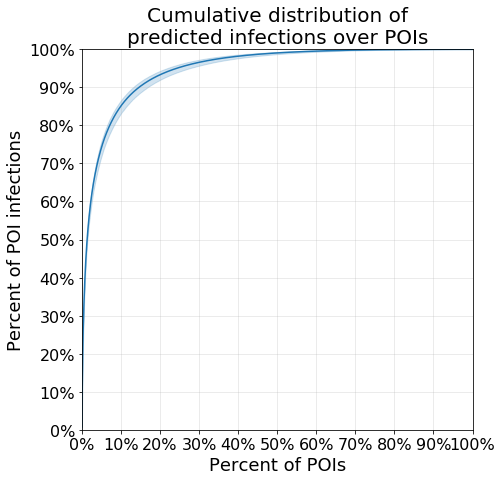

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
out = make_superspreader_plot_for_msa(superspreader_df_cases, HIGHLIGHT_MSA, ax, 
                                poi_and_cbg_characteristics=poi_and_cbg_characteristics)
plt.savefig('covid_figures_for_paper/%s_cdf.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')

In [21]:
print('top 10 / bottom 90 weighted_visits_over_area:', 0.004108 / 1.273242e-03)
print('top 10 / bottom 90 dwell_time:', 81.000000 / 2.300000e+01)

top 10 / bottom 90 weighted_visits_over_area: 3.2264094335562286
top 10 / bottom 90 dwell_time: 3.5217391304347827


In [22]:
# get mean and CI for 10% 
all_poi_fracs_for_city = out[1]
cumulative_poi_fracs = np.cumsum(all_poi_fracs_for_city, axis=1)
x = np.linspace(0, 1, cumulative_poi_fracs.shape[1])
lower_CI = np.percentile(cumulative_poi_fracs, LOWER_PERCENTILE, axis=0)
upper_CI = np.percentile(cumulative_poi_fracs, UPPER_PERCENTILE, axis=0)
y = np.mean(cumulative_poi_fracs, axis=0)

index = np.argmin(np.abs(x - 0.1))
indices = [index-1, index, index+1]
print('x', x[indices])
print('mean', y[indices])
print('lower', lower_CI[indices])
print('upper', upper_CI[indices])

x [0.09998558 0.1000016  0.10001762]
mean [0.85124669 0.85126936 0.85129202]
lower [0.83140651 0.83141254 0.8314342 ]
upper [0.86599221 0.86601499 0.86604302]


## Supplement: super-spreader plots for all MSAs, all model selection metrics

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


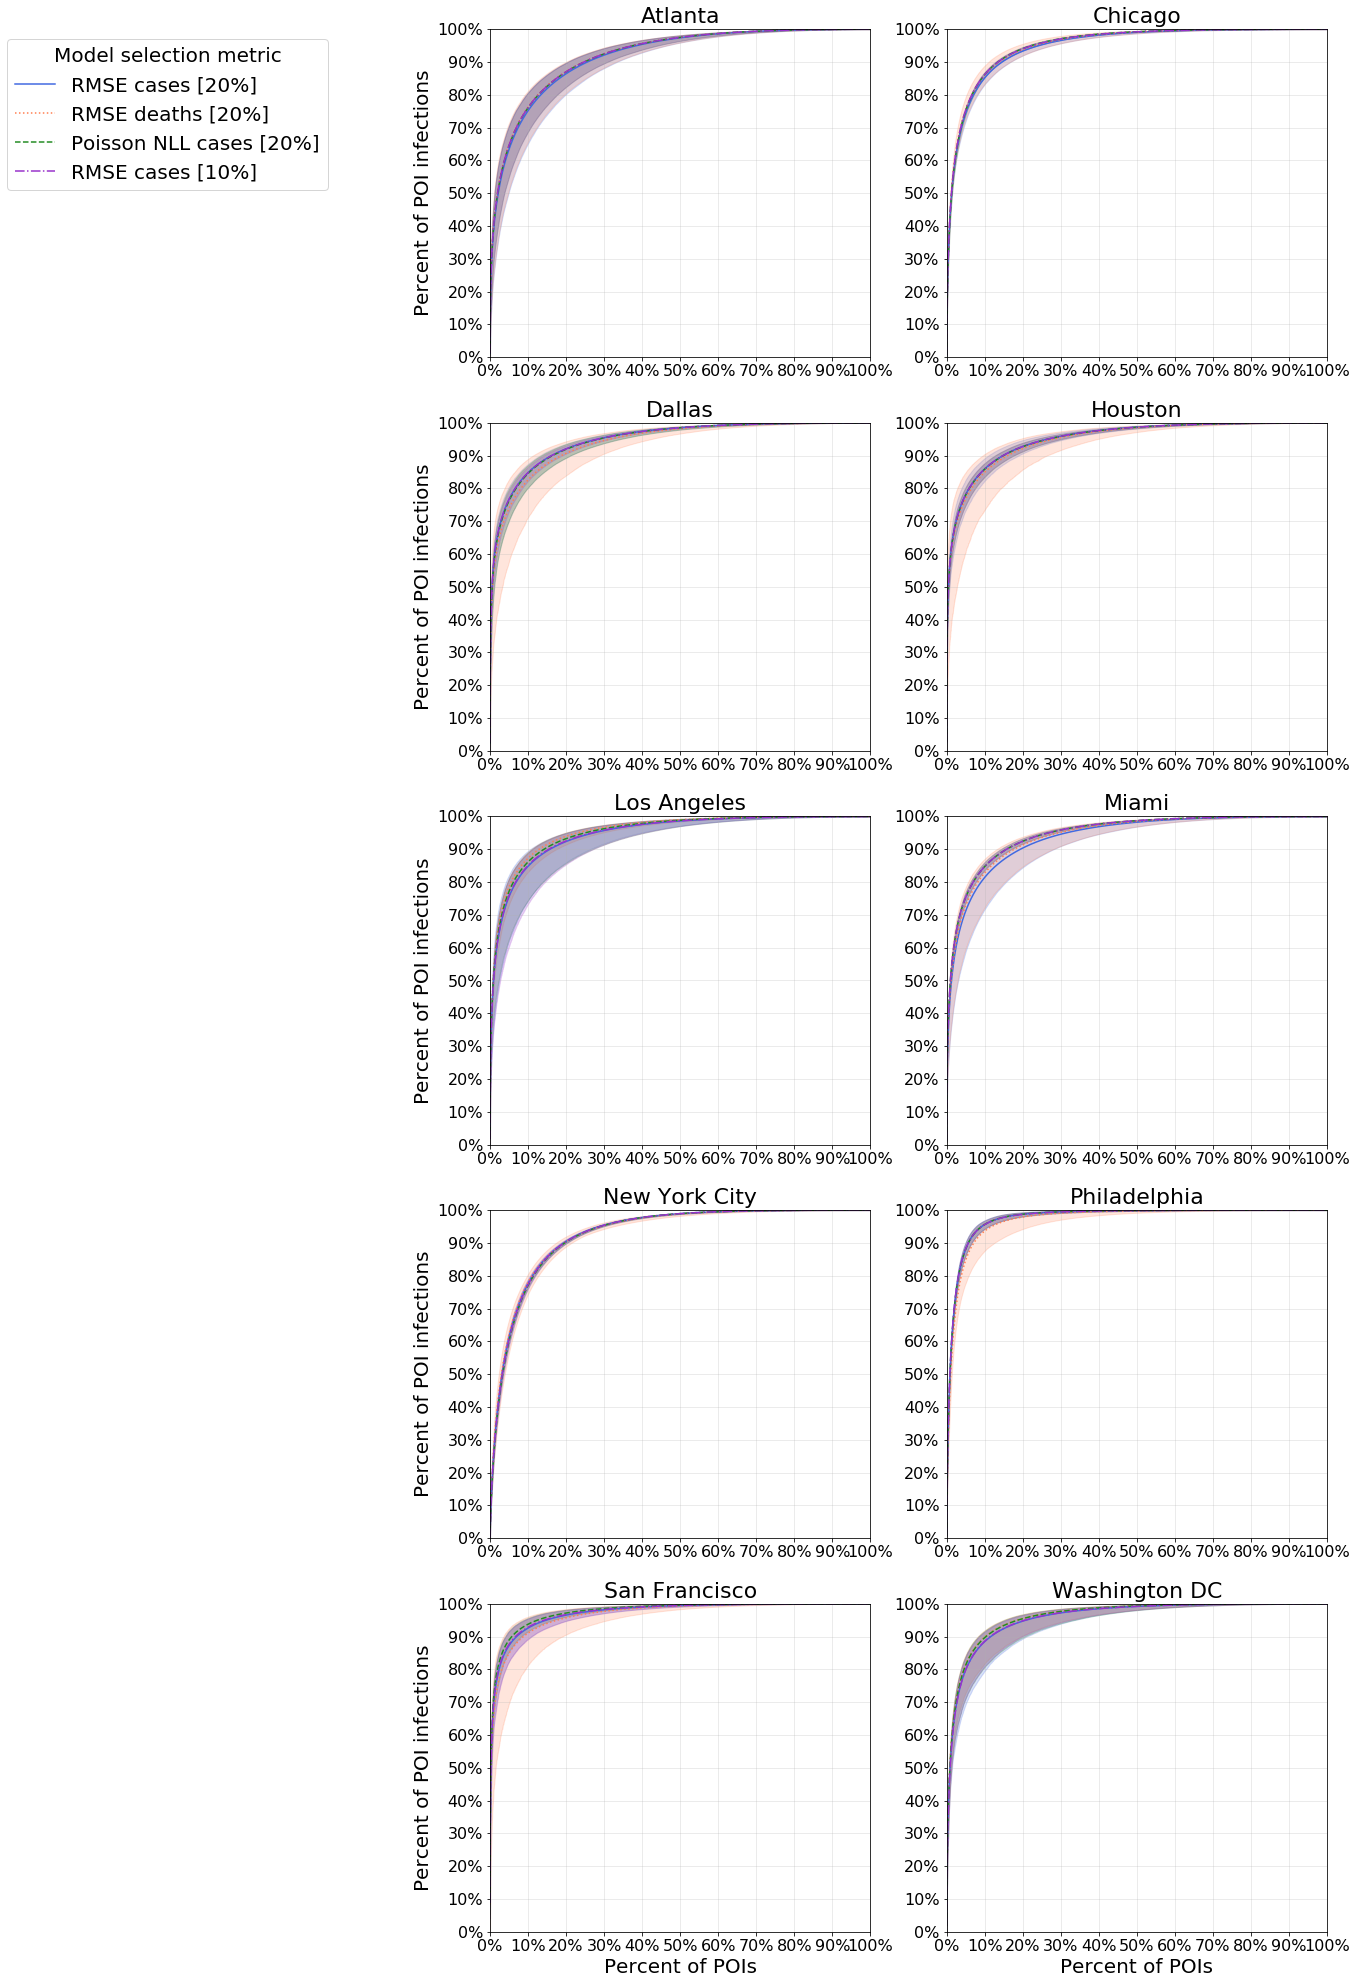

In [23]:
# all metrics
fig, axes = plt.subplots(5, 2, figsize=[15, 35])
axes = [ax for axes_row in axes for ax in axes_row]
all_proportions_of_total_infections_from_pois = []
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    prop_from_pois_df, _ = make_superspreader_plot_for_msa(superspreader_df_cases, msa, ax, set_labels=False, 
                                      line_label='RMSE cases [20%]', color='royalblue')
    all_proportions_of_total_infections_from_pois.append(prop_from_pois_df)
    out = make_superspreader_plot_for_msa(superspreader_df_deaths, msa, ax, set_labels=False, 
                                      color='coral', line_label='RMSE deaths [20%]', linestyle='dotted')
    out = make_superspreader_plot_for_msa(superspreader_df_poisson, msa, ax, set_labels=False,
                                      color='forestgreen', line_label='Poisson NLL cases [20%]', linestyle='dashed')
    out = make_superspreader_plot_for_msa(superspreader_df_cases_10, msa, ax, set_labels=False,
                                      color='darkorchid', line_label='RMSE cases [10%]', linestyle='dashdot')
    
    if msa_idx % 2 == 0:
        ax.set_ylabel("Percent of POI infections", fontsize=20)   
    if msa_idx >= 8:
        ax.set_xlabel("Percent of POIs", fontsize=20)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=22)
    if msa_idx == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), title='Model selection metric', fontsize=20, title_fontsize=20)

In [24]:
prop_infections_from_pois_to_plot = pd.concat(all_proportions_of_total_infections_from_pois)
print(prop_infections_from_pois_to_plot.groupby('msa').agg(['min', 'mean', 'median', 'max', 'size']))
print("\nOverall stats for medians of MSAs")
print(prop_infections_from_pois_to_plot.groupby('msa').agg('median').agg(['min', 'mean', 'median', 'max', 'size']))

                                            prop_total_infections_from_pois  \
                                                                        min   
msa                                                                           
Atlanta_Sandy_Springs_Roswell_GA                                   0.111430   
Chicago_Naperville_Elgin_IL_IN_WI                                  0.408003   
Dallas_Fort_Worth_Arlington_TX                                     0.363840   
Houston_The_Woodlands_Sugar_Land_TX                                0.472596   
Los_Angeles_Long_Beach_Anaheim_CA                                  0.106390   
Miami_Fort_Lauderdale_West_Palm_Beach_FL                           0.198974   
New_York_Newark_Jersey_City_NY_NJ_PA                               0.648472   
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD                         0.590170   
San_Francisco_Oakland_Hayward_CA                                   0.427995   
Washington_Arlington_Alexandria_DC_VA_MD_WV         

## Figure 2c: partial reopening results for highlighted MSA

In [66]:
# load partial reopening with reduced occupancy models
min_timestring = '2020_07_22'
max_cap_df = evaluate_all_fitted_models_for_experiment('test_max_capacity_clipping', 
                                                       min_timestring=min_timestring)
max_cap_df['MSA_name'] = max_cap_df['data_kwargs'].map(lambda x:x['MSA_name'])

k = 'max_capacity_alpha'
max_cap_df['counterfactual_%s' % k] = max_cap_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
# counterfactual_baseline_models are best-fit models to real data.
max_cap_df['counterfactual_baseline_model'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
max_cap_df['baseline_model_quality'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])
max_cap_df['how_to_select_best_grid_search_models'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])
max_cap_cases = max_cap_df.loc[max_cap_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
print('Found %d models for selecting with RMSE cases' % len(max_cap_cases))

extra_weeks_to_simulate = max_cap_df.iloc[0]['counterfactual_poi_opening_experiment_kwargs']['extra_weeks_to_simulate']
intervention_datetime = max_cap_df.iloc[0]['counterfactual_poi_opening_experiment_kwargs']['intervention_datetime']

Loading models with timestrings between 2020_07_22 and 2020_10_09_18_14_19_638529
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 5716 fitted models for test_max_capacity_clipping
Loaded 1 models so far: 0.008s -> 0.008s per model
Loaded 1001 models so far: 4.558s -> 0.005s per model
Loaded 2001 models so far: 8.801s -> 0.004s per model
Loaded 3001 models so far: 13.108s -> 0.004s per model
Loaded 4001 models so far: 17.221s -> 0.004s per model
Loaded 5001 models so far: 21.550s -> 0.004s per model
Time to load and score all models: 24.478s -> 0.004s per model
Found 970 models for selecting with RMSE cases


In [67]:
# load partial reopening with uniform reduction models
min_timestring = '2020_09_04'
uniform_df = evaluate_all_fitted_models_for_experiment('test_uniform_proportion_of_full_reopening', 
                                                       min_timestring=min_timestring)
uniform_df['MSA_name'] = uniform_df['data_kwargs'].map(lambda x:x['MSA_name'])
k = 'full_activity_alpha'
uniform_df['counterfactual_%s' % k] = uniform_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
uniform_df['counterfactual_baseline_model'] = uniform_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
uniform_df['baseline_model_quality'] = uniform_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])

Loading models with timestrings between 2020_09_04 and 2020_10_09_18_14_59_390296
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 970 fitted models for test_uniform_proportion_of_full_reopening
Loaded 1 models so far: 0.005s -> 0.005s per model
Time to load and score all models: 4.086s -> 0.004s per model


Num params * seeds: 120
Visits lost: [0.6635728796473398, 0.419164700164337, 0.2581554232757484, 0.15586810699022838, 0.09037350814386139, 0.050622170127604844, 0.026012676695889338, 0.011795055644529994, 0.003997263969516019, 1.5517091763533338e-16]
Visits kept: [0.33642712 0.5808353  0.74184458 0.84413189 0.90962649 0.94937783
 0.97398732 0.98820494 0.99600274 1.        ]
Infections: [10723.825255664653, 13871.1584336976, 18811.369178091554, 24196.371552994355, 29078.879255654232, 32901.88203221404, 35777.70388608569, 37724.216735225986, 38939.42406501088, 39655.43505298847]


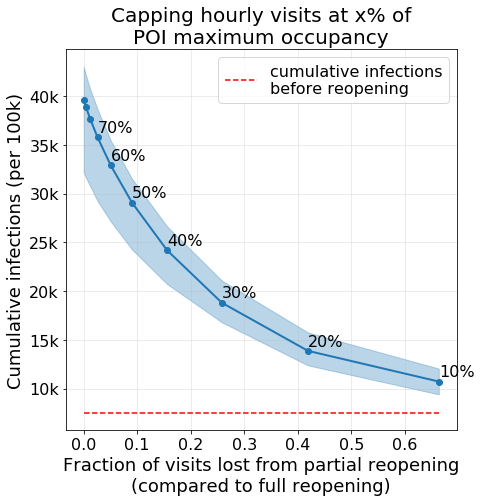

Found 40 rows for MSA in max cap and 40 rows for MSA in uniform
Comparing max_cap_alpha=0.10 to full_activity_alpha=0.3364
Num params * seeds: 120
Comparing max_cap_alpha=0.20 to full_activity_alpha=0.5808
Num params * seeds: 120
Comparing max_cap_alpha=0.30 to full_activity_alpha=0.7418
Num params * seeds: 120
Comparing max_cap_alpha=0.40 to full_activity_alpha=0.8441
Num params * seeds: 120
Comparing max_cap_alpha=0.50 to full_activity_alpha=0.9096
Num params * seeds: 120
Comparing max_cap_alpha=0.60 to full_activity_alpha=0.9494
Num params * seeds: 120
Comparing max_cap_alpha=0.70 to full_activity_alpha=0.9740
Num params * seeds: 120
Comparing max_cap_alpha=0.80 to full_activity_alpha=0.9882
Num params * seeds: 120
Comparing max_cap_alpha=0.90 to full_activity_alpha=0.9960
Num params * seeds: 120
Comparing max_cap_alpha=1.00 to full_activity_alpha=1.0000
Num params * seeds: 120
X [0.6635728796473398, 0.419164700164337, 0.2581554232757484, 0.15586810699022838, 0.09037350814386139, 0.

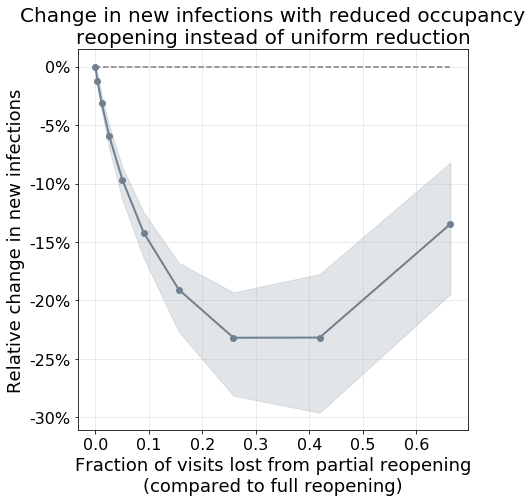

In [70]:
# number of visits after full reopening for a month
full_activity, intervention_idx = get_full_activity_num_visits(HIGHLIGHT_MSA, 
                                                               intervention_datetime=intervention_datetime,
                                                               extra_weeks_to_simulate=extra_weeks_to_simulate, 
                                                               min_datetime=MIN_DATETIME, 
                                                               max_datetime=MAX_DATETIME)

# Make figure 2c, left. 
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=False, 
                                           full_activity_num_visits=full_activity)
fig, ax = plt.subplots(figsize=(7, 7))
make_pareto_plot(X, Y_min, Y_mean, Y_max, ax, all_intervention_lir=all_intervention_lir, 
                 color='tab:blue', point_labels=vals, annotation_color='black')
print('Visits lost:', X)
print('Visits kept:', 1 - np.array(X))
print('Infections:', Y_mean)
x_lim = ax.get_xlim()
plt.savefig('covid_figures_for_paper/%s_reduced_occ_reopening.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')
plt.show()

# Make figure 2c, right. 
fig, ax = plt.subplots(figsize=(7, 7))
X, Y_mean, Y_lower, Y_upper = plot_pairwise_comparison(max_cap_cases, uniform_df, HIGHLIGHT_MSA, full_activity, 
                                                      intervention_idx, ax, x_lim=x_lim, mode='percent_change')
plt.savefig('covid_figures_for_paper/%s_reduced_vs_uniform.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')
plt.show()

## Figure 3f: disparities in partial reopening for highlighted MSA

Num params * seeds: 120
Overall X: [0.6635728796473398, 0.419164700164337, 0.2581554232757484, 0.15586810699022838, 0.09037350814386139, 0.050622170127604844, 0.026012676695889338, 0.011795055644529994, 0.003997263969516019, 1.5517091763533338e-16]
Overall Y lower: [1688.8100827382632, 4569.098953256386, 9794.963419679101, 13762.591893300178, 17271.374838131796, 20130.587286208352, 22203.47107179588, 23653.228037180445, 24626.428002291945, 25165.8499465905]
Overall Y means: [3202.3155949678085, 6348.444605011101, 11287.785431243901, 16672.329902728794, 21554.51892493193, 25377.409520071003, 28253.203431017544, 30199.652036013304, 31414.814050731966, 32130.80799434468]
Overall Y upper: [4552.281819264374, 8336.593477836113, 13785.670127229958, 19396.850978200684, 24293.463794179854, 28169.01213516168, 31088.679388515055, 32947.67737259279, 34390.19359677956, 35207.599135024706]
Num params * seeds: 120
Bottom decile Y lower: [3031.1037925544742, 7380.864593387752, 14151.629754190431, 189

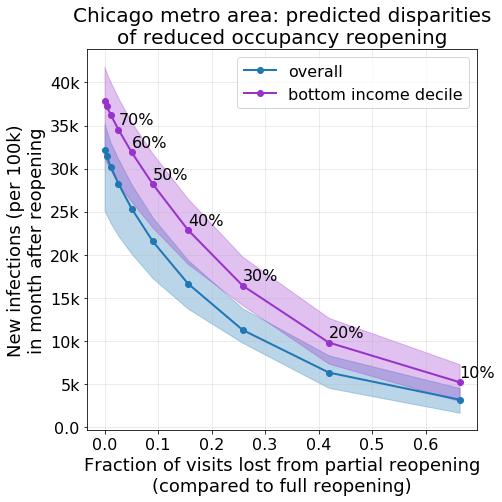

In [86]:
# we include Figure 3f here with Figure 2c bc they are both analyzing the impacts of the 
# clipping reopening strategy and they share code
fig, ax = plt.subplots(figsize=(7, 7))
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group='all')
make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                 color='tab:blue', set_axis_labels=False, line_label='overall')
print('Overall X:', X)
print('Overall Y lower:', Y_min)
print('Overall Y means:', Y_mean)
print('Overall Y upper:', Y_max)
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group=LOWINCOME)

make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                 color='darkorchid', point_labels=vals, annotation_color='black', line_label='bottom income decile')
print('Bottom decile Y lower:', Y_min)
print('Bottom decile Y means:', Y_mean)
print('Bottom decile Y upper:', Y_max)
ax.set_title('%s metro area: predicted disparities\nof reduced occupancy reopening' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA], fontsize=20)
plt.savefig('covid_figures_for_paper/%s_reduced_occ_reopening_disparity.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')

## Supplement: partial reopening results for all MSAs

In [45]:
# get activity from full reopening for each MSA
msa2full = {}
intervention_idx = -1  # index of intervention hour; same for every MSA
for msa in MSAS:
    full_activity, intervention_idx = get_full_activity_num_visits(msa, 
                                                               intervention_datetime=intervention_datetime,
                                                               extra_weeks_to_simulate=extra_weeks_to_simulate, 
                                                               min_datetime=MIN_DATETIME, 
                                                               max_datetime=MAX_DATETIME)
    print(msa, full_activity)
    msa2full[msa] = full_activity

Atlanta_Sandy_Springs_Roswell_GA 149785878.44773555
Chicago_Naperville_Elgin_IL_IN_WI 192061262.77949613
Dallas_Fort_Worth_Arlington_TX 204296644.87162408
Houston_The_Woodlands_Sugar_Land_TX 177458993.54327407
Los_Angeles_Long_Beach_Anaheim_CA 229259326.74204007
Miami_Fort_Lauderdale_West_Palm_Beach_FL 150942317.11317715
New_York_Newark_Jersey_City_NY_NJ_PA 410774418.0244213
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 112015008.08138107
San_Francisco_Oakland_Hayward_CA 67236166.12517726
Washington_Arlington_Alexandria_DC_VA_MD_WV 103699137.4777582


Atlanta_Sandy_Springs_Roswell_GA
Num params * seeds: 480
Num params * seeds: 480
Chicago_Naperville_Elgin_IL_IN_WI
Num params * seeds: 120
Num params * seeds: 120
Dallas_Fort_Worth_Arlington_TX
Num params * seeds: 150
Num params * seeds: 150
Houston_The_Woodlands_Sugar_Land_TX
Num params * seeds: 240
Num params * seeds: 240
Los_Angeles_Long_Beach_Anaheim_CA
Num params * seeds: 750
Num params * seeds: 750
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Num params * seeds: 210
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA
Num params * seeds: 210
Num params * seeds: 210
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Num params * seeds: 90
Num params * seeds: 90
San_Francisco_Oakland_Hayward_CA
Num params * seeds: 150
Num params * seeds: 150
Washington_Arlington_Alexandria_DC_VA_MD_WV
Num params * seeds: 510
Num params * seeds: 510


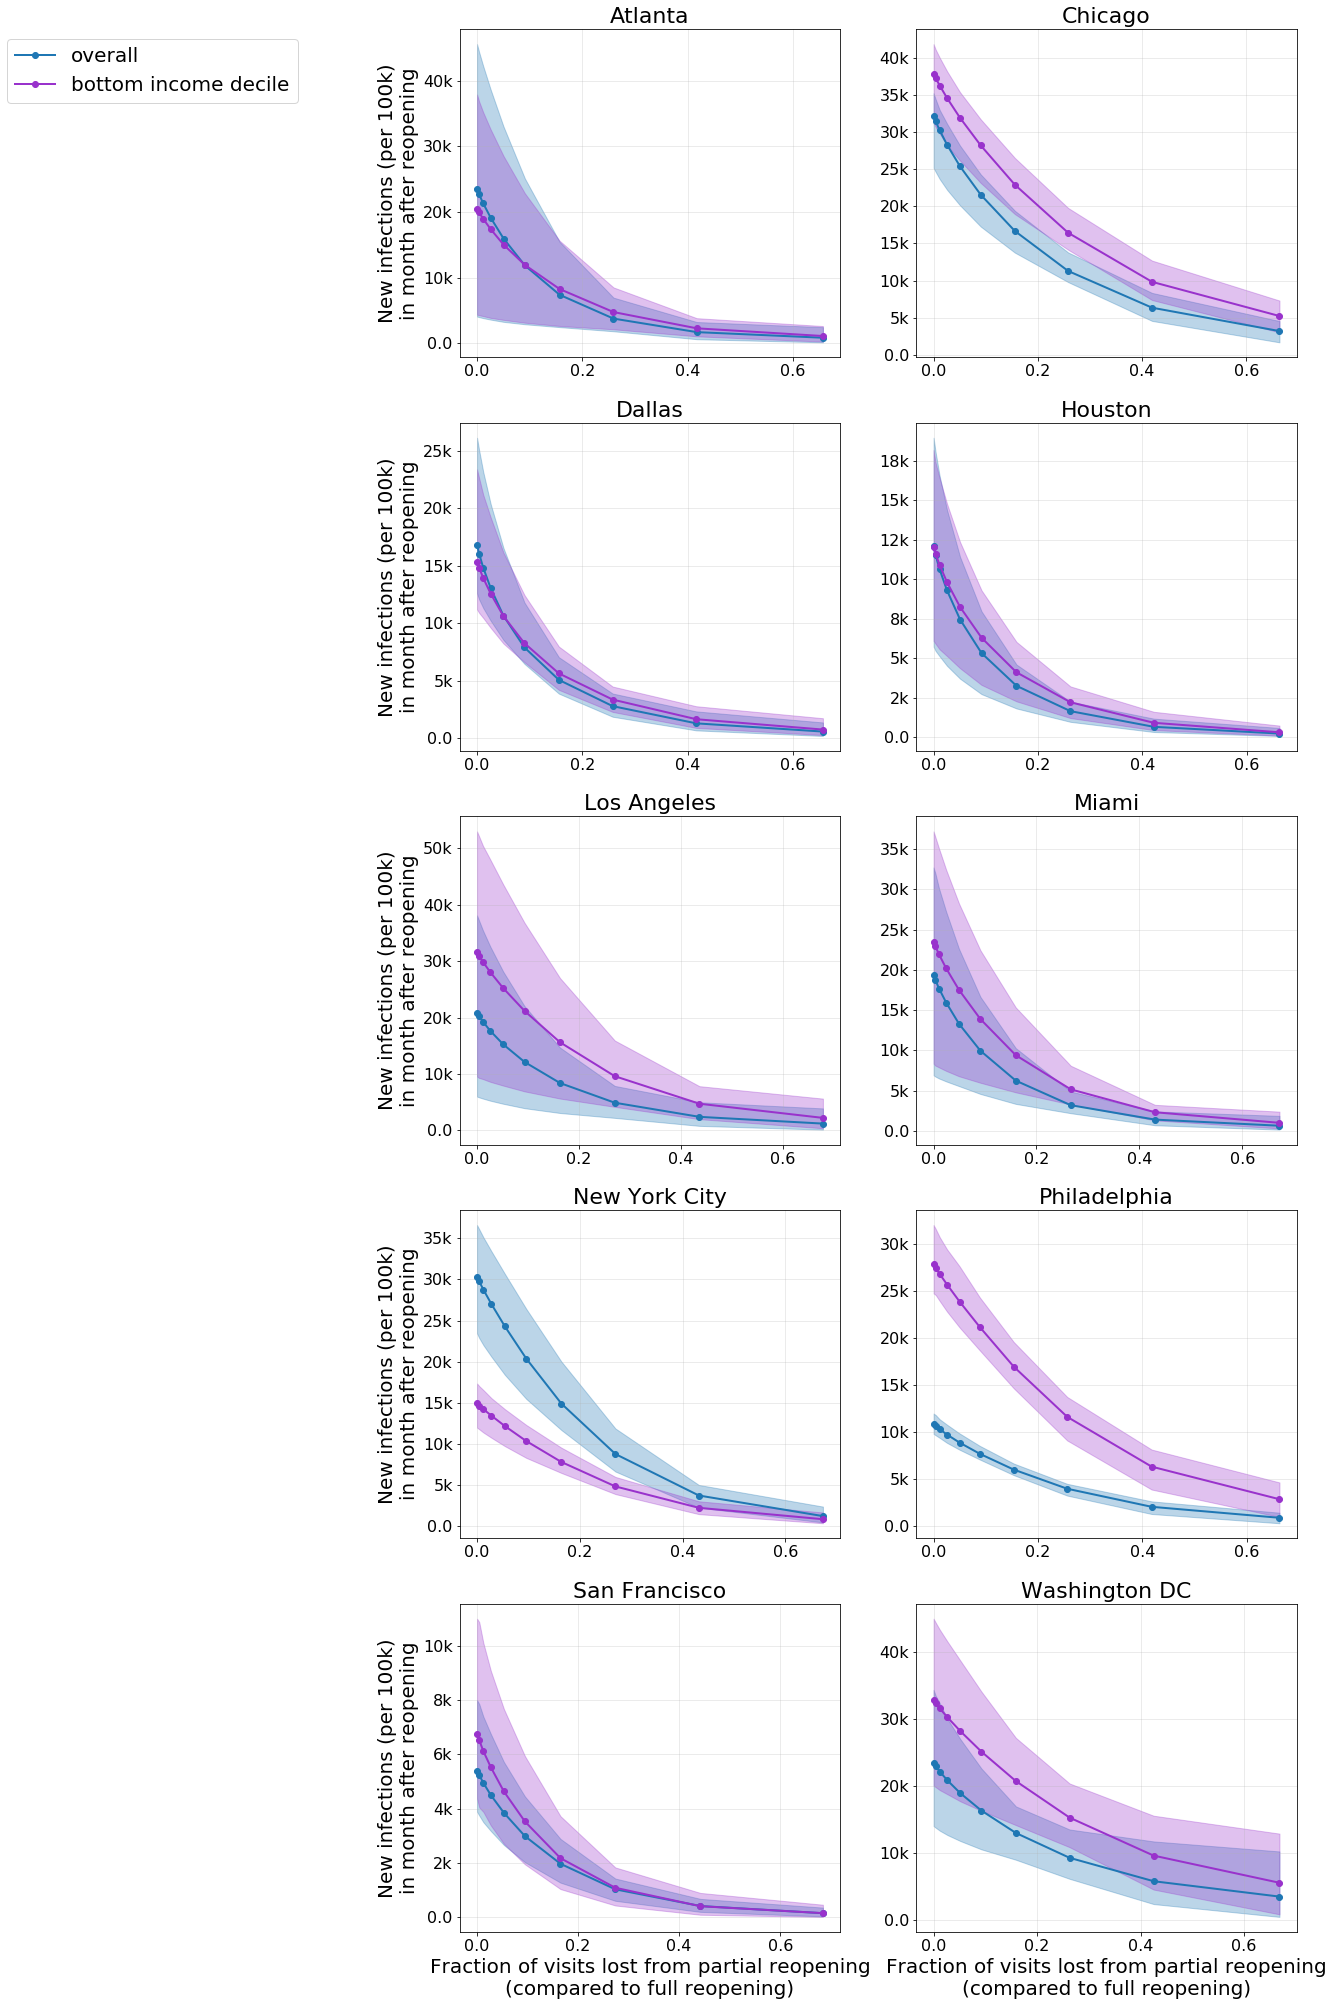

In [46]:
# reduced occupancy reopening, impact on overall vs bottom income decile
fig, axes = plt.subplots(5, 2, figsize=[15, 35])
axes = [ax for axes_row in axes for ax in axes_row]
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=msa2full[msa], cbg_group='all')
    make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                     color='tab:blue', set_axis_labels=False, line_label='overall')
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                               intervention_idx, get_diff_in_infections=True, 
                                               full_activity_num_visits=msa2full[msa], cbg_group=LOWINCOME)
    make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                     color='darkorchid', set_axis_labels=False, line_label='bottom income decile')

    if msa_idx % 2 == 0:
        ax.set_ylabel("New infections (per 100k)\nin month after reopening", fontsize=20)   
    if msa_idx >= 8:
        ax.set_xlabel("Fraction of visits lost from partial reopening\n(compared to full reopening)", fontsize=20)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=22)
    if msa_idx == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), fontsize=20)

In [47]:
# check if NYC is saturated for lower-income
for msa in MSAS:
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=False, 
                                           full_activity_num_visits=msa2full[msa], cbg_group=LOWINCOME)
    print(msa, np.percentile(all_intervention_lir, LOWER_PERCENTILE), np.mean(all_intervention_lir), np.percentile(all_intervention_lir, UPPER_PERCENTILE))

Num params * seeds: 480
Atlanta_Sandy_Springs_Roswell_GA 0.022739429807090428 0.0386483587184101 0.05555637861374302
Num params * seeds: 120
Chicago_Naperville_Elgin_IL_IN_WI 0.10966027529302393 0.13895207874368973 0.171728212333538
Num params * seeds: 150
Dallas_Fort_Worth_Arlington_TX 0.01582953435939876 0.024929895291445188 0.03452530421314121
Num params * seeds: 240
Houston_The_Woodlands_Sugar_Land_TX 0.013919622725974077 0.02339748693255884 0.034211977340265445
Num params * seeds: 750
Los_Angeles_Long_Beach_Anaheim_CA 0.02727811793545249 0.05298918708533928 0.07786965719844574
Num params * seeds: 210
Miami_Fort_Lauderdale_West_Palm_Beach_FL 0.04882510286275976 0.06364495664914076 0.08040779756260928
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA 0.6170596157703334 0.650604532821649 0.6806896421320903
Num params * seeds: 90
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 0.2773618302166454 0.308359545999066 0.3495314308338917
Num params * seeds: 150
San_Francisco_Oakland_H

Atlanta_Sandy_Springs_Roswell_GA
Found 160 rows for MSA in max cap and 160 rows for MSA in uniform
Comparing max_cap_alpha=0.10 to full_activity_alpha=0.3431
Num params * seeds: 480
Comparing max_cap_alpha=0.20 to full_activity_alpha=0.5826
Num params * seeds: 480
Comparing max_cap_alpha=0.30 to full_activity_alpha=0.7409
Num params * seeds: 480
Comparing max_cap_alpha=0.40 to full_activity_alpha=0.8431
Num params * seeds: 480
Comparing max_cap_alpha=0.50 to full_activity_alpha=0.9091
Num params * seeds: 480
Comparing max_cap_alpha=0.60 to full_activity_alpha=0.9497
Num params * seeds: 480
Comparing max_cap_alpha=0.70 to full_activity_alpha=0.9742
Num params * seeds: 480
Comparing max_cap_alpha=0.80 to full_activity_alpha=0.9883
Num params * seeds: 480
Comparing max_cap_alpha=0.90 to full_activity_alpha=0.9960
Num params * seeds: 480
Comparing max_cap_alpha=1.00 to full_activity_alpha=1.0000
Num params * seeds: 480
X [0.6569126573267134, 0.41736020095087084, 0.25914775283017855, 0.1568

Num params * seeds: 210
Comparing max_cap_alpha=0.20 to full_activity_alpha=0.5697
Num params * seeds: 210
Comparing max_cap_alpha=0.30 to full_activity_alpha=0.7334
Num params * seeds: 210
Comparing max_cap_alpha=0.40 to full_activity_alpha=0.8402
Num params * seeds: 210
Comparing max_cap_alpha=0.50 to full_activity_alpha=0.9089
Num params * seeds: 210
Comparing max_cap_alpha=0.60 to full_activity_alpha=0.9506
Num params * seeds: 210
Comparing max_cap_alpha=0.70 to full_activity_alpha=0.9755
Num params * seeds: 210
Comparing max_cap_alpha=0.80 to full_activity_alpha=0.9895
Num params * seeds: 210
Comparing max_cap_alpha=0.90 to full_activity_alpha=0.9966
Num params * seeds: 210
Comparing max_cap_alpha=1.00 to full_activity_alpha=1.0000
Num params * seeds: 210
X [0.6724163849905512, 0.4302882138819785, 0.2666410427751619, 0.15977979871156534, 0.09106295338346934, 0.04940718535466018, 0.024477508302453932, 0.010512545283494323, 0.0034034579084441813, 0.0]
Y lower [-0.27214517262288535, 

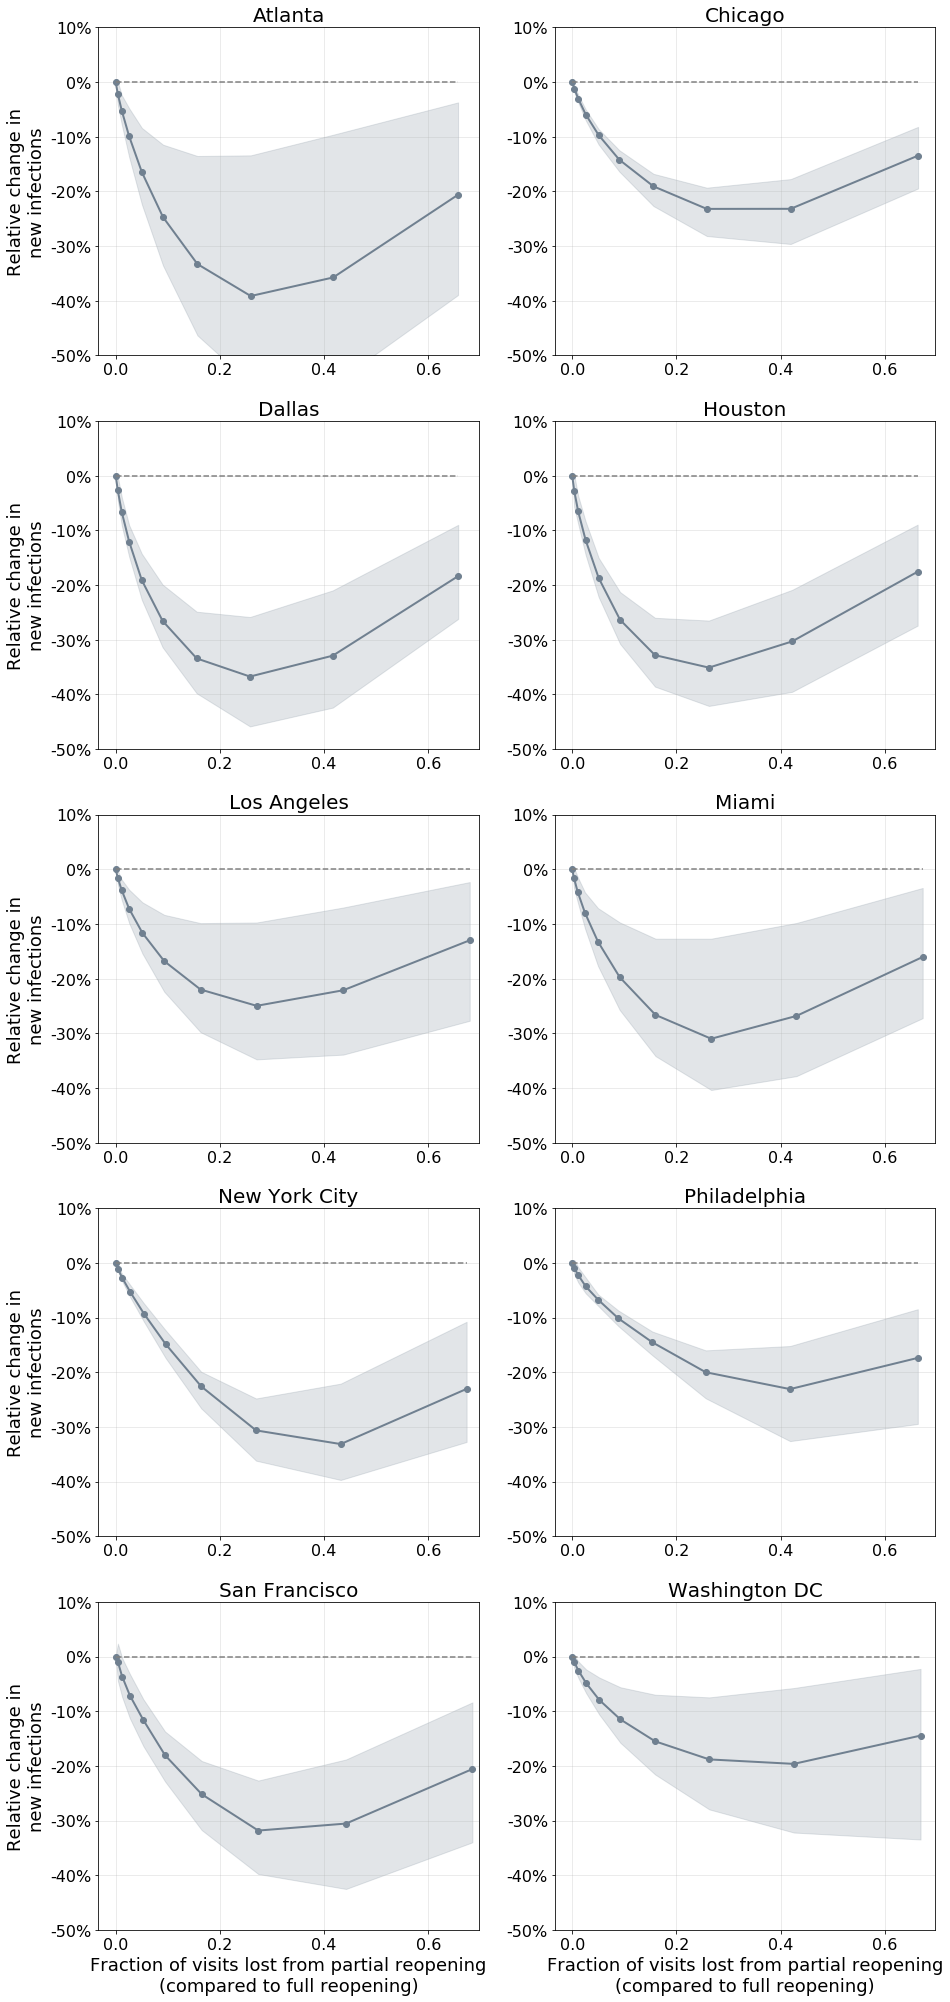

In [48]:
# reduced occupancy vs uniform reduction reopening
fig, axes = plt.subplots(5, 2, figsize=[15, 35])
axes = [ax for axes_row in axes for ax in axes_row]
yticks = np.arange(-.5, 0.11, .1)
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    X, Y_mean, Y_lower, Y_upper = plot_pairwise_comparison(max_cap_cases, uniform_df, msa, msa2full[msa], 
                                                      intervention_idx, ax, x_lim=x_lim, mode='percent_change',
                                                      yticks=yticks, set_axis_labels=False)
    if msa_idx % 2 == 0:
        ax.set_ylabel("Relative change in\nnew infections", fontsize=18)   
    if msa_idx >= 8:
        ax.set_xlabel("Fraction of visits lost from partial reopening\n(compared to full reopening)", fontsize=18)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=20)

## Figure 2d: Reopening different POI categories

In [72]:
min_timestring = '2020_07_22'
intervention_df = evaluate_all_fitted_models_for_experiment('test_interventions', 
                                                             min_timestring=min_timestring)
intervention_df['MSA_name'] = intervention_df['data_kwargs'].map(lambda x:x['MSA_name'])
for k in ['alpha', 
          'extra_weeks_to_simulate', 
          'intervention_datetime', 
          'top_category', 
          'sub_category']:
    intervention_df['counterfactual_%s' % k] = intervention_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k])
intervention_df['model_fit_rank_for_msa'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])
intervention_df['counterfactual_baseline_model'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
intervention_df['how_to_select_best_grid_search_models'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])
intervention_df_cases = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
intervention_df_deaths = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
intervention_df_deaths = intervention_df_deaths[intervention_df_deaths['timestring'] >= '2020_07_22_20']  # necessary bc emma ran some experiments on the same day
intervention_df_poisson = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_cases_poisson'].copy()

print('Found %d models for selecting with RMSE cases, %d for RMSE deaths, %d for Poisson cases' % 
       (len(intervention_df_cases), len(intervention_df_deaths), len(intervention_df_poisson)))
print(intervention_df_cases.groupby('MSA_name').size())

Loading models with timestrings between 2020_07_22 and 2020_10_09_18_22_21_500215
99399 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 21732 fitted models for test_interventions
Loaded 1 models so far: 0.007s -> 0.007s per model
Loaded 1001 models so far: 4.284s -> 0.004s per model
Loaded 2001 models so far: 8.550s -> 0.004s per model
Loaded 3001 models so far: 12.823s -> 0.004s per model
Loaded 4001 models so far: 17.047s -> 0.004s per model
Loaded 5001 models so far: 21.484s -> 0.004s per model
Loaded 6001 models so far: 25.644s -> 0.004s per model
Loaded 7001 models so far: 29.831s -> 0.004s per model
Loaded 8001 models so far: 34.027s -> 0.004s per model
Loaded 9001 models so far: 38.249s -> 0.004s per model
Loaded 10001 models so far: 42.932s -> 0.004s per model
Loaded 11001 models so far: 47.098s -> 0.004s per model
Loaded 12001 models so far: 51.197s -> 0.004s per model
Loaded 13001 models so far: 55.473s -> 0.004s per model
Loaded

In [73]:
intervention_df_cases['rmse_ratio'] = intervention_df_cases['model_kwargs'].map(lambda x:x['model_quality_dict']['ratio_of_loss_dict_daily_cases_RMSE_to_that_of_best_fitting_model'])
intervention_df_cases_10 = intervention_df_cases[intervention_df_cases['rmse_ratio'] <= 1.10]
print('Found %d models for selecting with RMSE cases 10%% threshold' % len(intervention_df_cases_10))

Found 1800 models for selecting with RMSE cases 10% threshold


Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       5858.725913   
1               Fitness Centers       1465.203749   
2            Cafes & Snack Bars       1373.272590   
3               Hotels & Motels       1198.198447   
4   Limited-Service Restaurants        881.411553   
5       Religious Organizations        681.363400   
6         Offices of Physicians        314.651923   
7                Grocery Stores        210.296815   
8       Used Merchandise Stores        137.564168   
9                    Pet Stores        117.542529   
10        Sporting Goods Stores        109.727934   
11         Other General Stores        109.181776   
12           Hobby & Toy Stores         72.834996   
13              Hardware Stores         58.185856   
14      Automotive Part

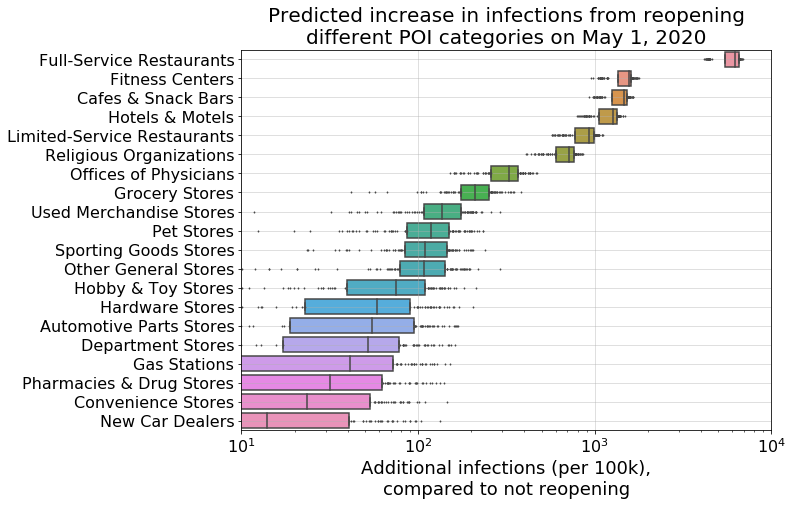

In [76]:
make_boxplot_of_poi_reopening_effects(
    intervention_df_cases, 
    [HIGHLIGHT_MSA], 
    poi_and_cbg_characteristics,
    titlestring='Predicted increase in infections from reopening\ndifferent POI categories on May 1, 2020', 
    cats_to_plot=top_categories, 
    filename=None,
    only_plot_reopening_impact=True)
plt.savefig('covid_figures_for_paper/%s_boxplots.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')
plt.show()

## Supplement: Chicago reopening results for all selection metrics

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       5858.725913                               595805.416667
1               Fitness Centers       1465.203749                               149004.466667
2            Cafes & Snack Bars       1373.272590                               139655.491667
3               Hotels & Motels       1198.198447                               121851.258333
4   Limited-Service Restaurants        881.411553                                89635.491667
5       Religious Organizations        681.363400                                69291.516667
6         Offices of Physicians        314.651923                                31998.650000
7                Grocery Stores        210.296815                 

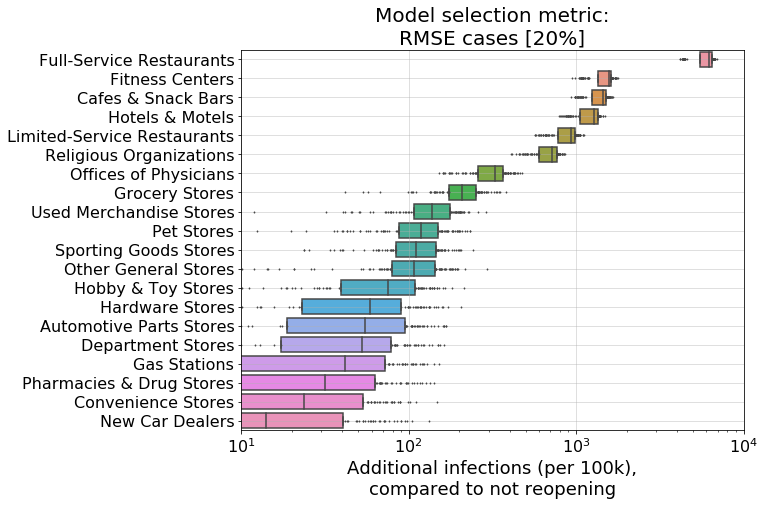

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       5625.344991                               572071.652778
1               Fitness Centers       1287.157549                               130897.988889
2            Cafes & Snack Bars       1281.794965                               130352.638889
3               Hotels & Motels       1110.546380                               112937.447222
4   Limited-Service Restaurants        809.730494                                82345.858333
5       Religious Organizations        637.593416                                64840.311111
6         Offices of Physicians        285.632717                                29047.530556
7                Grocery Stores        203.013272                 

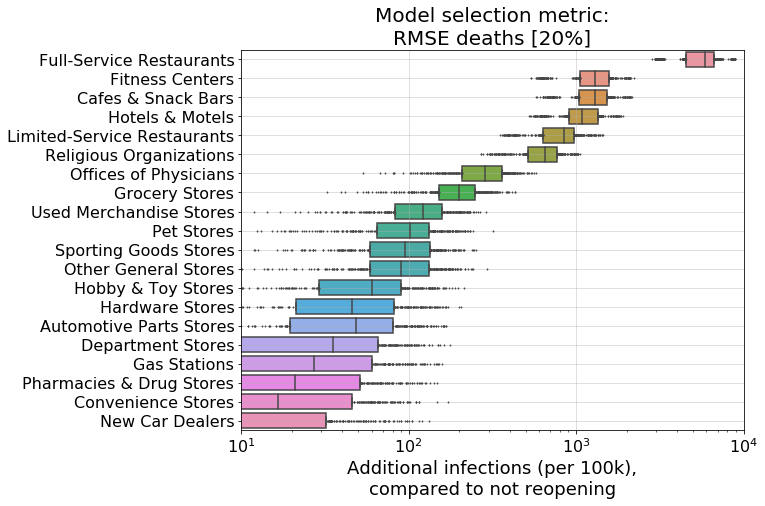

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       6996.736255                               711535.822222
1               Fitness Centers       1748.511904                               177815.600000
2            Cafes & Snack Bars       1615.692707                               164308.500000
3               Hotels & Motels       1450.864194                               147546.200000
4   Limited-Service Restaurants       1038.319218                               105592.277778
5       Religious Organizations        806.490835                                82016.400000
6         Offices of Physicians        378.936111                                38536.055556
7                Grocery Stores        240.066274                 

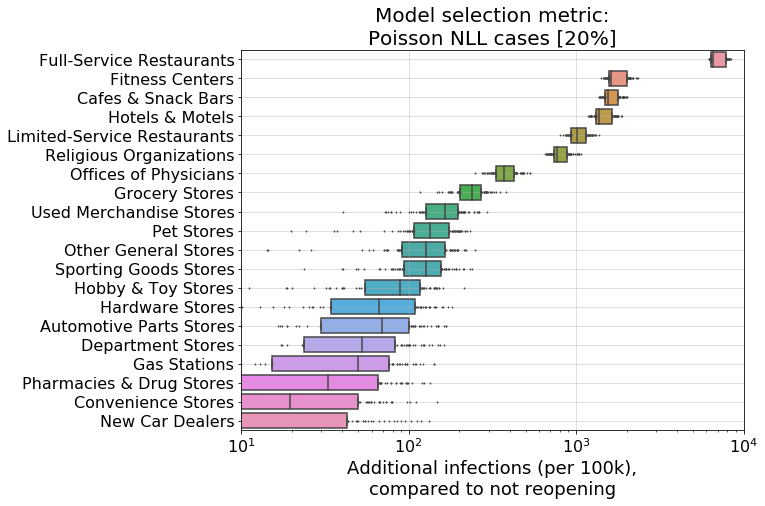

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       6501.255367                               661147.700000
1               Fitness Centers       1579.515551                               160629.450000
2            Cafes & Snack Bars       1502.248365                               152771.733333
3               Hotels & Motels       1323.733226                               134617.566667
4   Limited-Service Restaurants        963.536138                                97987.183333
5       Religious Organizations        747.707607                                76038.416667
6         Offices of Physicians        351.214216                                35716.866667
7                Grocery Stores        237.814451                 

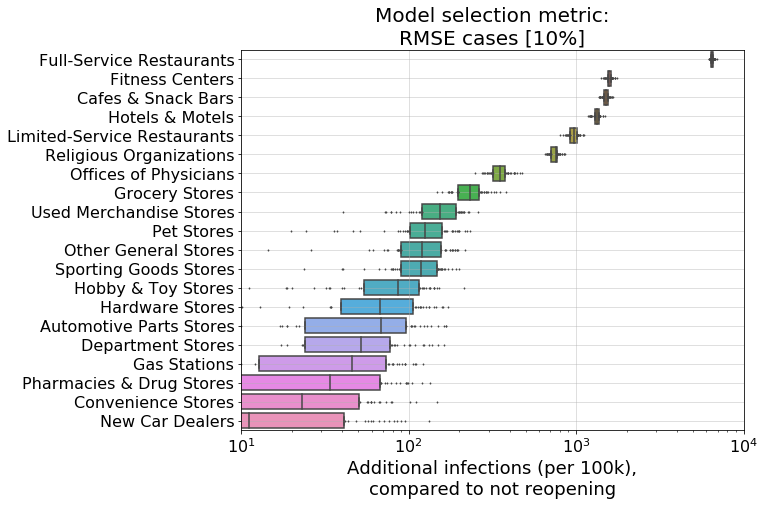

In [52]:
# only for Chicago
for df, metric in [(intervention_df_cases, 'RMSE cases [20%]'),
                  (intervention_df_deaths, 'RMSE deaths [20%]'),
                  (intervention_df_poisson, 'Poisson NLL cases [20%]'),
                  (intervention_df_cases_10, 'RMSE cases [10%]')]:
    make_boxplot_of_poi_reopening_effects(
        df, 
        [HIGHLIGHT_MSA], 
        poi_and_cbg_characteristics,
        titlestring='Model selection metric:\n%s' % metric, 
        cats_to_plot=top_categories, 
        filename=None,
        only_plot_reopening_impact=True)
    plt.show()

## Supplement: POI attributes and reopening results for all MSAs

Making plots using ['Atlanta_Sandy_Springs_Roswell_GA']
Atlanta_Sandy_Springs_Roswell_GA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       2344.272544                               174780.029167
1               Fitness Centers       1276.461138                                95168.079167
2               Hotels & Motels       1073.336628                                80023.889583
3       Religious Organizations        754.704382                                56267.883333
4            Cafes & Snack Bars        610.810674                                45539.716667
5   Limited-Service Restaurants        293.803992                                21904.906250
6         Offices of Physicians        176.525472                                13161.066667
7            Hobby & Toy Stores         99.249444                   

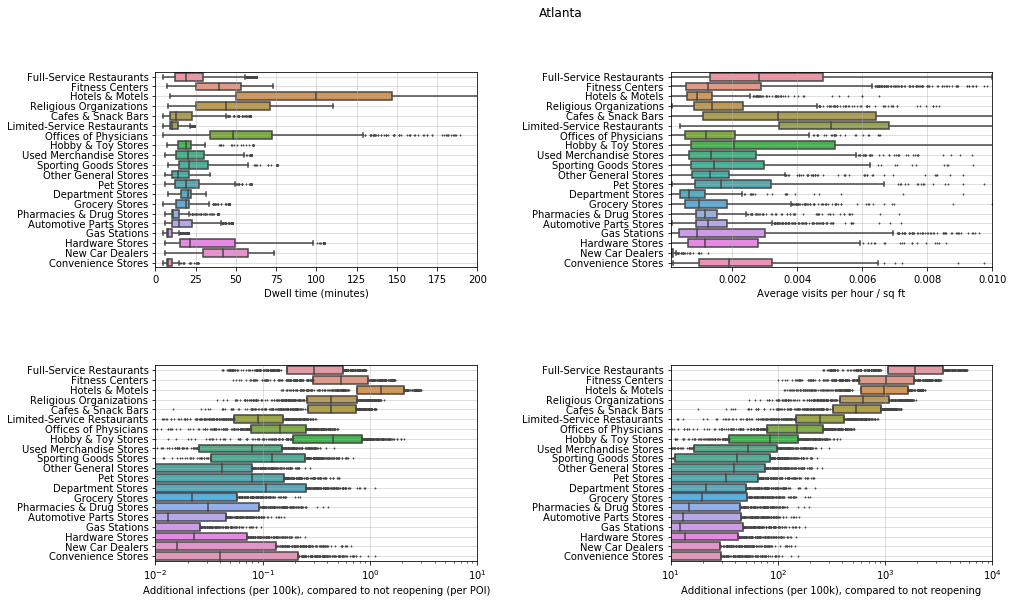

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       5858.725913                               595805.416667
1               Fitness Centers       1465.203749                               149004.466667
2            Cafes & Snack Bars       1373.272590                               139655.491667
3               Hotels & Motels       1198.198447                               121851.258333
4   Limited-Service Restaurants        881.411553                                89635.491667
5       Religious Organizations        681.363400                                69291.516667
6         Offices of Physicians        314.651923                                31998.650000
7                Grocery Stores        210.296815                 

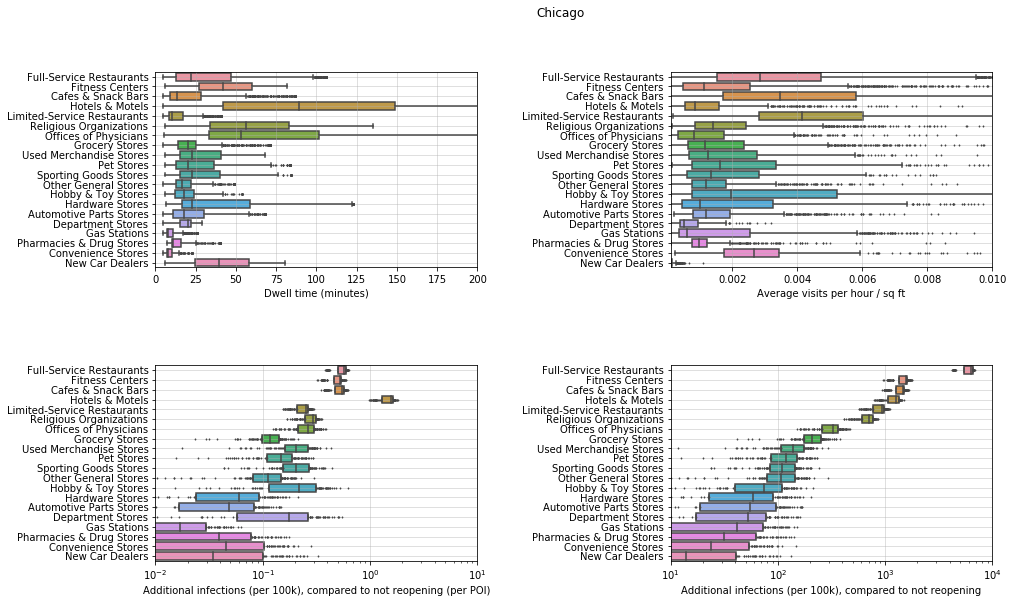

Making plots using ['Dallas_Fort_Worth_Arlington_TX']
Dallas_Fort_Worth_Arlington_TX
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       1605.273400                               150150.226667
1               Hotels & Motels        637.228467                                59603.553333
2       Religious Organizations        624.704395                                58432.106667
3               Fitness Centers        462.609410                                43270.453333
4   Limited-Service Restaurants        407.965765                                38159.326667
5            Cafes & Snack Bars        221.094618                                20680.220000
6         Offices of Physicians         98.723185                                 9234.133333
7       Used Merchandise Stores         42.016868                       

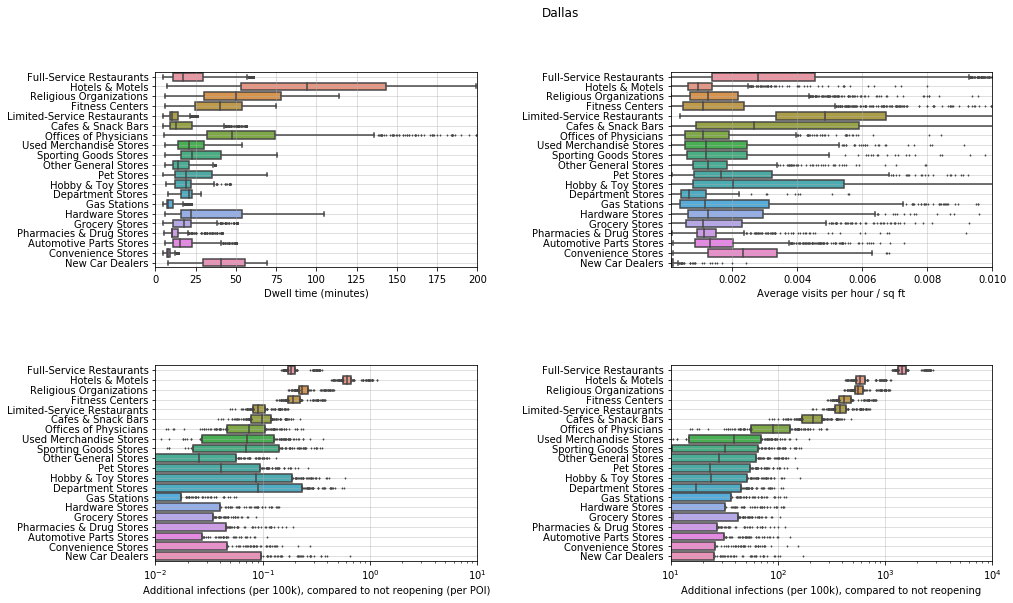

Making plots using ['Houston_The_Woodlands_Sugar_Land_TX']
Houston_The_Woodlands_Sugar_Land_TX
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       1278.850355                                97468.104167
1               Hotels & Motels        664.587221                                50651.787500
2               Fitness Centers        262.843225                                20032.704167
3       Religious Organizations        241.721840                                18422.929167
4            Cafes & Snack Bars        198.880876                                15157.787500
5         Offices of Physicians        128.758465                                 9813.379167
6   Limited-Service Restaurants        122.320407                                 9322.700000
7               Hardware Stores         40.873679             

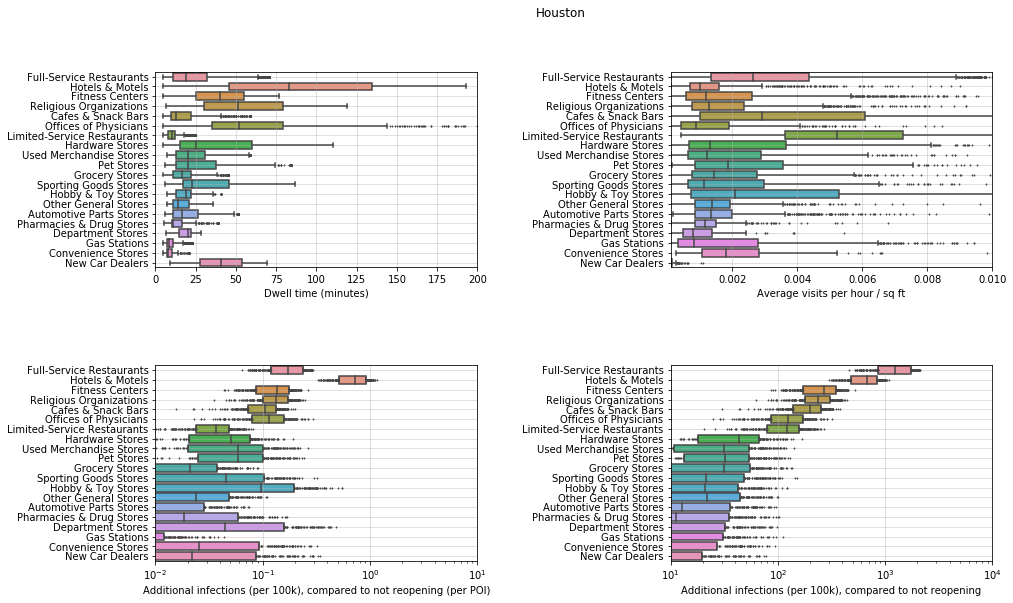

Making plots using ['Los_Angeles_Long_Beach_Anaheim_CA']
Los_Angeles_Long_Beach_Anaheim_CA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       2752.530489                               443192.476000
1               Fitness Centers        778.802141                               125397.066667
2            Cafes & Snack Bars        626.298540                               100842.044000
3               Hotels & Motels        593.268193                                95523.737333
4       Religious Organizations        466.100939                                75048.189333
5   Limited-Service Restaurants        319.281460                                51408.382667
6          Other General Stores        203.723465                                32802.073333
7                Grocery Stores        147.503856                 

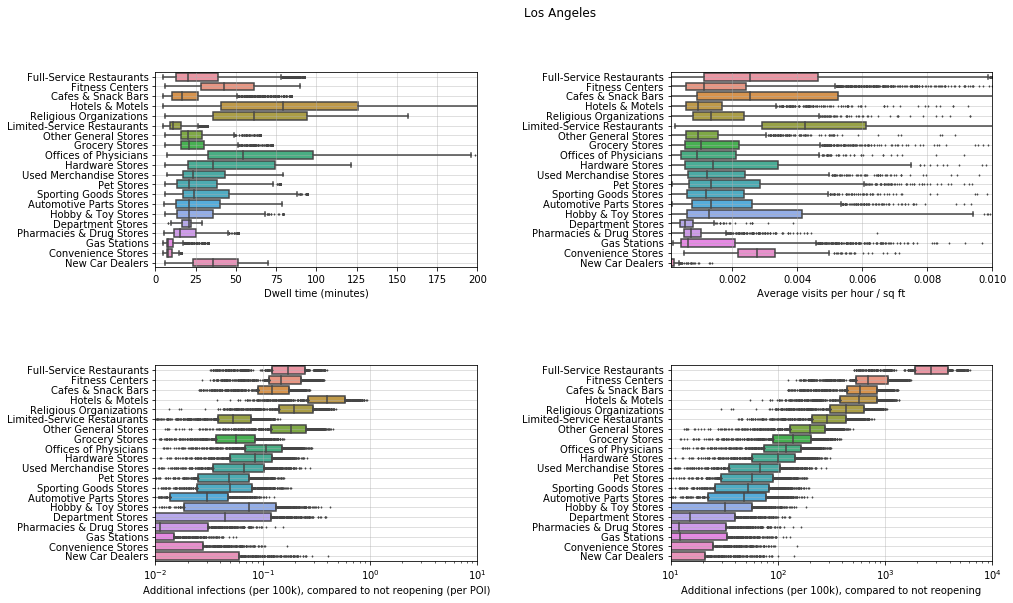

Making plots using ['Miami_Fort_Lauderdale_West_Palm_Beach_FL']
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       1847.074675                               126212.995238
1               Hotels & Motels       1386.643973                                94751.171429
2               Fitness Centers        694.078316                                47427.266667
3            Cafes & Snack Bars        498.709477                                34077.461905
4       Religious Organizations        195.405982                                13352.342857
5   Limited-Service Restaurants        172.364248                                11777.871429
6         Offices of Physicians        116.364316                                 7951.323810
7         Sporting Goods Stores         87.088667   

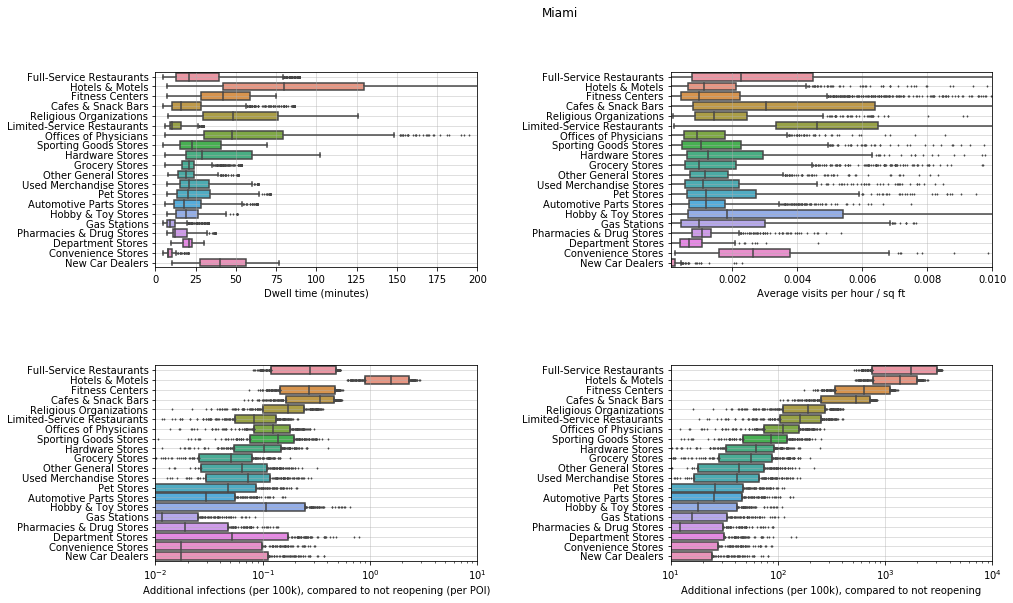

Making plots using ['New_York_Newark_Jersey_City_NY_NJ_PA']
New_York_Newark_Jersey_City_NY_NJ_PA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       6257.030173                                1.297050e+06
1               Fitness Centers       1961.650932                                4.066401e+05
2            Cafes & Snack Bars       1467.018490                                3.041053e+05
3               Hotels & Motels        738.110088                                1.530064e+05
4       Religious Organizations        703.973130                                1.459300e+05
5   Limited-Service Restaurants        545.801297                                1.131418e+05
6         Offices of Physicians        476.329684                                9.874067e+04
7                Grocery Stores        222.093976           

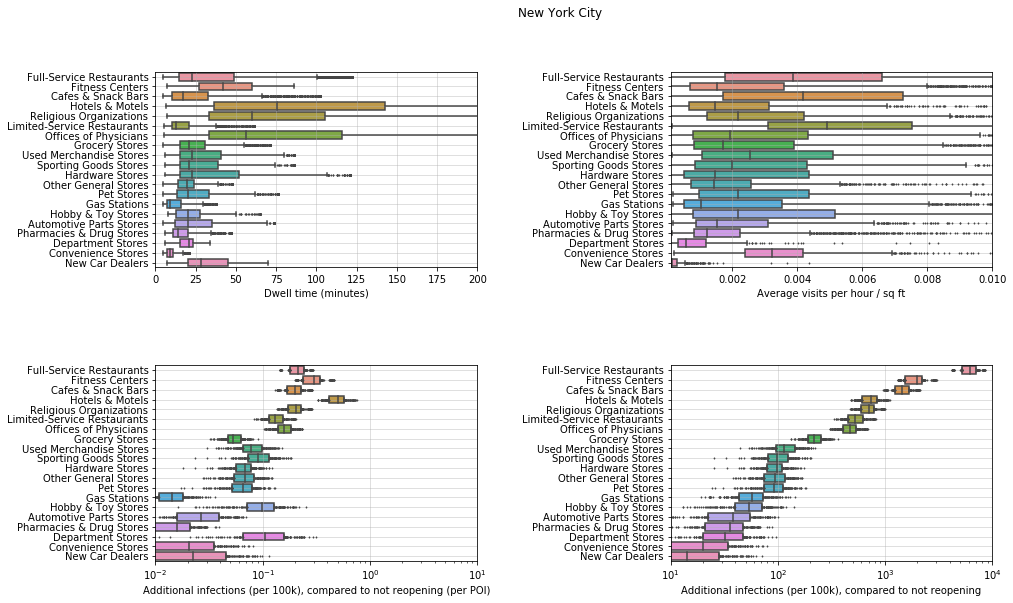

Making plots using ['Philadelphia_Camden_Wilmington_PA_NJ_DE_MD']
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       2562.917956                               173229.111111
1            Cafes & Snack Bars        450.008139                                30416.311111
2                Grocery Stores        311.822381                                21076.255556
3               Hotels & Motels        227.802783                                15397.322222
4       Religious Organizations        214.417782                                14492.622222
5               Fitness Centers        197.275518                                13333.966667
6   Limited-Service Restaurants        182.821170                                12356.988889
7         Offices of Physicians        128.07734

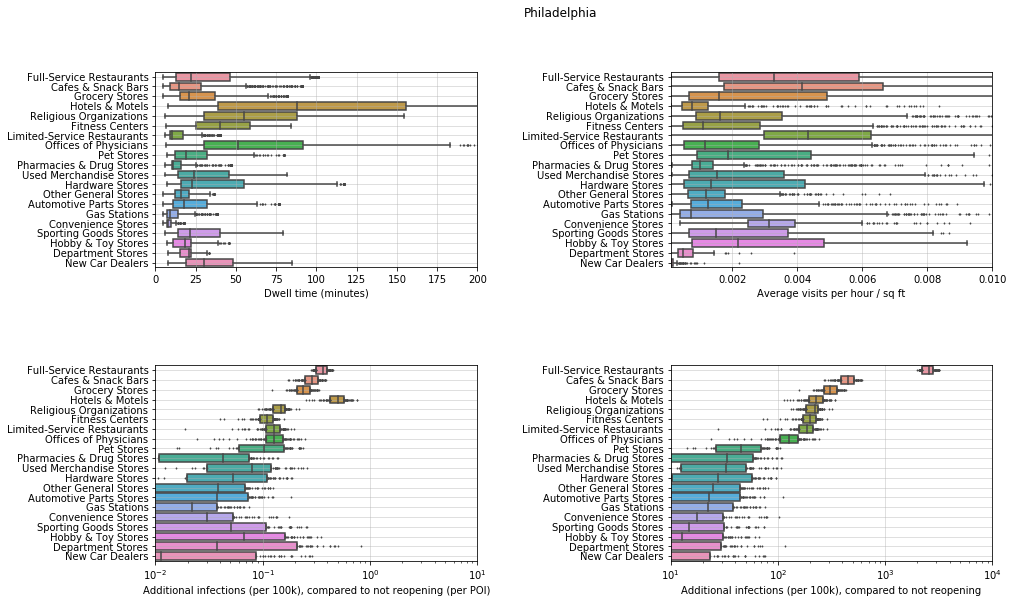

Making plots using ['San_Francisco_Oakland_Hayward_CA']
San_Francisco_Oakland_Hayward_CA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants        972.516512                                49965.953333
1               Hotels & Motels        254.528008                                13077.140000
2            Cafes & Snack Bars        110.853154                                 5695.413333
3               Fitness Centers        110.682523                                 5686.646667
4               Hardware Stores         58.437593                                 3002.406667
5       Religious Organizations         35.550625                                 1826.520000
6         Offices of Physicians         32.102327                                 1649.353333
7   Limited-Service Restaurants         24.867713                   

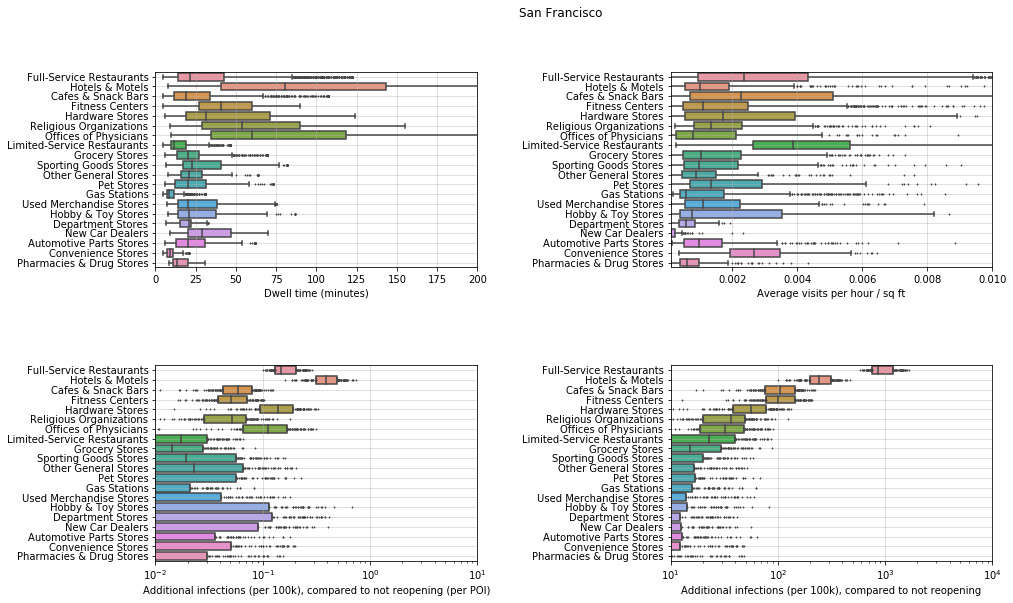

Making plots using ['Washington_Arlington_Alexandria_DC_VA_MD_WV']
Washington_Arlington_Alexandria_DC_VA_MD_WV
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       2513.971458                               194588.329412
1            Cafes & Snack Bars       1290.948874                                99923.005882
2               Hotels & Motels       1266.208408                                98008.025490
3               Fitness Centers       1055.757990                                81718.582353
4   Limited-Service Restaurants        729.932400                                56498.782353
5       Religious Organizations        409.783635                                31718.384314
6         Offices of Physicians        205.798964                                15929.407843
7               Hardware Stores        136.329

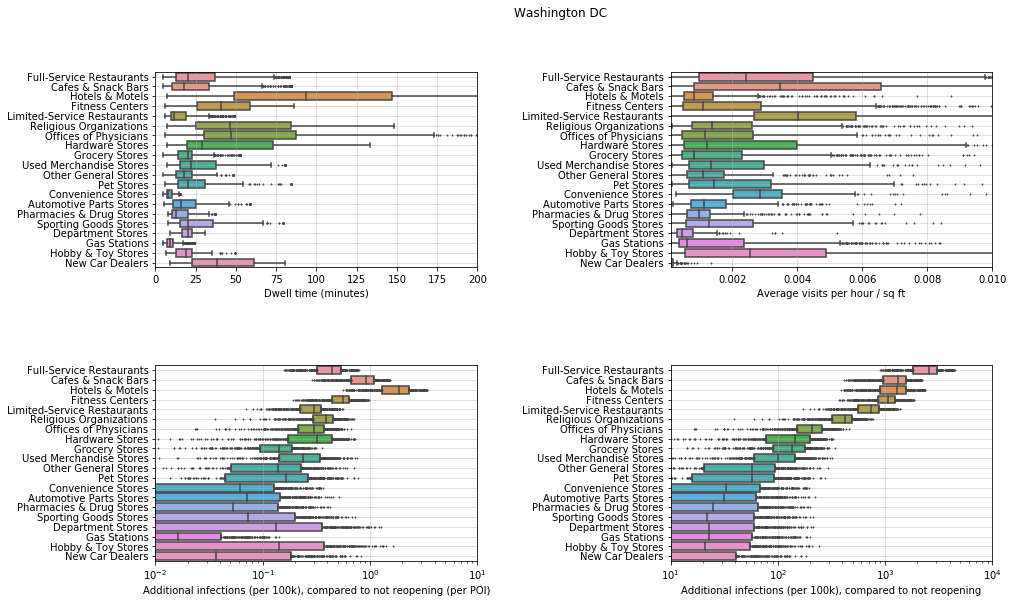

In [53]:
for msa in MSAS:
    make_boxplot_of_poi_reopening_effects(intervention_df_cases, 
                                          [msa], 
                                          poi_and_cbg_characteristics, 
                                          titlestring=MSAS_TO_PRETTY_NAMES[msa], 
                                          cats_to_plot=top_categories, 
                                          filename='covid_figures_for_paper/reopening_impact_boxplots_%s.pdf' % msa)
    plt.show()

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  total_additional_infections_from_reopening
0      Full-Service Restaurants       5858.725913                               595805.416667
1               Fitness Centers       1465.203749                               149004.466667
2            Cafes & Snack Bars       1373.272590                               139655.491667
3               Hotels & Motels       1198.198447                               121851.258333
4   Limited-Service Restaurants        881.411553                                89635.491667
5       Religious Organizations        681.363400                                69291.516667
6         Offices of Physicians        314.651923                                31998.650000
7                Grocery Stores        210.296815                 

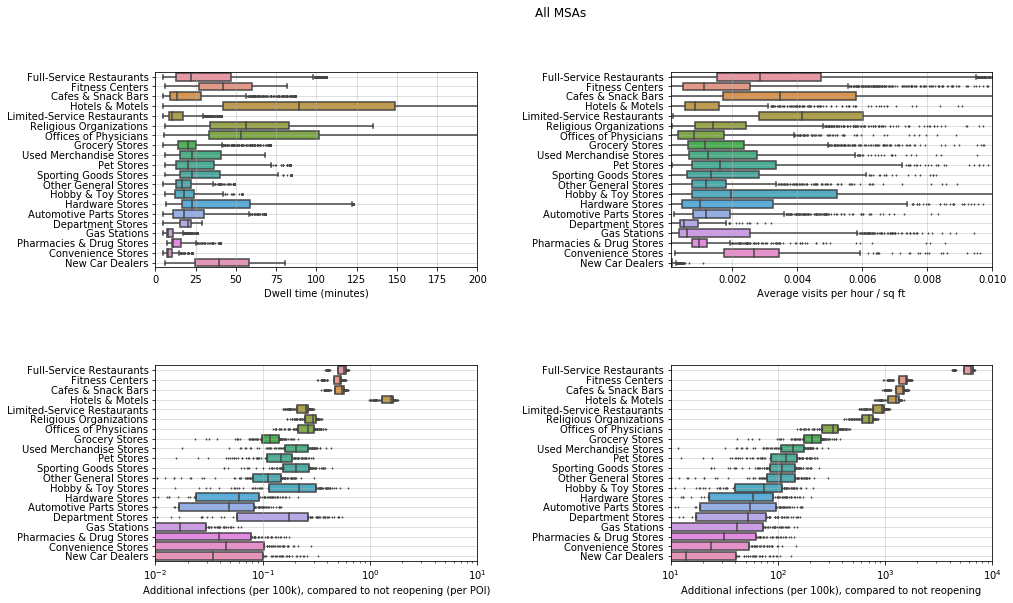

In [54]:
make_boxplot_of_poi_reopening_effects(intervention_df_cases, 
                                      [HIGHLIGHT_MSA],
                                      poi_and_cbg_characteristics, 
                                      titlestring='All MSAs', 
                                      cats_to_plot=top_categories, 
                                      filename='covid_figures_for_paper/reopening_impact_boxplots_all_MSAs.pdf')
plt.show()

Making plots using ['Atlanta_Sandy_Springs_Roswell_GA', 'Chicago_Naperville_Elgin_IL_IN_WI', 'Dallas_Fort_Worth_Arlington_TX', 'Houston_The_Woodlands_Sugar_Land_TX', 'Los_Angeles_Long_Beach_Anaheim_CA', 'Miami_Fort_Lauderdale_West_Palm_Beach_FL', 'New_York_Newark_Jersey_City_NY_NJ_PA', 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD', 'San_Francisco_Oakland_Hayward_CA', 'Washington_Arlington_Alexandria_DC_VA_MD_WV']
Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV
Reopening impact quantifies cases per 100000
Pearson correlations between attributes
reopening_impact_per_poi           1.000000
original_dwell_times               0.734545
weighted_visits_over_area          0.085111
d

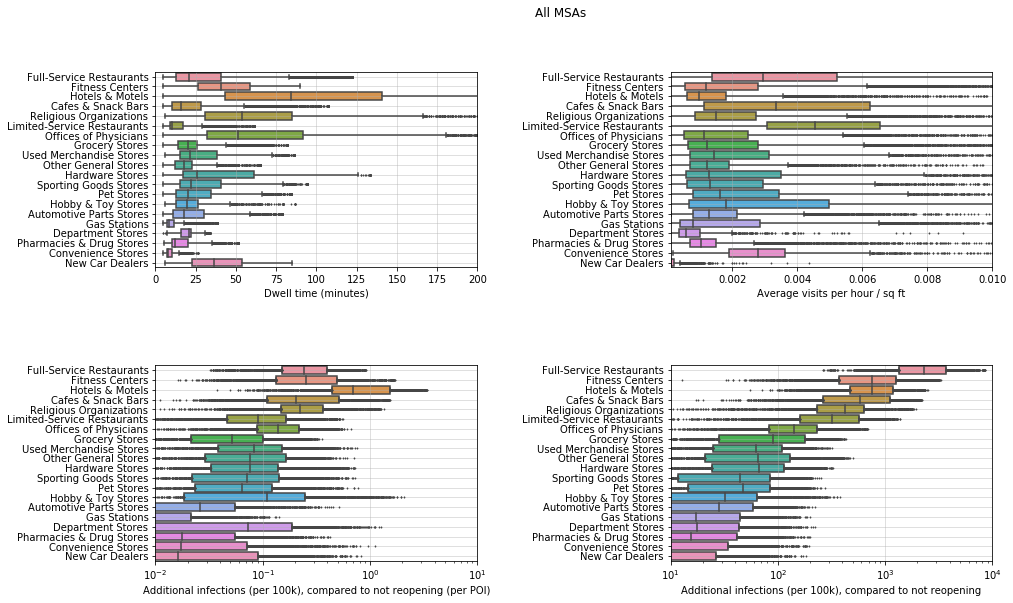

In [55]:
make_boxplot_of_poi_reopening_effects(intervention_df_cases, 
                                      MSAS,
                                      poi_and_cbg_characteristics, 
                                      titlestring='All MSAs', 
                                      cats_to_plot=top_categories, 
                                      filename='covid_figures_for_paper/reopening_impact_boxplots_all_MSAs.pdf')
plt.show()

## Supplement: disparate impacts of reopening POI categories

Analyzing results for rich and poor deciles
97 models to load for closed df; 1940 models to load for opened interventions
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910


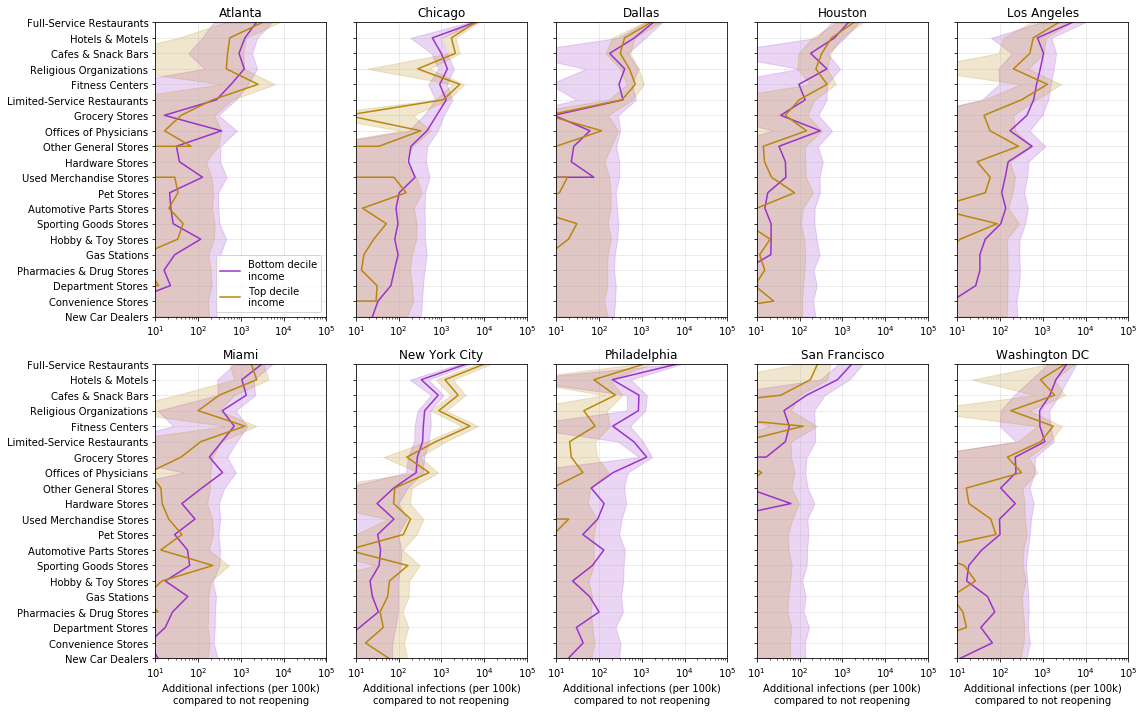

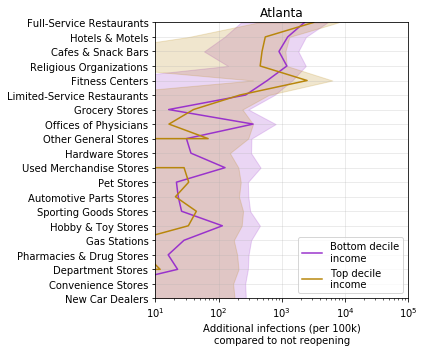

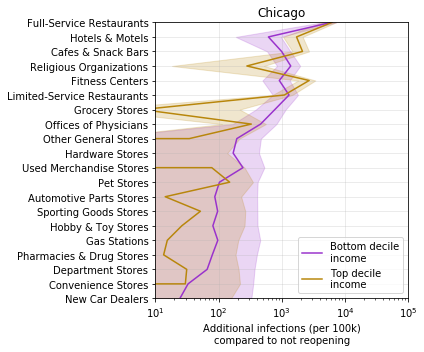

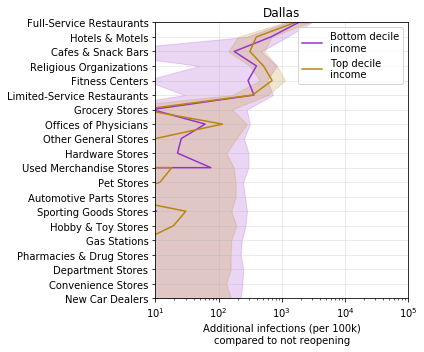

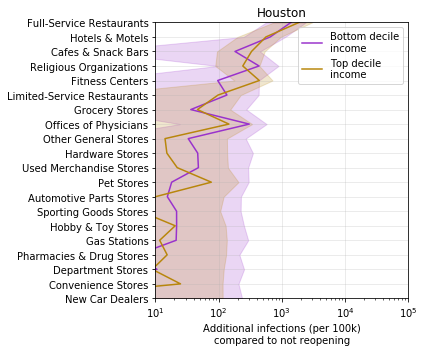

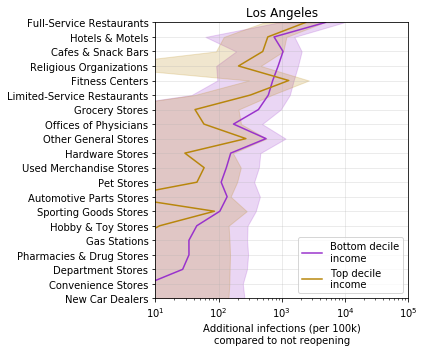

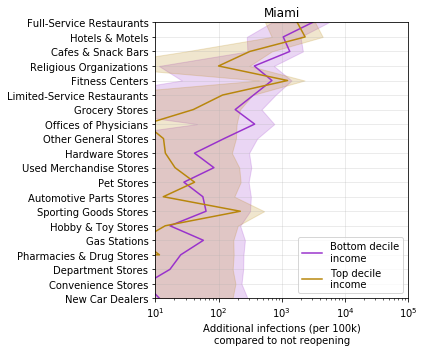

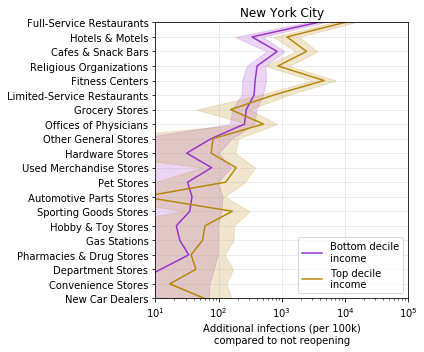

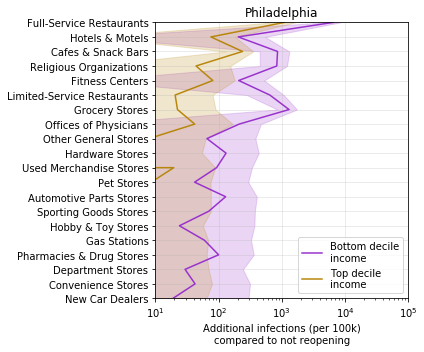

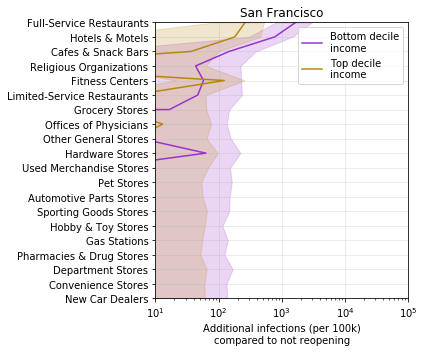

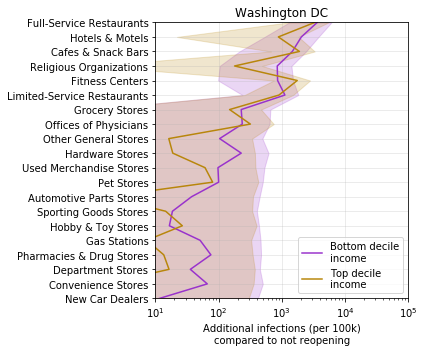

In [56]:
plot_reopening_effect_by_poi_category_with_disparate_impact(intervention_df_cases, 
                                      medians_or_deciles='deciles', 
                                      cats_to_plot=top_categories,
                                      filename='covid_figures_for_paper/reopening_by_poi_decile_income.pdf')
plt.show()

# Equity analysis

## Figure 3a/b: disparate impact plots 

Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100, loss_tolerance=1.200, and key_to_sort_by=loss_dict_daily_cases_RMSE
Plotting 16 models for Atlanta_Sandy_Springs_Roswell_GA
Plotting 4 models for Chicago_Naperville_Elgin_IL_IN_WI
Plotting 5 models for Dallas_Fort_Worth_Arlington_TX
Plotting 8 models for Houston_The_Woodlands_Sugar_Land_TX
Plotting 25 models for Los_Angeles_Long_Beach_Anaheim_CA
Plotting 7 models for Miami_Fort_Lauderdale_West_Palm_Beach_FL
Plotting 7 models for New_York_Newark_Jersey_City_NY_NJ_PA
Plotting 3 models for Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Plotting 5 models for San_Francisco_Oakland_Hayward_CA
Plotting 17 models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Median of medians for p_white deciles 3.0411060218470354
Median of medians for median_household_income deciles 2.54431935015807


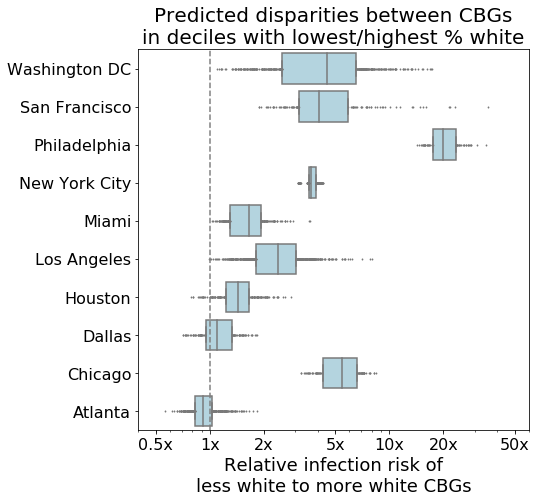

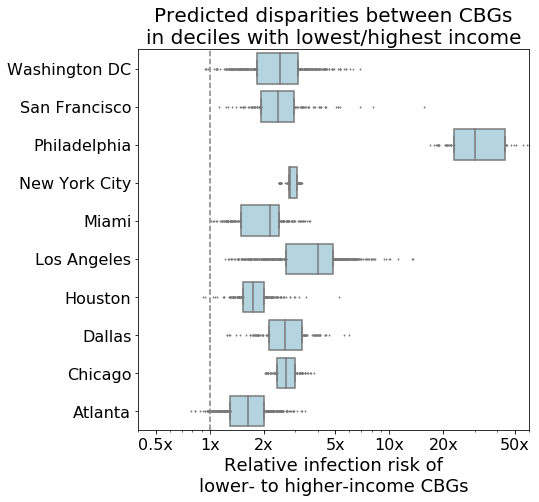

In [79]:
table_results, all_ratios = make_all_disparities_infection_ratio_plots(non_ablation_df, return_all_ratios=True,
                                                                       save_figs=True)

In [58]:
# pull numbers for reviewer 
print("Ratios in philadelphia")
for demo in ['median_household_income', 'p_white']:
    for comparison in ['deciles']:
        ratios_of_interest= all_ratios.loc[(all_ratios['MSA'] == "Philadelphia") & 
                                           (all_ratios['comparison'] == comparison) & 
                                           (all_ratios['demo'] == demo)]
        print(demo, comparison)
        print(ratios_of_interest['ratio'].describe([0.025, 0.25, 0.50, 0.75, 0.975]))

Ratios in philadelphia
median_household_income deciles
count    90.000000
mean     37.939205
std      21.121552
min      16.809660
2.5%     18.200112
25%      23.024860
50%      29.967498
75%      44.261275
97.5%    93.111137
max      96.193934
Name: ratio, dtype: float64
p_white deciles
count    90.000000
mean     20.673173
std       4.190607
min      14.223834
2.5%     15.104163
25%      17.517653
50%      20.031099
75%      23.556322
97.5%    28.466960
max      34.626459
Name: ratio, dtype: float64


In [59]:
table_results.loc[(table_results['demo'] == 'median_household_income')].sort_values(by=['MSA_name', 'comparison'])

MSA_name comparison                     demo  disadvantaged_group_is_more_sick  median_ratio   n
3              Atlanta_Sandy_Springs_Roswell_GA    deciles  median_household_income                          0.968750      1.625140  16
2              Atlanta_Sandy_Springs_Roswell_GA    medians  median_household_income                          0.947917      1.232754  16
9             Chicago_Naperville_Elgin_IL_IN_WI    deciles  median_household_income                          1.000000      2.667129   4
8             Chicago_Naperville_Elgin_IL_IN_WI    medians  median_household_income                          1.000000      2.017313   4
15               Dallas_Fort_Worth_Arlington_TX    deciles  median_household_income                          1.000000      2.639519   5
14               Dallas_Fort_Worth_Arlington_TX    medians  median_household_income                          1.000000      1.417964   5
21          Houston_The_Woodlands_Sugar_Land_TX    deciles  median_household_income                          0.991667      1.735490   8
20          Houston_The_Woodlands_Sugar_Land_TX    medians  median_household_income                          1.000000      1.599249   8
27            Los_Angeles_Long_Beach_Anaheim_CA    deciles  median_household_income                          1.000000      4.034546  25
26            Los_Angeles_Long_Beach_Anaheim_CA    medians  median_household_income                          1.000000      2.353727  25
33     Miami_Fort_Lauderdale_West_Palm_Beach_FL    deciles  median_household_income                          1.000000      2.161475   7
32     Miami_Fort_Lauderdale_West_Palm_Beach_FL    medians  median_household_income                          1.000000      1.476416   7
39         New_York_Newark_Jersey_City_NY_NJ_PA    deciles  median_household_income                          1.000000      2.815037   7
38         New_York_Newark_Jersey_City_NY_NJ_PA    medians  median_household_income                          1.000000      2.052064   7
45   Philadelphia_Camden_Wilmington_PA_NJ_DE_MD    deciles  median_household_income                          1.000000     29.967498   3
44   Philadelphia_Camden_Wilmington_PA_NJ_DE_MD    medians  median_household_income                          1.000000      9.557234   3
51             San_Francisco_Oakland_Hayward_CA    deciles  median_household_income                          1.000000      2.406054   5
50             San_Francisco_Oakland_Hayward_CA    medians  median_household_income                          1.000000      2.400435   5
57  Washington_Arlington_Alexandria_DC_VA_MD_WV    deciles  median_household_income                          0.992157      2.449120  17
56  Washington_Arlington_Alexandria_DC_VA_MD_WV    medians  median_household_income                          0.998039      1.642814  17

## Supplement: disparity results for all model selection metrics

Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100, loss_tolerance=1.100, and key_to_sort_by=loss_dict_daily_cases_RMSE
Plotting 8 models for Atlanta_Sandy_Springs_Roswell_GA
Plotting 2 models for Chicago_Naperville_Elgin_IL_IN_WI
Plotting 2 models for Dallas_Fort_Worth_Arlington_TX
Plotting 6 models for Houston_The_Woodlands_Sugar_Land_TX
Plotting 10 models for Los_Angeles_Long_Beach_Anaheim_CA
Plotting 3 models for Miami_Fort_Lauderdale_West_Palm_Beach_FL
Plotting 4 models for New_York_Newark_Jersey_City_NY_NJ_PA
Plotting 2 models for Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Plotting 4 models for San_Francisco_Oakland_Hayward_CA
Plotting 4 models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Median of medians for p_white deciles 3.1788085915496254
Median of medians for median_household_income deciles 2.6698765081864533
Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100, loss_tolerance=1.200, and key_to_sort_by=loss_dict_daily_deaths_RMSE
Plotting 27 models for Atlanta_Sandy_Springs_Ros

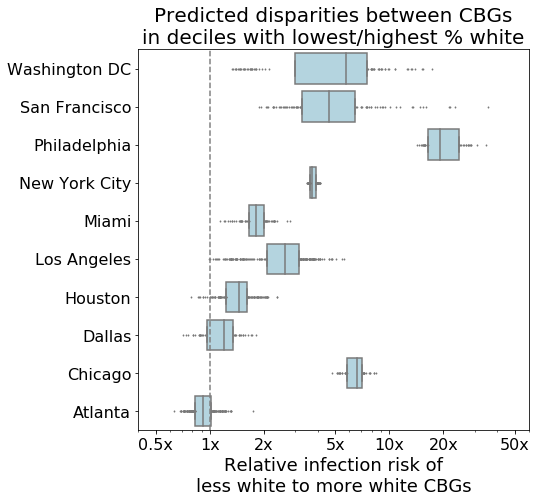

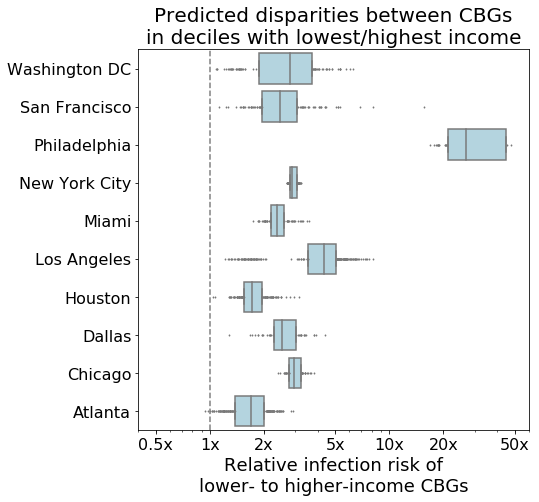

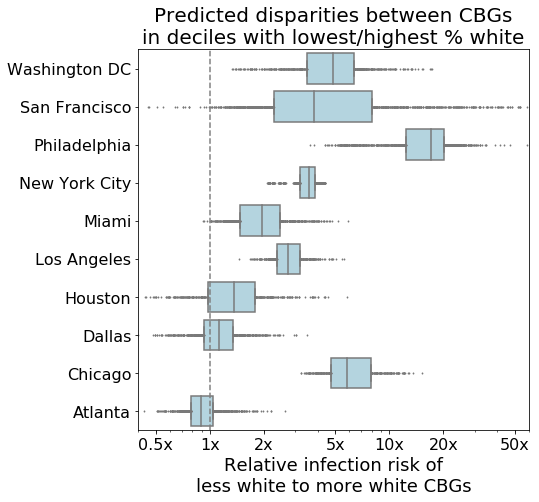

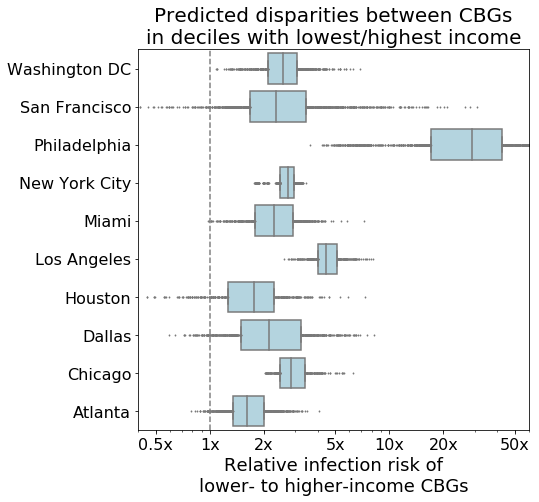

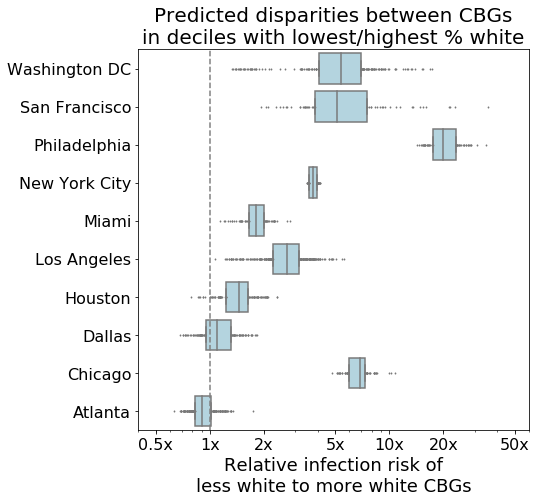

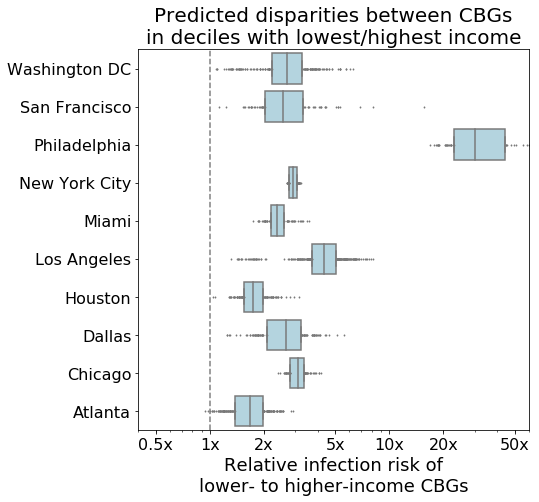

In [60]:
out = make_all_disparities_infection_ratio_plots(non_ablation_df, key_to_sort_by='loss_dict_daily_cases_RMSE',
                                           loss_tolerance=1.1)
out = make_all_disparities_infection_ratio_plots(non_ablation_df, key_to_sort_by='loss_dict_daily_deaths_RMSE',
                                           loss_tolerance=1.2)
out = make_all_disparities_infection_ratio_plots(non_ablation_df, key_to_sort_by='loss_dict_daily_cases_poisson_NLL_thres-10_sum',
                                           loss_tolerance=1.2)

## Figure 3c: disparate impact within POI categories for highlighted MSAs

Num params * seeds: 120


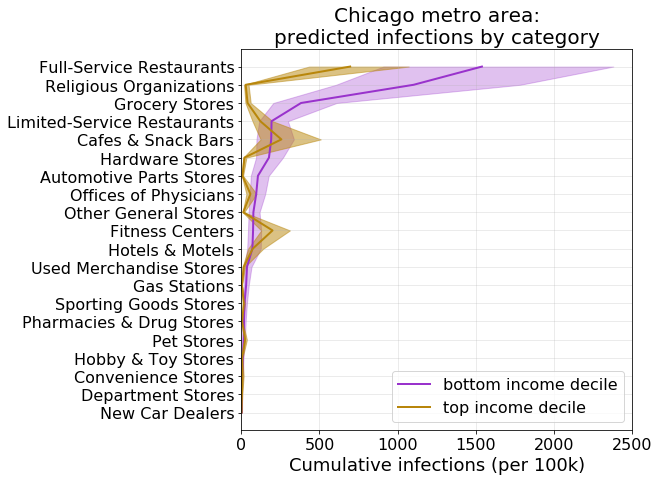

In [87]:
fig, ax = plt.subplots(figsize=(7, 7))
category_order = plot_frac_infected_per_category_for_multiple_models(superspreader_df_cases, poi_and_cbg_characteristics, 
                         HIGHLIGHT_MSA, ax, pretty_top_categories, sort_categories=True)
ax.legend(fontsize=16, loc='lower right')
ax.set_title('%s metro area:\npredicted infections by category' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA], fontsize=20)
plt.savefig('covid_figures_for_paper/%s_infections_per_category.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')
plt.show()

## Supplement: disparate impact within POI categories for all MSAs

Atlanta_Sandy_Springs_Roswell_GA
Num params * seeds: 480
Chicago_Naperville_Elgin_IL_IN_WI
Num params * seeds: 120
Dallas_Fort_Worth_Arlington_TX
Num params * seeds: 150
Houston_The_Woodlands_Sugar_Land_TX
Num params * seeds: 240
Los_Angeles_Long_Beach_Anaheim_CA
Num params * seeds: 750
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA
Num params * seeds: 210
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Num params * seeds: 90
San_Francisco_Oakland_Hayward_CA
Num params * seeds: 150
Washington_Arlington_Alexandria_DC_VA_MD_WV
Num params * seeds: 510


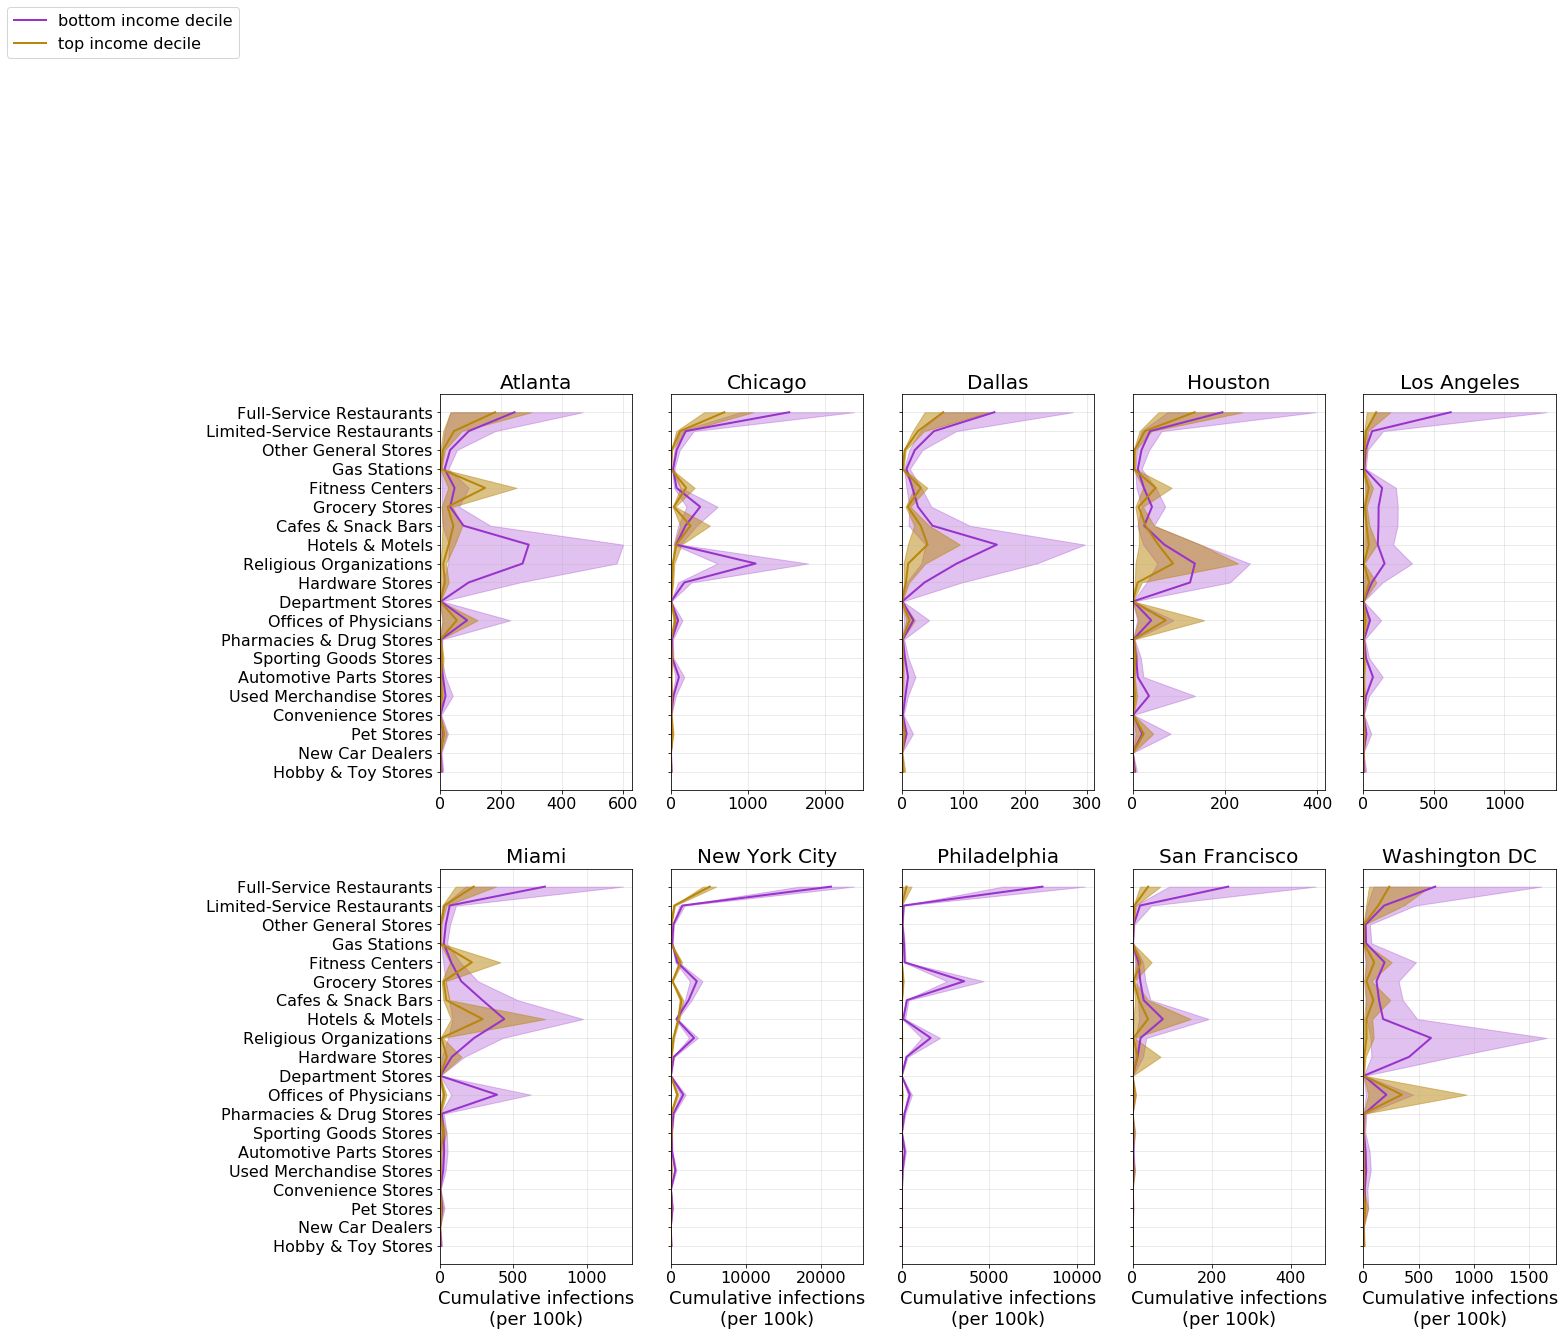

In [30]:
fig, axes = plt.subplots(2, 5, figsize=(20, 16), sharey=True)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    plot_frac_infected_per_category_for_multiple_models(superspreader_df_cases, poi_and_cbg_characteristics, 
                                                        msa_name, ax, pretty_top_categories)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=20)
    if i < 5:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Cumulative infections\n(per 100k)', fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-1, 2), fontsize=16)
plt.show()

## Figure 3d: mobility over time

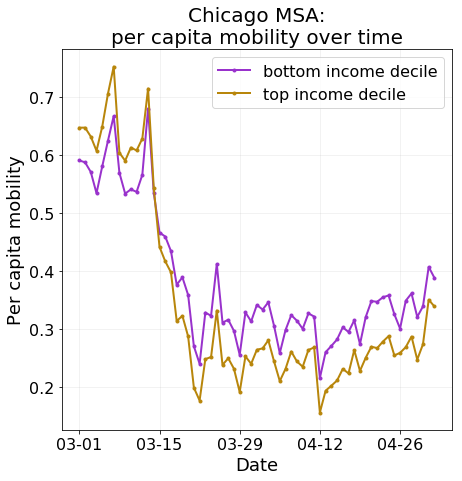

In [81]:
fig, ax = plt.subplots(figsize=(7, 7))
hours, Y1, Y2 = make_mobility_comparison_line_plot(poi_and_cbg_characteristics, HIGHLIGHT_MSA, MIN_DATETIME, MAX_DATETIME, 
                                   LOWINCOME, 'bottom income decile', 'darkorchid',
                                   HIGHINCOME, 'top income decile', 'darkgoldenrod', ax)
ax.set_title('%s MSA:\nper capita mobility over time' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA], fontsize=20)
plt.savefig('covid_figures_for_paper/%s_mobility_over_time.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')

In [66]:
april_start = hours.index(datetime.datetime(2020, 4, 1, 0))
april_end = hours.index(datetime.datetime(2020, 5, 1, 0))
Y1_sum = np.sum(Y1[april_start:april_end])
Y2_sum = np.sum(Y2[april_start:april_end])
diff = (Y1_sum - Y2_sum) / Y2_sum
print('bottom income decile has %.3f%% more POIs visits in April than top income decile' % (diff * 100))

bottom income decile has 26.753% more POIs visits in April than top income decile


## Supplement: mobility over time, all MSAs, SES and race

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


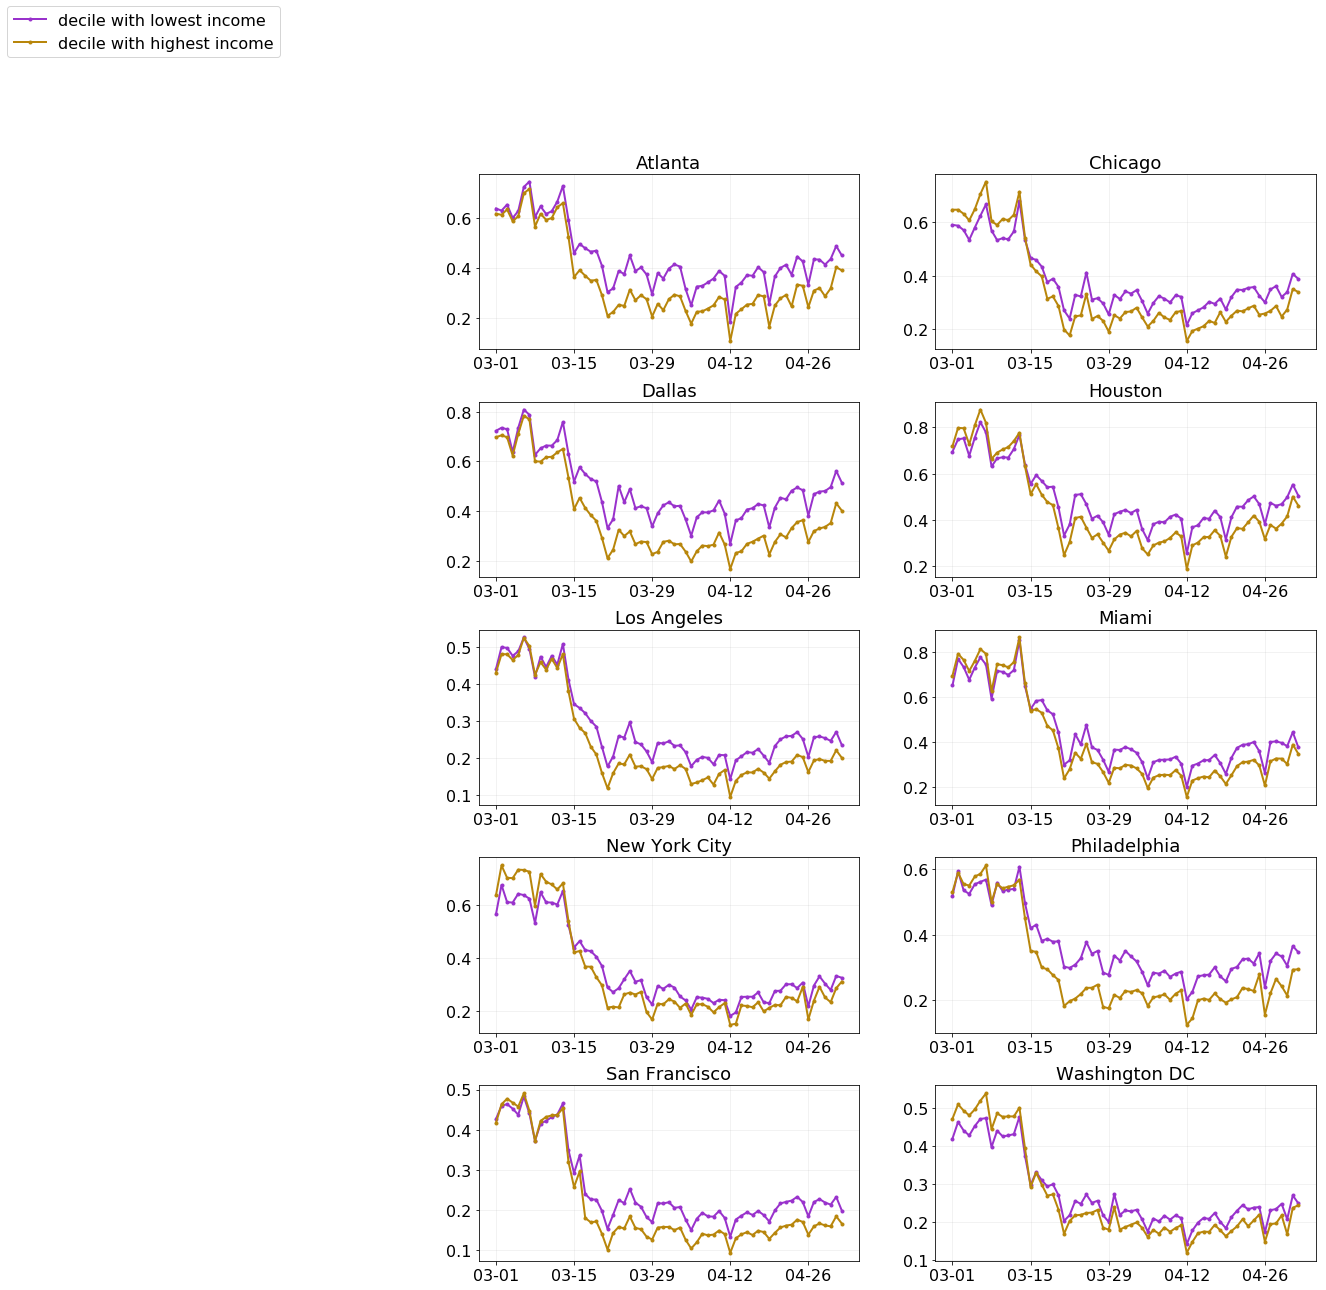

In [67]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=14)
    make_mobility_comparison_line_plot(poi_and_cbg_characteristics, msa_name, MIN_DATETIME, MAX_DATETIME, 
                                       LOWINCOME, 'decile with lowest income', 'darkorchid',
                                       HIGHINCOME, 'decile with highest income', 'darkgoldenrod', 
                                       ax, set_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.5, 2), fontsize=16)
plt.show()

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


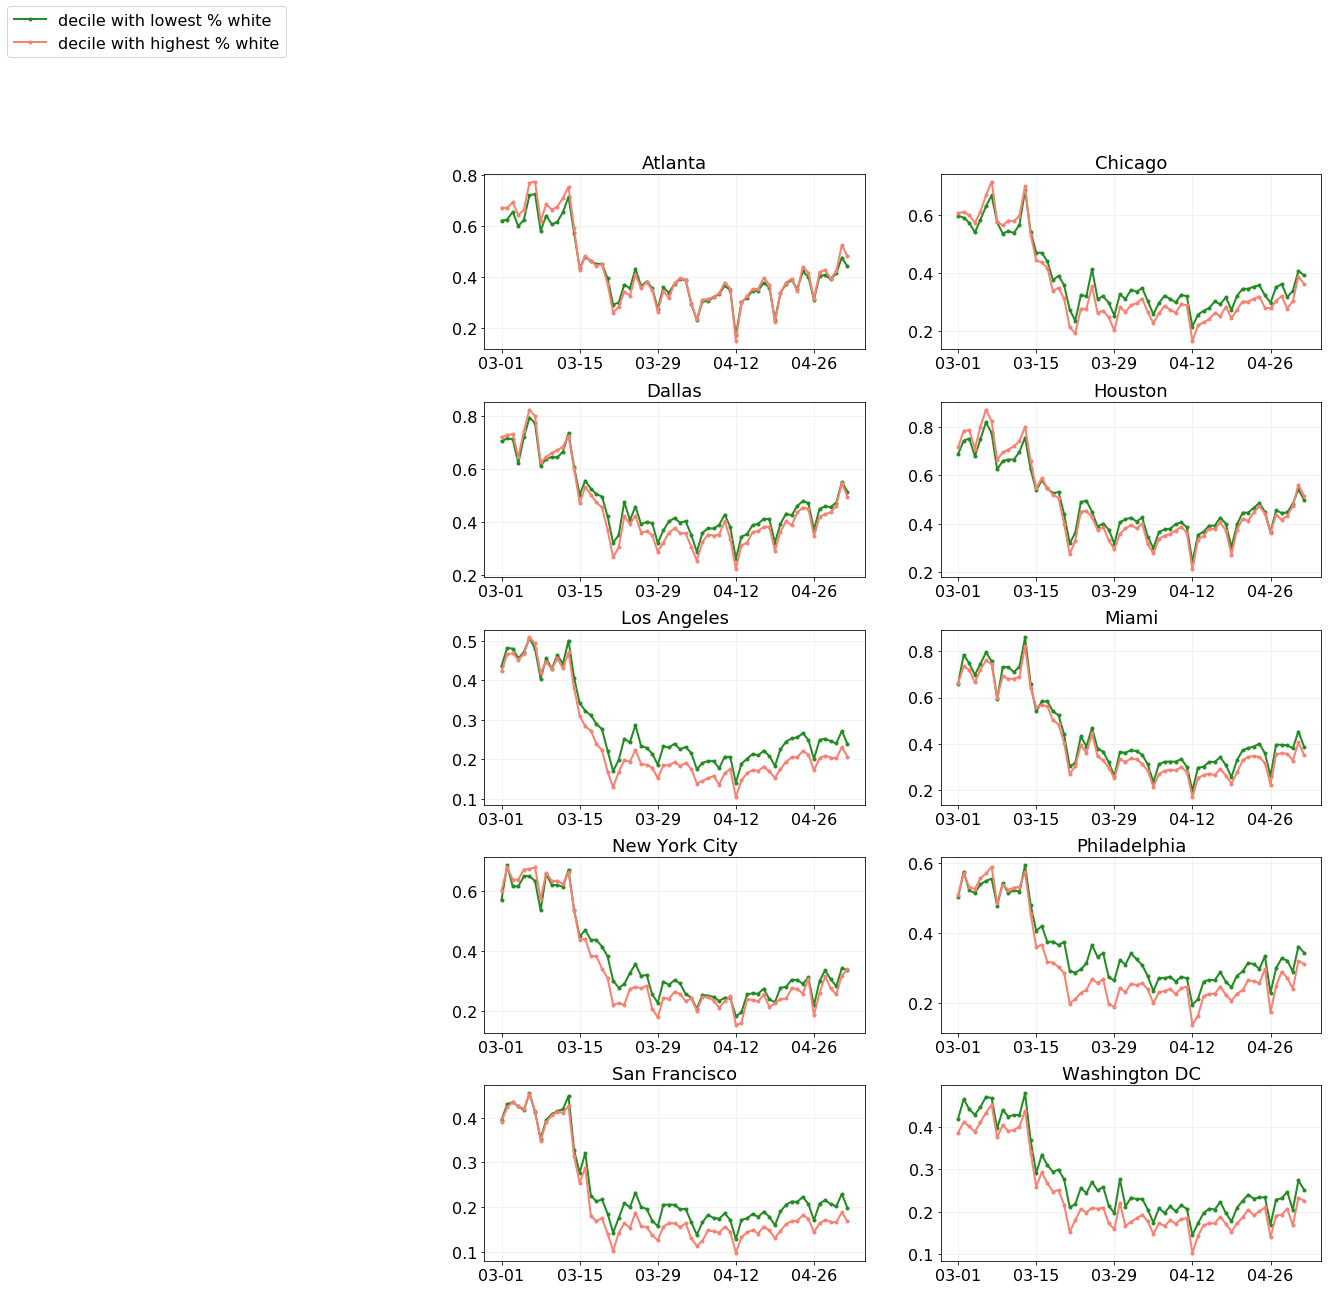

In [68]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=14)
    make_mobility_comparison_line_plot(poi_and_cbg_characteristics, msa_name, MIN_DATETIME, MAX_DATETIME, 
                                       NONWHITE, 'decile with lowest % white', 'forestgreen',
                                       WHITE, 'decile with highest % white', 'salmon', 
                                       ax, set_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.5, 2), fontsize=16)
plt.show()

## Fig 3e: transmission rates per category

In [83]:
categories_to_plot = pretty_top_categories
categories_to_label = categories_to_plot
msa_characteristics = poi_and_cbg_characteristics[HIGHLIGHT_MSA]
cbg_idx_groups_to_track = msa_characteristics['cbg_idx_groups_to_track']
cbg_sizes = msa_characteristics['cbg_sizes']

li_poi_attr = get_poi_attributes_for_msa(poi_and_cbg_characteristics, HIGHLIGHT_MSA, group_to_track=LOWINCOME)
li_pop_size = np.sum(cbg_sizes[cbg_idx_groups_to_track[LOWINCOME]])
li_cat_attr = get_category_attributes_from_poi_attributes(li_poi_attr, categories_to_plot, pop_size=li_pop_size)
hi_poi_attr = get_poi_attributes_for_msa(poi_and_cbg_characteristics, HIGHLIGHT_MSA, group_to_track=HIGHINCOME)
hi_pop_size = np.sum(cbg_sizes[cbg_idx_groups_to_track[HIGHINCOME]])
hi_cat_attr = get_category_attributes_from_poi_attributes(hi_poi_attr, categories_to_plot, pop_size=hi_pop_size)

Aggregating data from 1512 hours
Dropped 48369/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 40009/62420 POIs with 0 visits in this time period.


Top 10 categories with most visits: [('Full-Service Restaurants', 2.8787662392188933), ('Grocery Stores', 1.6059345028265968), ('Limited-Service Restaurants', 1.367894419163265), ('Other General Stores', 1.275297587235133), ('Fitness Centers', 1.1407949660148404), ('Gas Stations', 0.9431404724985963), ('Cafes & Snack Bars', 0.9166989530350612), ('Religious Organizations', 0.8977196641460066), ('Offices of Physicians', 0.48973614090362483), ('Hardware Stores', 0.48240175697002835)]


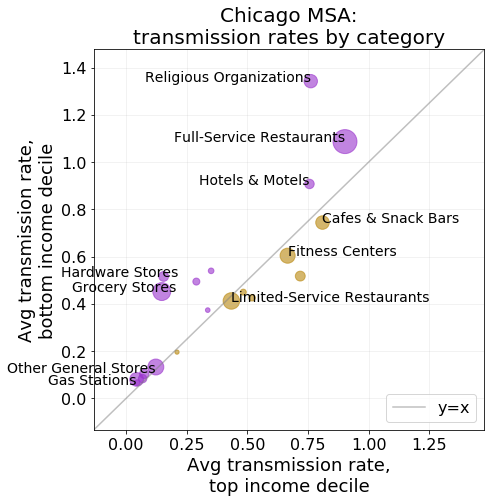

In [85]:
fig, ax = plt.subplots(figsize=(7, 7))
attribute = 'avg_transmission_rate'
title = '%s MSA:\ntransmission rates by category' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA]
xlabel = 'Avg transmission rate,\ntop income decile'
ylabel = 'Avg transmission rate,\nbottom income decile'
X, Y, cats = make_category_comparison_scatter_plot(hi_cat_attr, li_cat_attr, 
                                                   attribute, ax, 'darkgoldenrod', 'darkorchid', title,
                                                   xlabel, ylabel, psi=1764)
for x_pt, y_pt, cat in zip(X, Y, cats):
    if cat in pretty_top_categories[:10]:
        if cat in {'Gas Stations', 'Other General Stores'}:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='right', 
                        xytext=(0, -5), textcoords='offset pixels', fontsize=14)
        elif cat in {'Grocery Stores', 'Hardware Stores'}:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='right', 
                        xytext=(15, 0), textcoords='offset pixels', fontsize=14)
        elif x_pt < y_pt:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='right', fontsize=14)
        else:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='left', fontsize=14)
plt.savefig('covid_figures_for_paper/%s_transmission_rate.pdf' % HIGHLIGHT_MSA, dpi=600, bbox_inches='tight')

## Supplement: transmission rate ratio tables

In [71]:
all_ses_results = get_attribute_ratios_for_all_msas(LOWINCOME, HIGHINCOME, 
                                                    poi_and_cbg_characteristics, pretty_top_categories)

Getting results for Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 26945/39411 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24276/39411 POIs with 0 visits in this time period.
Getting results for Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 48369/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 40009/62420 POIs with 0 visits in this time period.
Getting results for Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 36094/52999 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 31390/52999 POIs with 0 visits in this time period.
Getting results for Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 35974/49622 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24895/49622 POIs with 0 visits in this time period.
Getting results for Los_Angeles_Long_Beach

In [72]:
# make summary dataframe of avg_transmission_rate ratios for MSA x category
mat = np.zeros((len(pretty_top_categories), len(MSAS)))
for i, cat in enumerate(pretty_top_categories):
    subdf = all_ses_results[all_ses_results['category'] == cat]
    for j, msa_name in enumerate(MSAS):
        results = subdf[subdf['MSA_name'] == msa_name]
        assert len(results) == 1
        mat[i, j] = round(results['avg_transmission_rate_ratio'], 3)

# median ratio per msa, aggregated over categories
msa_medians = np.round(np.median(mat, axis=0), 3)
for msa, median in zip(MSAS, msa_medians):
    print(msa, median)

cols = [MSAS_TO_PRETTY_NAMES[m] for m in MSAS]
summary_df = pd.DataFrame(mat, columns=cols, index=pretty_top_categories)
summary_df['Med'] = np.round(np.median(summary_df.values, axis=1), 3)
summary_df

Atlanta_Sandy_Springs_Roswell_GA 1.188
Chicago_Naperville_Elgin_IL_IN_WI 1.202
Dallas_Fort_Worth_Arlington_TX 0.968
Houston_The_Woodlands_Sugar_Land_TX 0.915
Los_Angeles_Long_Beach_Anaheim_CA 1.33
Miami_Fort_Lauderdale_West_Palm_Beach_FL 1.304
New_York_Newark_Jersey_City_NY_NJ_PA 1.746
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 1.702
San_Francisco_Oakland_Hayward_CA 1.196
Washington_Arlington_Alexandria_DC_VA_MD_WV 1.166


Atlanta  Chicago  Dallas  Houston  Los Angeles  Miami  New York City  Philadelphia  San Francisco  Washington DC    Med
Full-Service Restaurants       0.764    1.204   0.956    1.000        1.445  1.232          2.035         2.883          1.758          1.171  1.218
Limited-Service Restaurants    0.940    0.950   1.002    0.906        1.067  0.872          1.901         1.614          0.994          0.962  0.978
Other General Stores           0.782    1.083   0.957    0.729        0.760  0.894          1.218         1.312          1.045          0.950  0.954
Gas Stations                   1.326    1.865   1.310    1.515        2.254  2.195          1.899         6.461          1.357          1.870  1.868
Fitness Centers                0.536    0.907   0.708    0.670        1.461  0.789          1.151         1.516          0.995          1.160  0.951
Grocery Stores                 0.948    3.080   0.838    1.333        2.408  1.498          4.984        10.437          2.478          1.977  2.192
Cafes & Snack Bars             1.385    0.919   0.716    1.120        1.327  2.168          1.943         1.757          0.982          0.932  1.224
Hotels & Motels                1.228    1.200   0.814    0.804        1.229  1.134          1.260         1.993          1.199          1.346  1.214
Religious Organizations        1.546    1.763   0.956    0.919        1.746  1.464          1.756         1.736          1.515          1.852  1.641
Hardware Stores                3.938    3.340   1.575    2.111        1.333  0.939          3.553         6.716          4.202         13.560  3.446
Department Stores              1.132    1.230   0.978    0.911        1.083  1.431          1.667         0.976          0.867          1.042  1.062
Offices of Physicians          1.235    0.721   0.667    1.036        1.141  1.687          1.307         1.319          1.193          0.445  1.167
Pharmacies & Drug Stores       1.636    1.389   1.176    0.854        1.718  1.555          2.577         5.624          1.200          1.699  1.596
Sporting Goods Stores          0.936    1.540   1.129    0.812        1.168  0.700          1.253         1.161          0.826          2.777  1.145
Automotive Parts Stores        0.890    1.707   0.862    1.086        1.990  1.414          1.524         2.697          1.753          1.246  1.469
Used Merchandise Stores        0.993    0.931   1.000    1.315        1.017  1.074          1.352         1.668          1.587          0.814  1.046
Convenience Stores             1.208    0.932   1.613    0.647        0.838  0.824          1.736         2.322          1.086          1.428  1.147
Pet Stores                     1.260    0.820   1.192    1.487        1.536  0.776          3.558         1.652          2.124          0.905  1.374
New Car Dealers                2.036    1.471   0.741    0.809        1.180  1.377          2.022         1.129          0.395          0.872  1.154
Hobby & Toy Stores             1.168    1.110   1.165    0.853        1.771  1.520          1.525         1.088          0.883          0.926  1.138

In [73]:
summary_df.median()

Atlanta          1.1880
Chicago          1.2020
Dallas           0.9675
Houston          0.9150
Los Angeles      1.3300
Miami            1.3045
New York City    1.7460
Philadelphia     1.7020
San Francisco    1.1960
Washington DC    1.1655
Med              1.1905
dtype: float64

In [74]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &  Atlanta &  Chicago &  Dallas &  Houston &  Los Angeles &  Miami &  New York City &  Philadelphia &  San Francisco &  Washington DC &    Med \\\\\n\\midrule\nFull-Service Restaurants    &    0.764 &    1.204 &   0.956 &    1.000 &        1.445 &  1.232 &          2.035 &         2.883 &          1.758 &          1.171 &  1.218 \\\\\nLimited-Service Restaurants &    0.940 &    0.950 &   1.002 &    0.906 &        1.067 &  0.872 &          1.901 &         1.614 &          0.994 &          0.962 &  0.978 \\\\\nOther General Stores        &    0.782 &    1.083 &   0.957 &    0.729 &        0.760 &  0.894 &          1.218 &         1.312 &          1.045 &          0.950 &  0.954 \\\\\nGas Stations                &    1.326 &    1.865 &   1.310 &    1.515 &        2.254 &  2.195 &          1.899 &         6.461 &          1.357 &          1.870 &  1.868 \\\\\nFitness Centers             &    0.536 &    0.907 &   0.708 &    0.670 &        1.461

In [75]:
subdf = all_ses_results[all_ses_results['category'] == 'Grocery Stores']
subdf.median()[['avg_dwell_time_ratio', 'avg_people_per_sq_ft_ratio', 'avg_transmission_rate_ratio']]

avg_dwell_time_ratio           1.167091
avg_people_per_sq_ft_ratio     1.587962
avg_transmission_rate_ratio    2.192200
dtype: float64

In [76]:
all_ses_results[(all_ses_results['category'] == 'Grocery Stores') & (all_ses_results['MSA_name'] == 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD')]

avg_dwell_time_ratio  avg_people_per_sq_ft_ratio  avg_transmission_rate_ratio        category                                    MSA_name
5              1.856997                    5.351303                    10.436994  Grocery Stores  Philadelphia_Camden_Wilmington_PA_NJ_DE_MD

In [77]:
all_race_results = get_attribute_ratios_for_all_msas(NONWHITE, WHITE,
                                                     poi_and_cbg_characteristics, pretty_top_categories)

Getting results for Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 31635/39411 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24848/39411 POIs with 0 visits in this time period.
Getting results for Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 53759/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 41785/62420 POIs with 0 visits in this time period.
Getting results for Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 41348/52999 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 32715/52999 POIs with 0 visits in this time period.
Getting results for Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 39053/49622 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 33621/49622 POIs with 0 visits in this time period.
Getting results for Los_Angeles_Long_Beach

In [78]:
# make summary dataframe of avg_transmission_rate ratios for MSA x category
mat = np.zeros((len(pretty_top_categories), len(MSAS)))
for i, cat in enumerate(pretty_top_categories):
    subdf = all_race_results[all_race_results['category'] == cat]
    for j, msa_name in enumerate(MSAS):
        results = subdf[subdf['MSA_name'] == msa_name]
        assert len(results) == 1
        mat[i, j] = round(results['avg_transmission_rate_ratio'], 3)

# median ratio per msa, aggregated over categories
msa_medians = np.round(np.median(mat, axis=0), 3)
for msa, median in zip(MSAS, msa_medians):
    print(msa, median)

cols = [MSAS_TO_PRETTY_NAMES[m] for m in MSAS]
summary_df = pd.DataFrame(mat, columns=cols, index=pretty_top_categories)
summary_df['Med'] = np.round(np.median(summary_df.values, axis=1), 3)
summary_df

Atlanta_Sandy_Springs_Roswell_GA 0.932
Chicago_Naperville_Elgin_IL_IN_WI 1.338
Dallas_Fort_Worth_Arlington_TX 0.888
Houston_The_Woodlands_Sugar_Land_TX 0.959
Los_Angeles_Long_Beach_Anaheim_CA 1.303
Miami_Fort_Lauderdale_West_Palm_Beach_FL 1.092
New_York_Newark_Jersey_City_NY_NJ_PA 1.955
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 2.281
San_Francisco_Oakland_Hayward_CA 1.119
Washington_Arlington_Alexandria_DC_VA_MD_WV 1.314


Atlanta  Chicago  Dallas  Houston  Los Angeles  Miami  New York City  Philadelphia  San Francisco  Washington DC    Med
Full-Service Restaurants       0.802    1.354   0.981    0.965        1.065  1.167          2.418         2.661          1.223          1.013  1.116
Limited-Service Restaurants    0.940    1.144   1.028    0.940        0.820  0.919          2.136         1.523          0.799          1.346  0.984
Other General Stores           0.776    1.277   0.838    0.841        1.527  1.132          2.158         1.313          0.925          1.312  1.204
Gas Stations                   1.402    1.891   1.389    1.190        1.336  1.857          1.818         2.286          2.321          1.316  1.610
Fitness Centers                0.607    1.167   0.670    0.831        0.780  1.066          1.447         1.977          1.103          1.205  1.084
Grocery Stores                 0.589    3.664   0.613    1.195        2.386  0.950          5.864        13.705          2.243          2.262  2.252
Cafes & Snack Bars             1.308    1.104   0.845    0.840        0.976  2.619          1.767         2.456          1.045          0.867  1.074
Hotels & Motels                0.977    1.007   1.366    0.718        1.112  1.024          1.449         2.494          0.654          0.899  1.015
Religious Organizations        0.938    1.606   1.060    0.953        2.096  1.795          1.933         2.040          1.674          1.188  1.640
Hardware Stores                0.909    3.900   1.523    1.461        1.952  0.586          5.032         3.898         11.103         13.432  2.925
Department Stores              1.081    1.301   0.805    0.777        0.992  2.337          2.479         1.357          1.089          1.402  1.195
Offices of Physicians          0.894    1.323   1.006    1.415        0.898  1.117          1.652         2.073          0.694          1.911  1.220
Pharmacies & Drug Stores       0.888    1.376   0.930    0.732        1.538  1.674          3.315         3.366          1.135          1.715  1.457
Sporting Goods Stores          0.767    0.674   0.650    0.506        1.946  0.818          1.532         2.152          0.880          1.715  0.849
Automotive Parts Stores        1.049    1.479   1.010    1.353        2.998  2.657          1.740         3.387          1.646          0.601  1.562
Used Merchandise Stores        0.858    1.195   0.699    1.060        1.270  0.593          1.500         3.024          1.425          0.799  1.128
Convenience Stores             2.016    5.055   1.272    2.188        0.761  0.902          1.911         2.276          1.239          1.844  1.878
Pet Stores                     0.925    1.624   0.724    1.465        1.506  0.881          2.715        10.182          1.568          2.408  1.537
New Car Dealers                1.008    1.398   0.812    0.736        0.942  0.998          1.977         0.866          0.772          0.383  0.904
Hobby & Toy Stores             2.569    0.853   0.628    0.979        1.373  1.388          2.237         0.825          0.864          1.286  1.132

In [79]:
summary_df.median()

Atlanta          0.9315
Chicago          1.3385
Dallas           0.8875
Houston          0.9590
Los Angeles      1.3030
Miami            1.0915
New York City    1.9550
Philadelphia     2.2810
San Francisco    1.1190
Washington DC    1.3140
Med              1.1995
dtype: float64

In [80]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &  Atlanta &  Chicago &  Dallas &  Houston &  Los Angeles &  Miami &  New York City &  Philadelphia &  San Francisco &  Washington DC &    Med \\\\\n\\midrule\nFull-Service Restaurants    &    0.802 &    1.354 &   0.981 &    0.965 &        1.065 &  1.167 &          2.418 &         2.661 &          1.223 &          1.013 &  1.116 \\\\\nLimited-Service Restaurants &    0.940 &    1.144 &   1.028 &    0.940 &        0.820 &  0.919 &          2.136 &         1.523 &          0.799 &          1.346 &  0.984 \\\\\nOther General Stores        &    0.776 &    1.277 &   0.838 &    0.841 &        1.527 &  1.132 &          2.158 &         1.313 &          0.925 &          1.312 &  1.204 \\\\\nGas Stations                &    1.402 &    1.891 &   1.389 &    1.190 &        1.336 &  1.857 &          1.818 &         2.286 &          2.321 &          1.316 &  1.610 \\\\\nFitness Centers             &    0.607 &    1.167 &   0.670 &    0.831 &        0.780

## Supplement: num visits per capita to POI categories

Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 26945/39411 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24276/39411 POIs with 0 visits in this time period.
Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 48369/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 40009/62420 POIs with 0 visits in this time period.
Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 36094/52999 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 31390/52999 POIs with 0 visits in this time period.
Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 35974/49622 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24895/49622 POIs with 0 visits in this time period.
Los_Angeles_Long_Beach_Anaheim_CA
Aggregating data from 1512 hours
Dropped 57729/83954 POIs with 0 visits in this time per

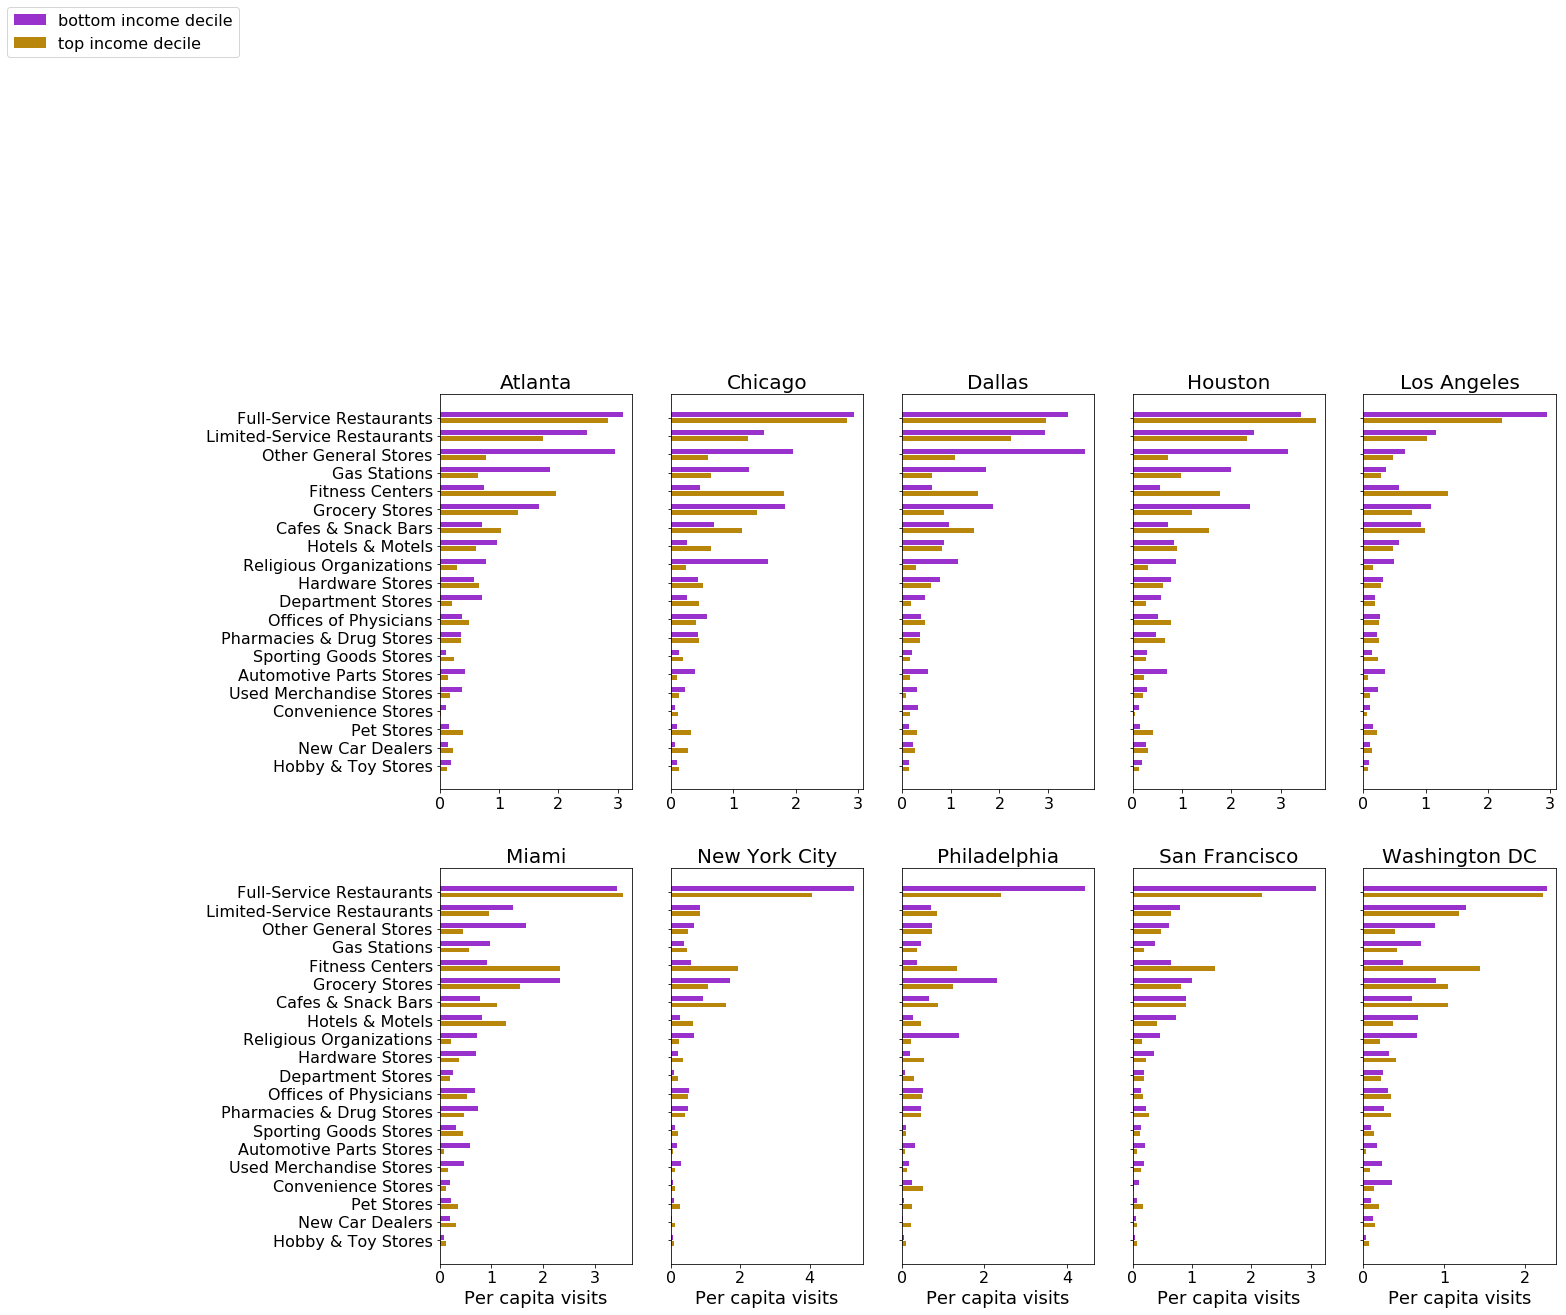

In [81]:
fig, axes = plt.subplots(2, 5, figsize=(20, 16), sharey=True)
axes = [ax for axes_row in axes for ax in axes_row]
reverse_categories = pretty_top_categories.copy()
reverse_categories.reverse()  # reverse so that most popular category is on top
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    plot_per_capita_category_visits(poi_and_cbg_characteristics, msa_name, 
                                LOWINCOME, 'bottom income decile', 'darkorchid',
                                HIGHINCOME, 'top income decile', 'darkgoldenrod', 
                                reverse_categories, ax, set_axis_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=20)
    if i >= 5:
        ax.set_xlabel('Per capita visits', fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-1, 2), fontsize=16)
plt.show()